In [4]:

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from keras.layers import BatchNormalization,LeakyReLU,Flatten
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Model
from keras.optimizers import Adam

#from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle
#from google.colab import drive



In [5]:
def plot(A,B,C,n):

    samples = [A,B,C]
    fig = plt.figure(figsize=(3,n), dpi = 1000)
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32) )
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [6]:
#for plotting any two images in case

def ploty(A,B,n):

    samples = [A,B]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(2):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32, 1))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [ ]:
drive.mount('/content/gdrive',force_remount=True)

In [7]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y=x_train
x=np.sum(y, axis=3)/(3*255)

y_test=x_test
x_test=np.sum(x_test, axis=3)/(3*255)   #for converting RGB into singe channel
x_test=x_test.reshape(10000, 32, 32, 1)


y=x_train/255
y=y*2-1


#x=x*2-1
#x=np.dot(y[...,:3], [0.299, 0.587, 0.114])/255
#x=x.reshape(50000,32, 32,1)

x=x.reshape(50000, 32, 32, 1)

print(x.shape)
print(y.shape)
  

170498071/170498071 [==============================] - 19s 0us/step
(50000, 32, 32, 1)
(50000, 32, 32, 3)


In [8]:
  
x_shape=(32,32,1)
y_shape=(32,32,3)

In [9]:
def Generator():
  X = Input(shape = x_shape)
  
  #C1 = ZeroPadding2D(padding=(1,1))(X)  
  C1 = Conv2D(64,kernel_size = 1, strides = 1,input_shape = x_shape)(X)
  C1 = LeakyReLU(0.2)(C1)
  
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = LeakyReLU(0.2)(C2)
  
  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = LeakyReLU(0.2)(C3)
  
  C4 = Conv2D(512,kernel_size = 2, strides = 2)(C3)
  C4 = LeakyReLU(0.2)(C4)

  C5 = Conv2D(512, kernel_size = 2, strides = 2)(C4)
  C5 = LeakyReLU(0.2)(C5)
  
  
  DC0 = Deconv2d(512, kernel_size = 2, strides = 2)(C5)
  DC0 = LeakyReLU(0.2)(DC0)
  DC0 = BatchNormalization()(DC0)
  DC0 = Dropout(0.5)(DC0)
  DC0 = Concatenate(axis=3)([DC0, C4])

  
  DC1 = Deconv2d(256,kernel_size=2, strides = 2)(DC0)
  DC1 = LeakyReLU(0.2)(DC1)
  DC1 = BatchNormalization()(DC1)  
  DC1 = Dropout(0.5)(DC1)             
  DC1 = Concatenate(axis=3)([DC1,C3])

  
  DC2 = Deconv2d(128,kernel_size=2, strides = 2)(DC1)
  DC2 = LeakyReLU(0.2)(DC2)
  DC2 = BatchNormalization()(DC2)  
  DC2 = Concatenate(axis=3)([DC2,C2])
  
  DC3 = Deconv2d(64,kernel_size=2, strides = 2)(DC2)
  DC3 = LeakyReLU(0.2)(DC3)
  DC3 = BatchNormalization()(DC3)  
  DC3 = Concatenate(axis=3)([DC3,C1])
  
  #DC4 = ZeroPadding2D(padding=(3,1))(DC3)  
  CC4 = Conv2D(3,kernel_size=(1, 1), strides = (1, 1), activation="tanh")(DC3)
  
  m = Model(X,CC4)
  m.summary()
  return m
  

In [10]:
def Discriminator():
  X = Input(shape = x_shape)
  Y = Input(shape = y_shape)
  
  In = Concatenate(axis=3)([X,Y])
  
  C1 = Conv2D(64,kernel_size = 2, strides = 2,input_shape = x_shape)(In)
  C1 = BatchNormalization()(C1)
  C1 = LeakyReLU(0.2)(C1)
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = BatchNormalization()(C2)
  C2 = LeakyReLU(0.2)(C2)
  
  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = BatchNormalization()(C3)
  C3 = LeakyReLU(0.2)(C3)
  
  C4 = Conv2D(512,kernel_size = 1, strides = 1)(C3)
  C4 = BatchNormalization()(C4)
  C4 = LeakyReLU(0.2)(C4)
  
  D = Flatten()(C4)
  D = Dense(128)(D)
  D = Dense(1,activation='sigmoid')(D)
  
  m = Model([X,Y],D)
  m.summary()
  return m
   



In [11]:
X = Input(shape = x_shape)
Y = Input(shape = y_shape)

gen = Generator()
dis = Discriminator()

out = gen(X)
comb = dis([X,out])

out = Flatten()(out)
org = Flatten()(Y)

cos_dis = Dot(axes = 1,normalize = True)([out,org])

combined = Model([X,Y],[comb,cos_dis])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   128         ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 128)  32896       ['leaky_re_lu[0][0]']            
                                                                                              

In [12]:
genLoss=[]
disLoss=[]

In [13]:
epochs = 80
batch_size = 64
n_example = 30000
batches = int(n_example/batch_size)
dis_updates = 2
gen_updates = 1
zero=np.zeros((batch_size,1))
one=np.ones((batch_size,1))*0.9
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates
reuse = True
adams = Adam(learning_rate = 0.0001)

In [ ]:
#location in drive where models are present.

if(reuse == True):
  gen.load_weights("C:/Users/exam1/Downloads/Generator.h5")
  dis.load_weights("C:/Users/exam1/Downloads/Discriminator.h5")

##############
For Epoch:0
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.1625937772890229
Generator loss:0.6630534994551259
1/1 [==============================] - 0s 334ms/step


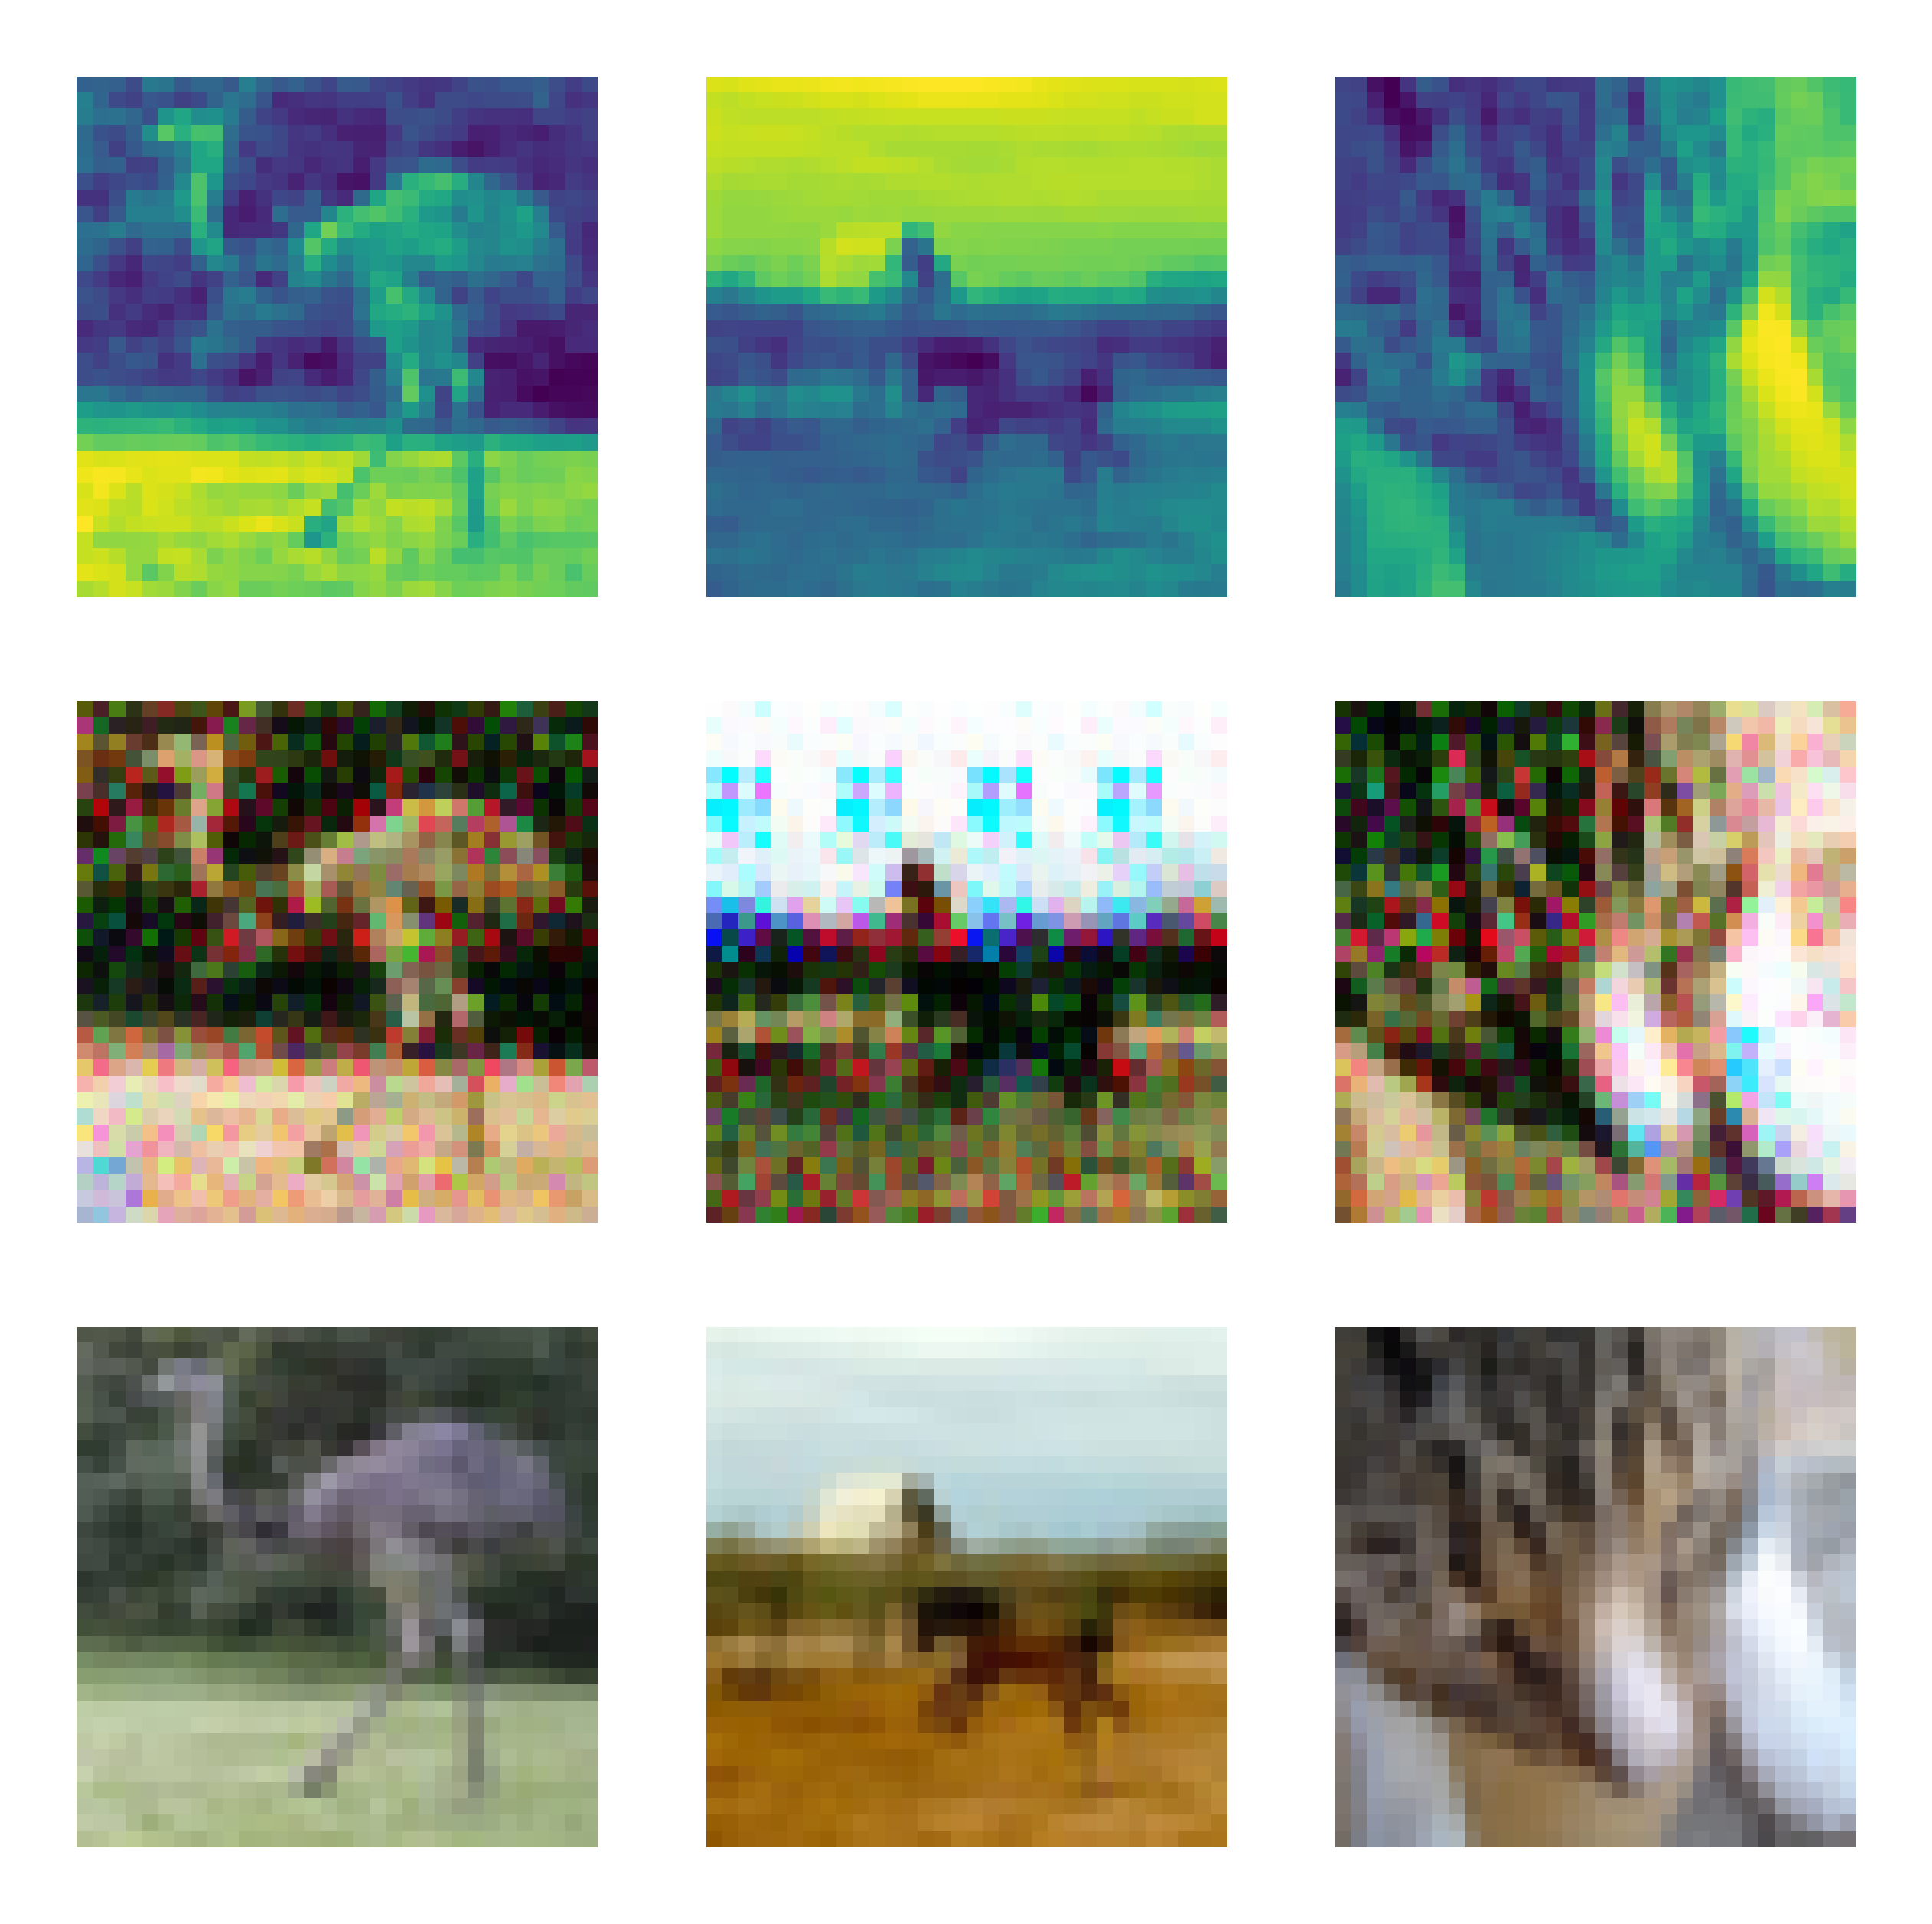

##############
For Epoch:1
Training Discriminator
2/2 [==============================] - 0s 16ms/step
Training Generator
Discriminator Loss:0.16264354200882838
Generator loss:0.6606323289820272
1/1 [==============================] - 0s 19ms/step


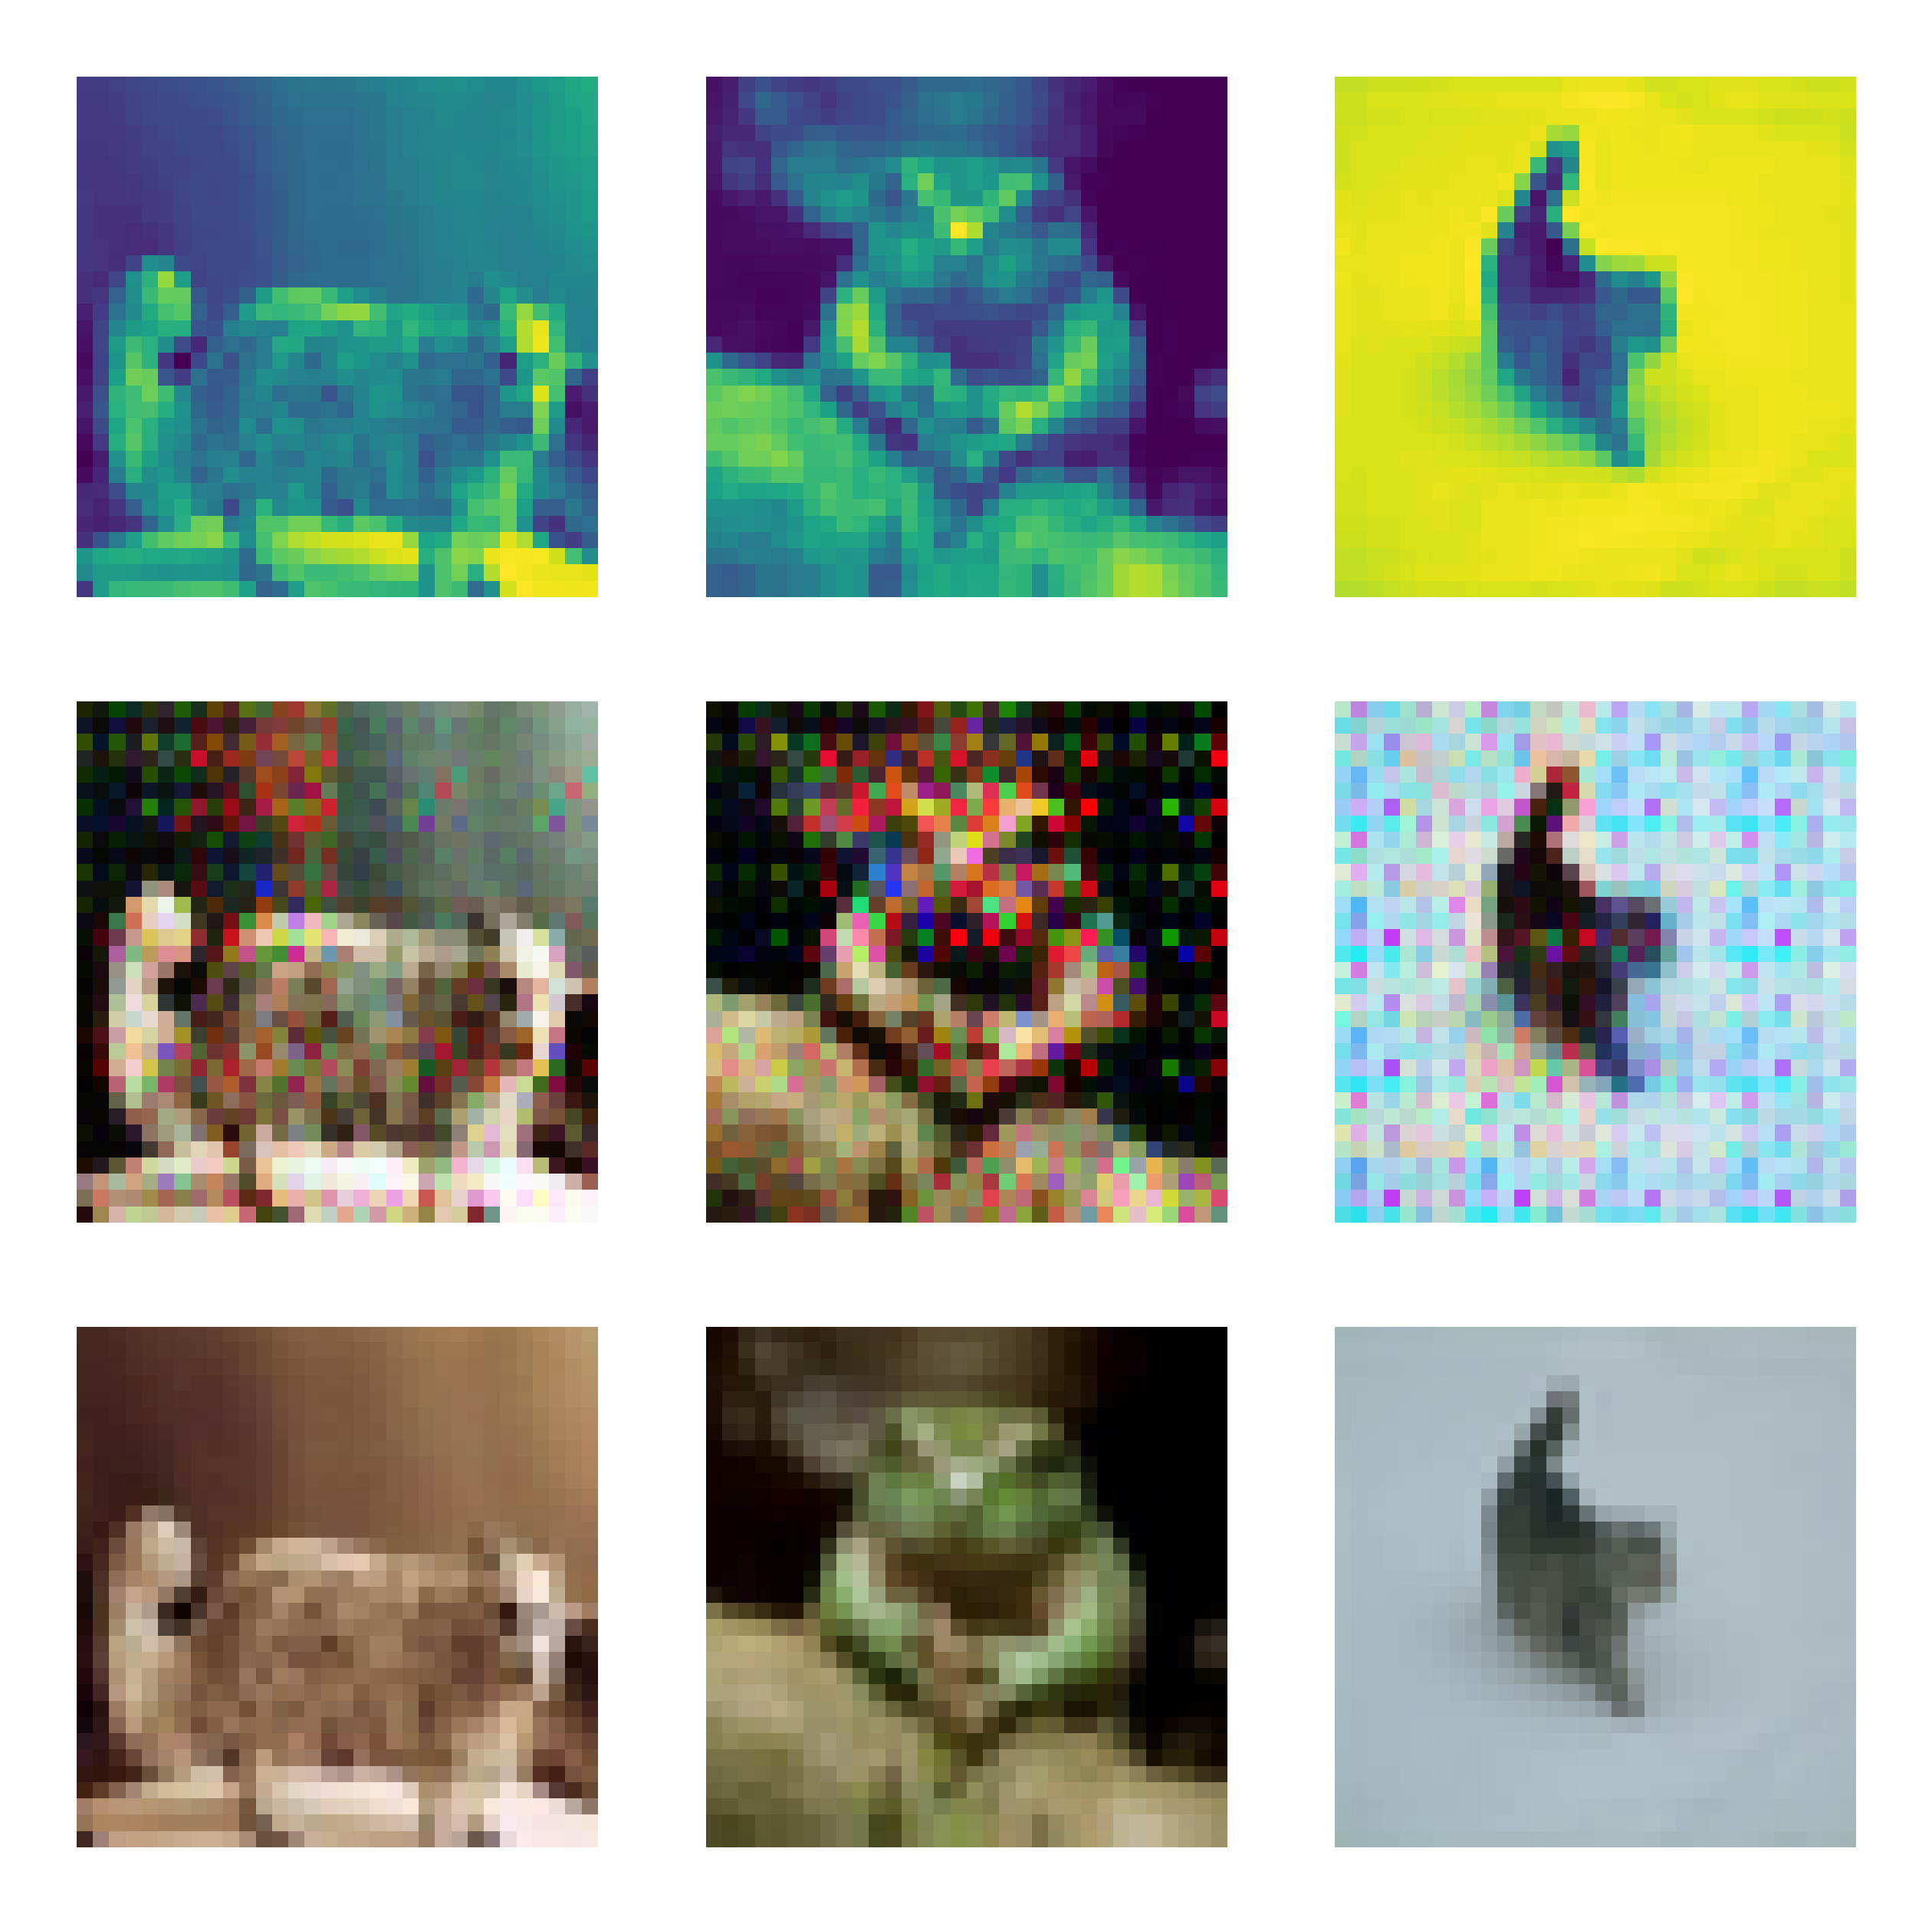

##############
For Epoch:2
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16260742258383146
Generator loss:0.6622460308747414
1/1 [==============================] - 0s 18ms/step


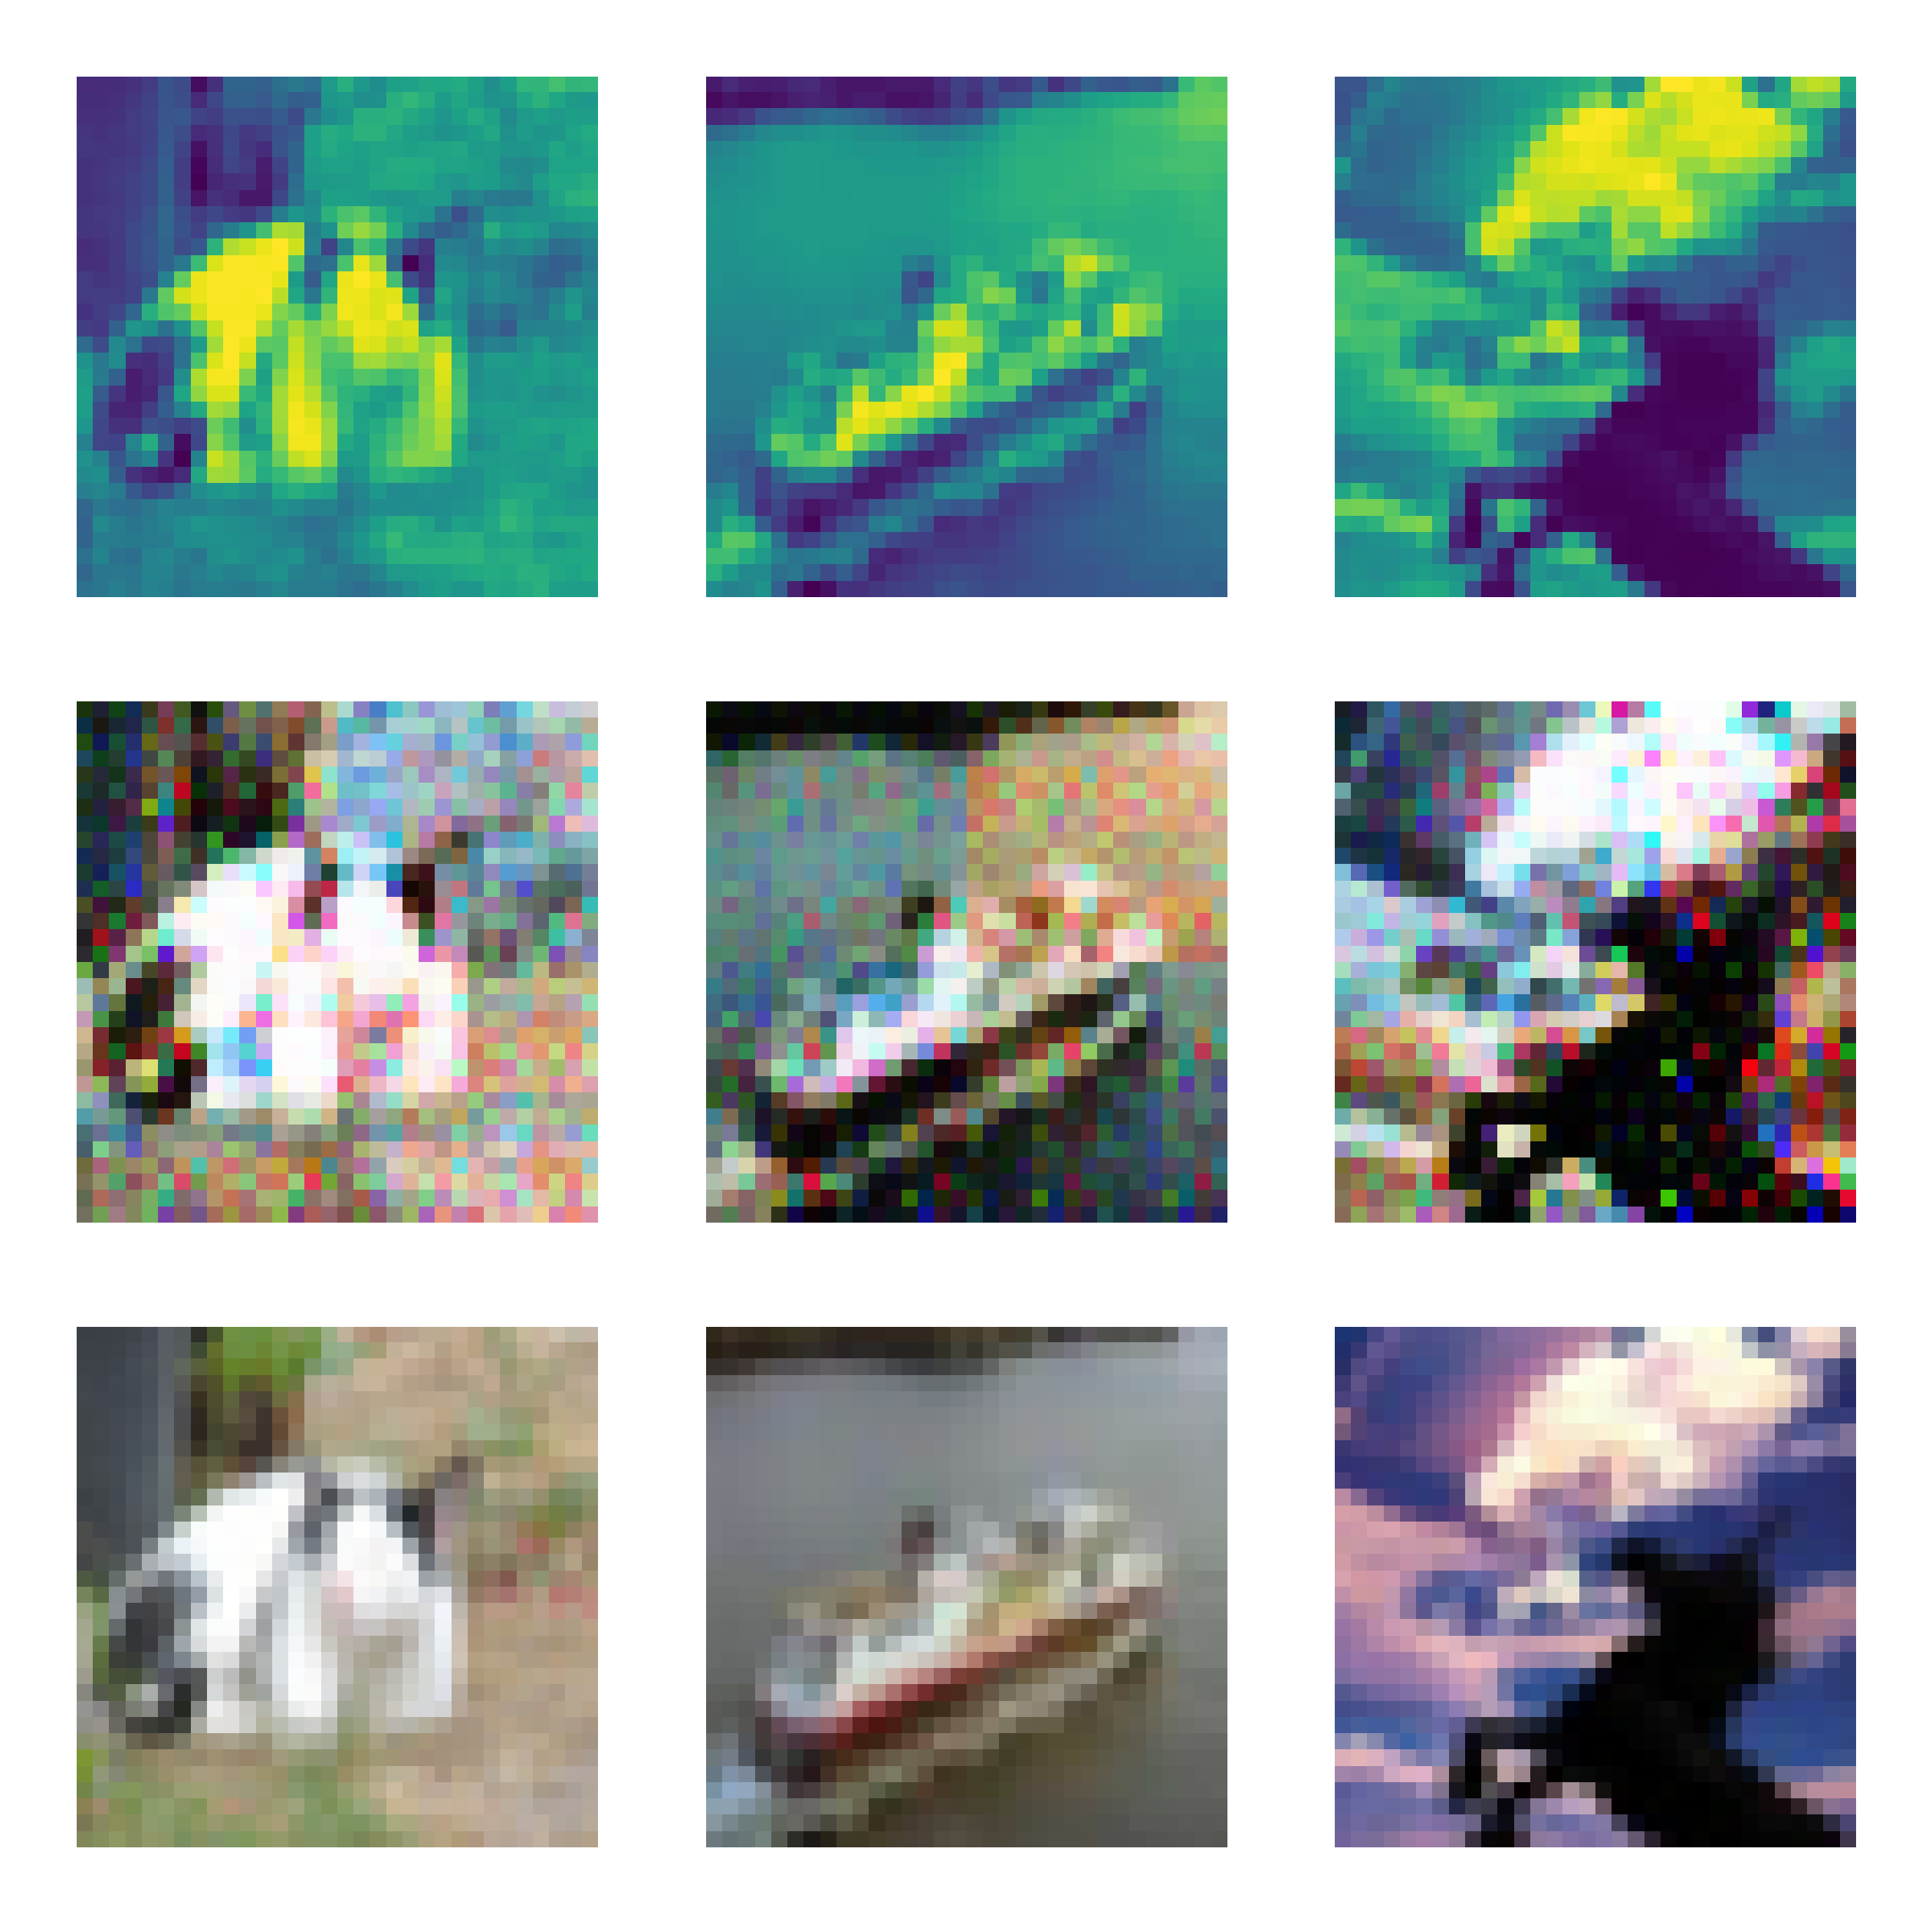

##############
For Epoch:3
Training Discriminator
2/2 [==============================] - 0s 6ms/step
Training Generator
Discriminator Loss:0.1625905128268382
Generator loss:0.6627214366299474
1/1 [==============================] - 0s 18ms/step


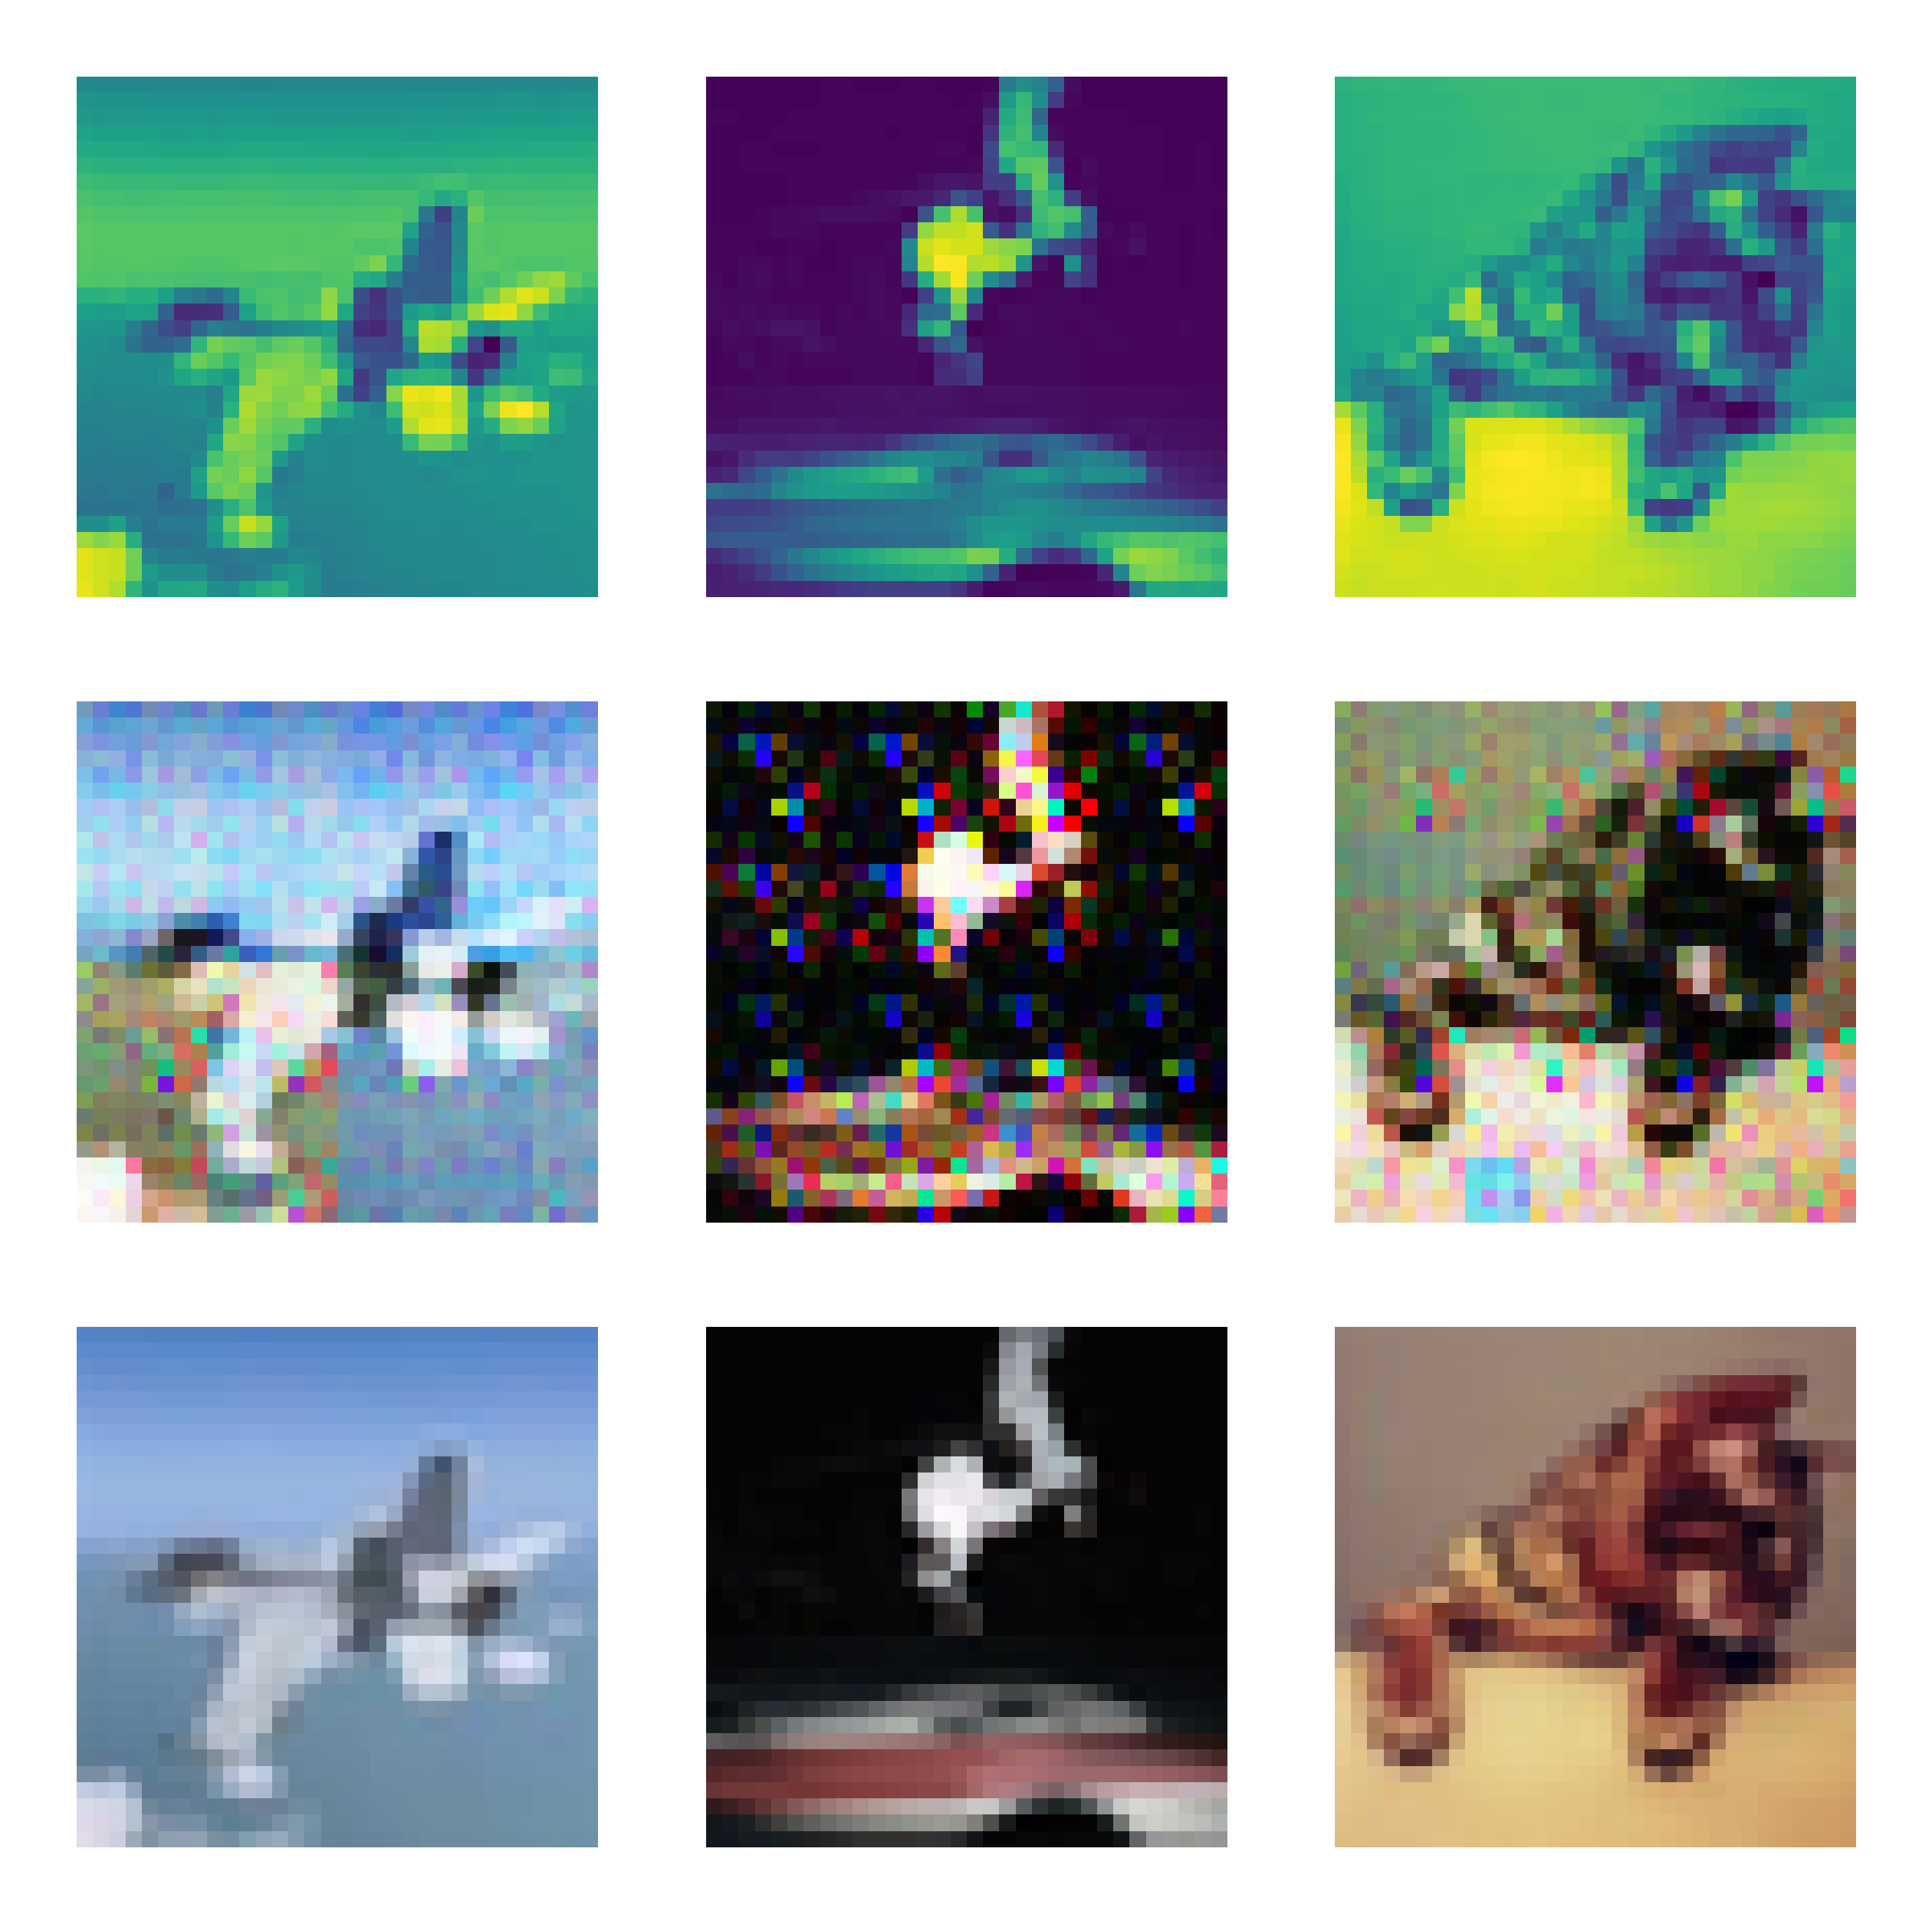

##############
For Epoch:4
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.16258884193447704
Generator loss:0.6635201200206056
1/1 [==============================] - 0s 17ms/step


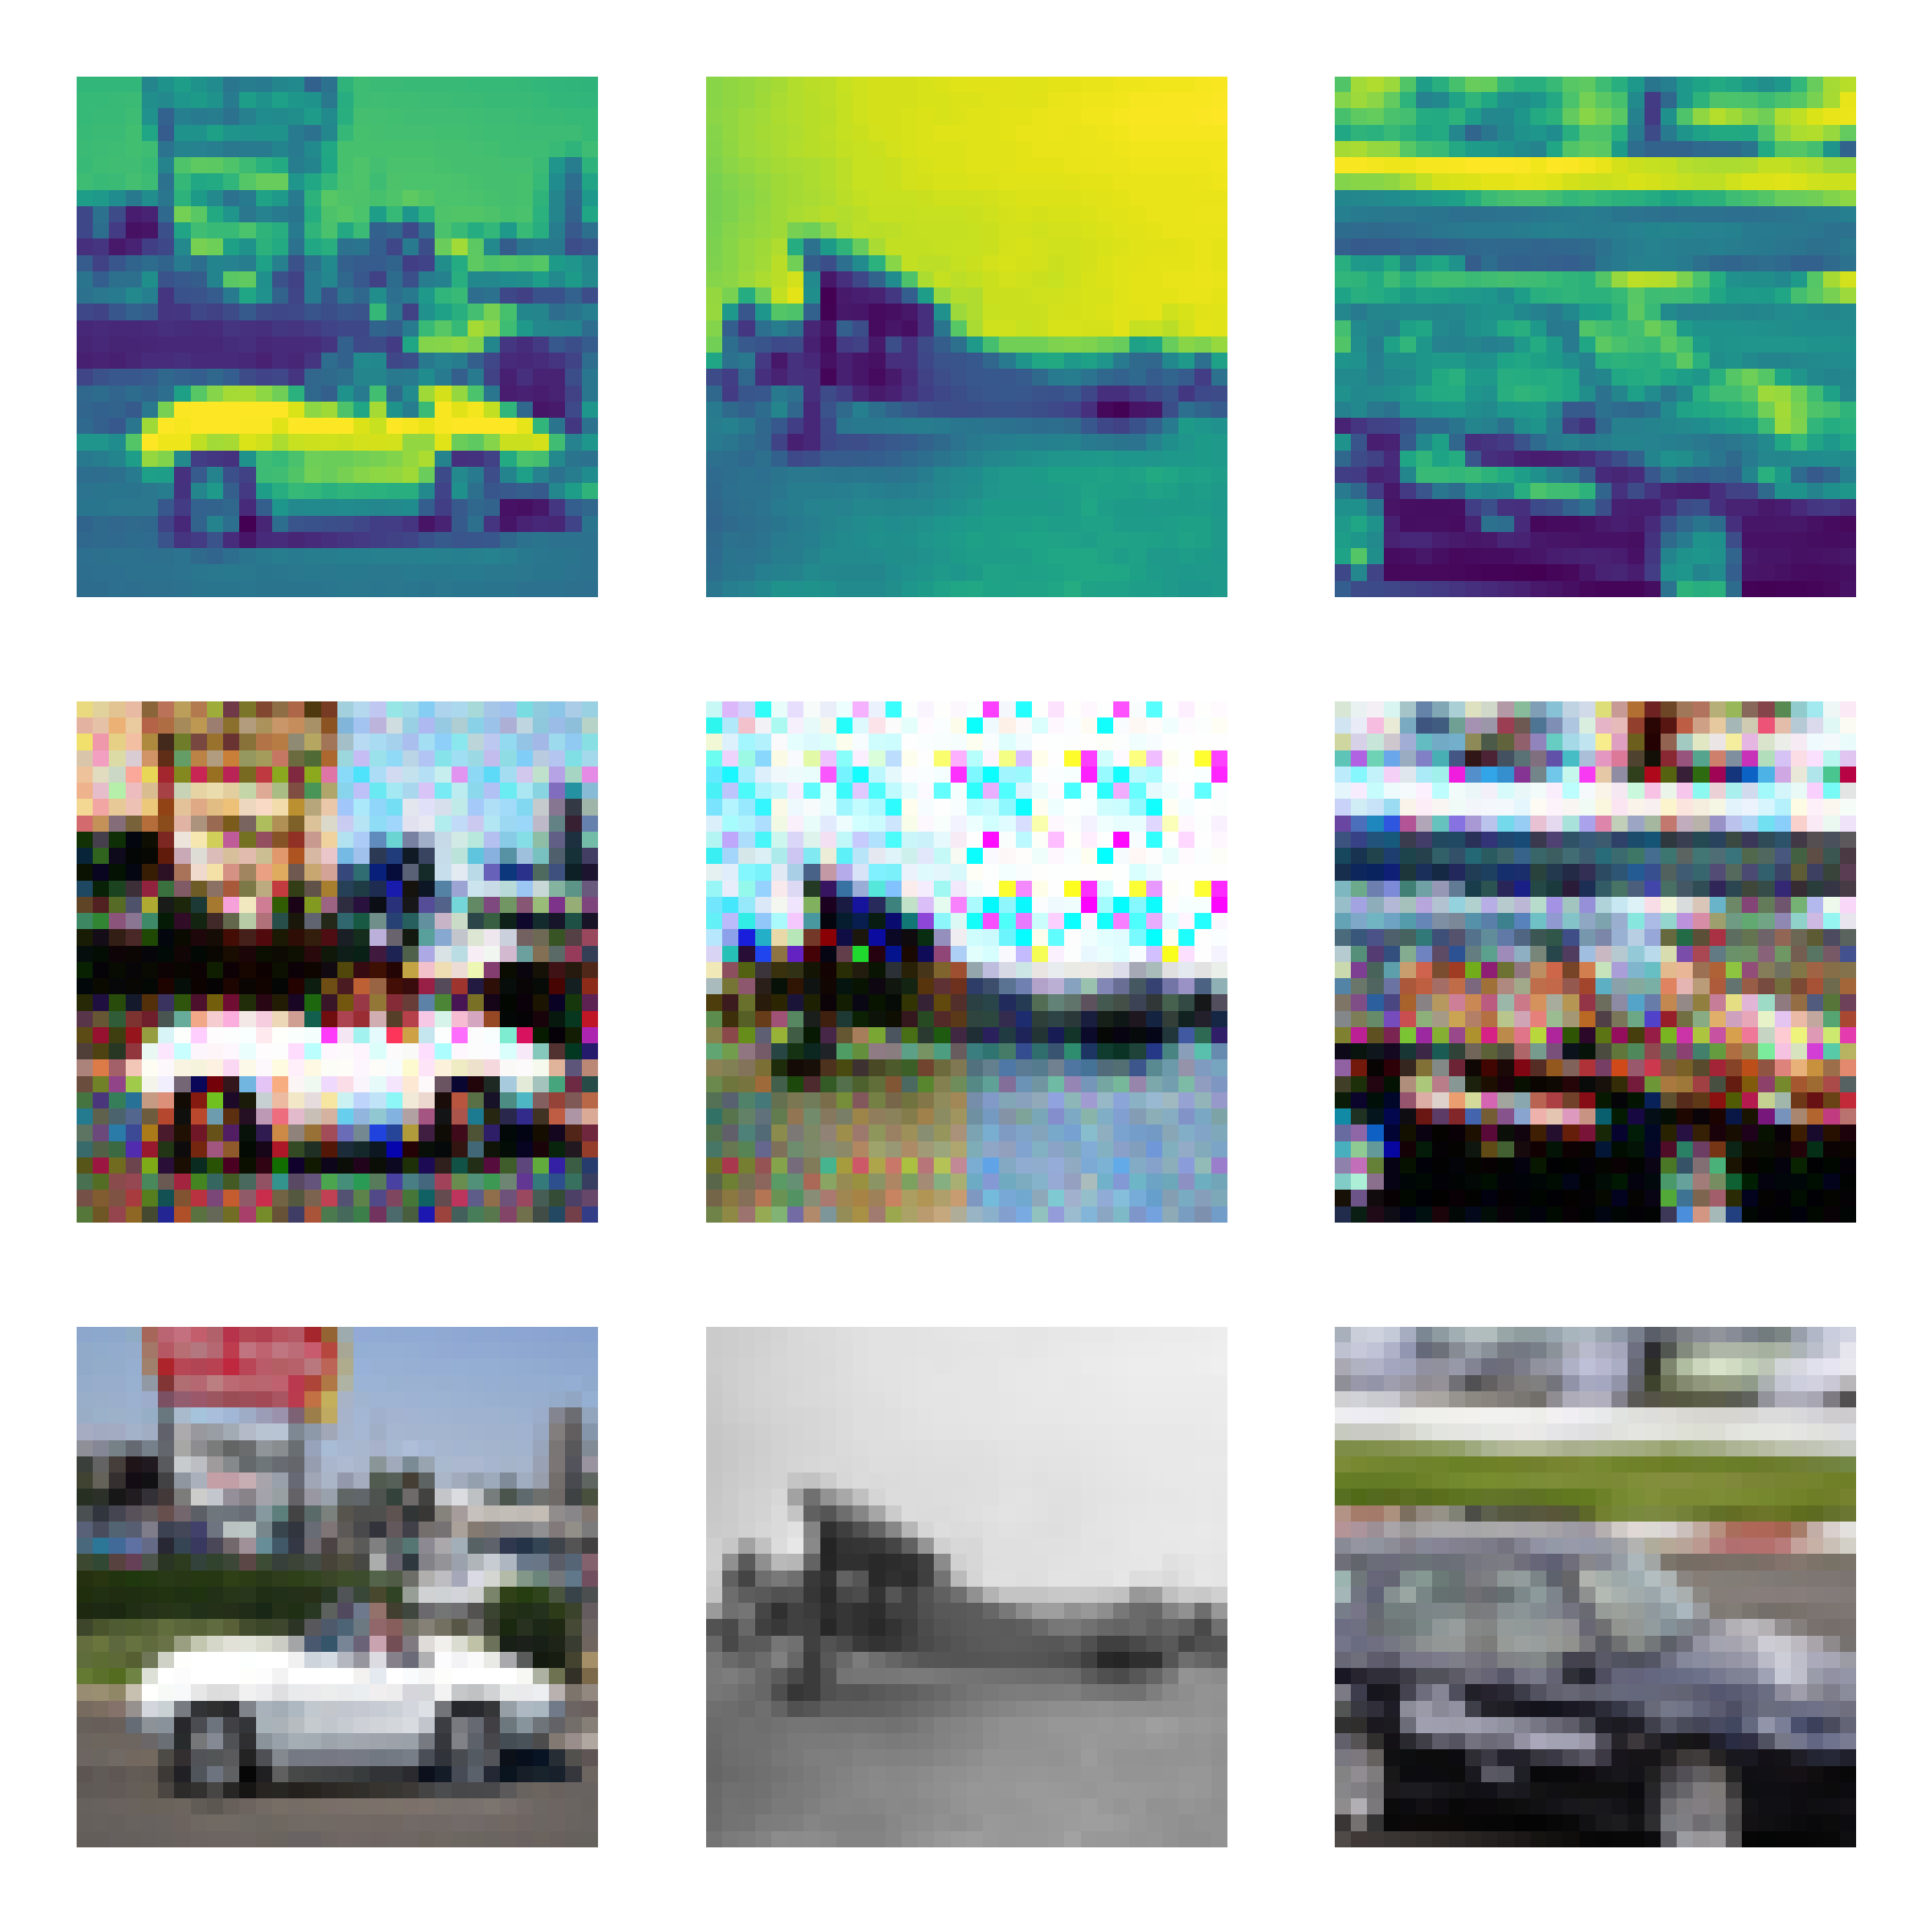

##############
For Epoch:5
Training Discriminator
2/2 [==============================] - 0s 10ms/step
Training Generator
Discriminator Loss:0.1626597177848723
Generator loss:0.6624107280602822
1/1 [==============================] - 0s 18ms/step


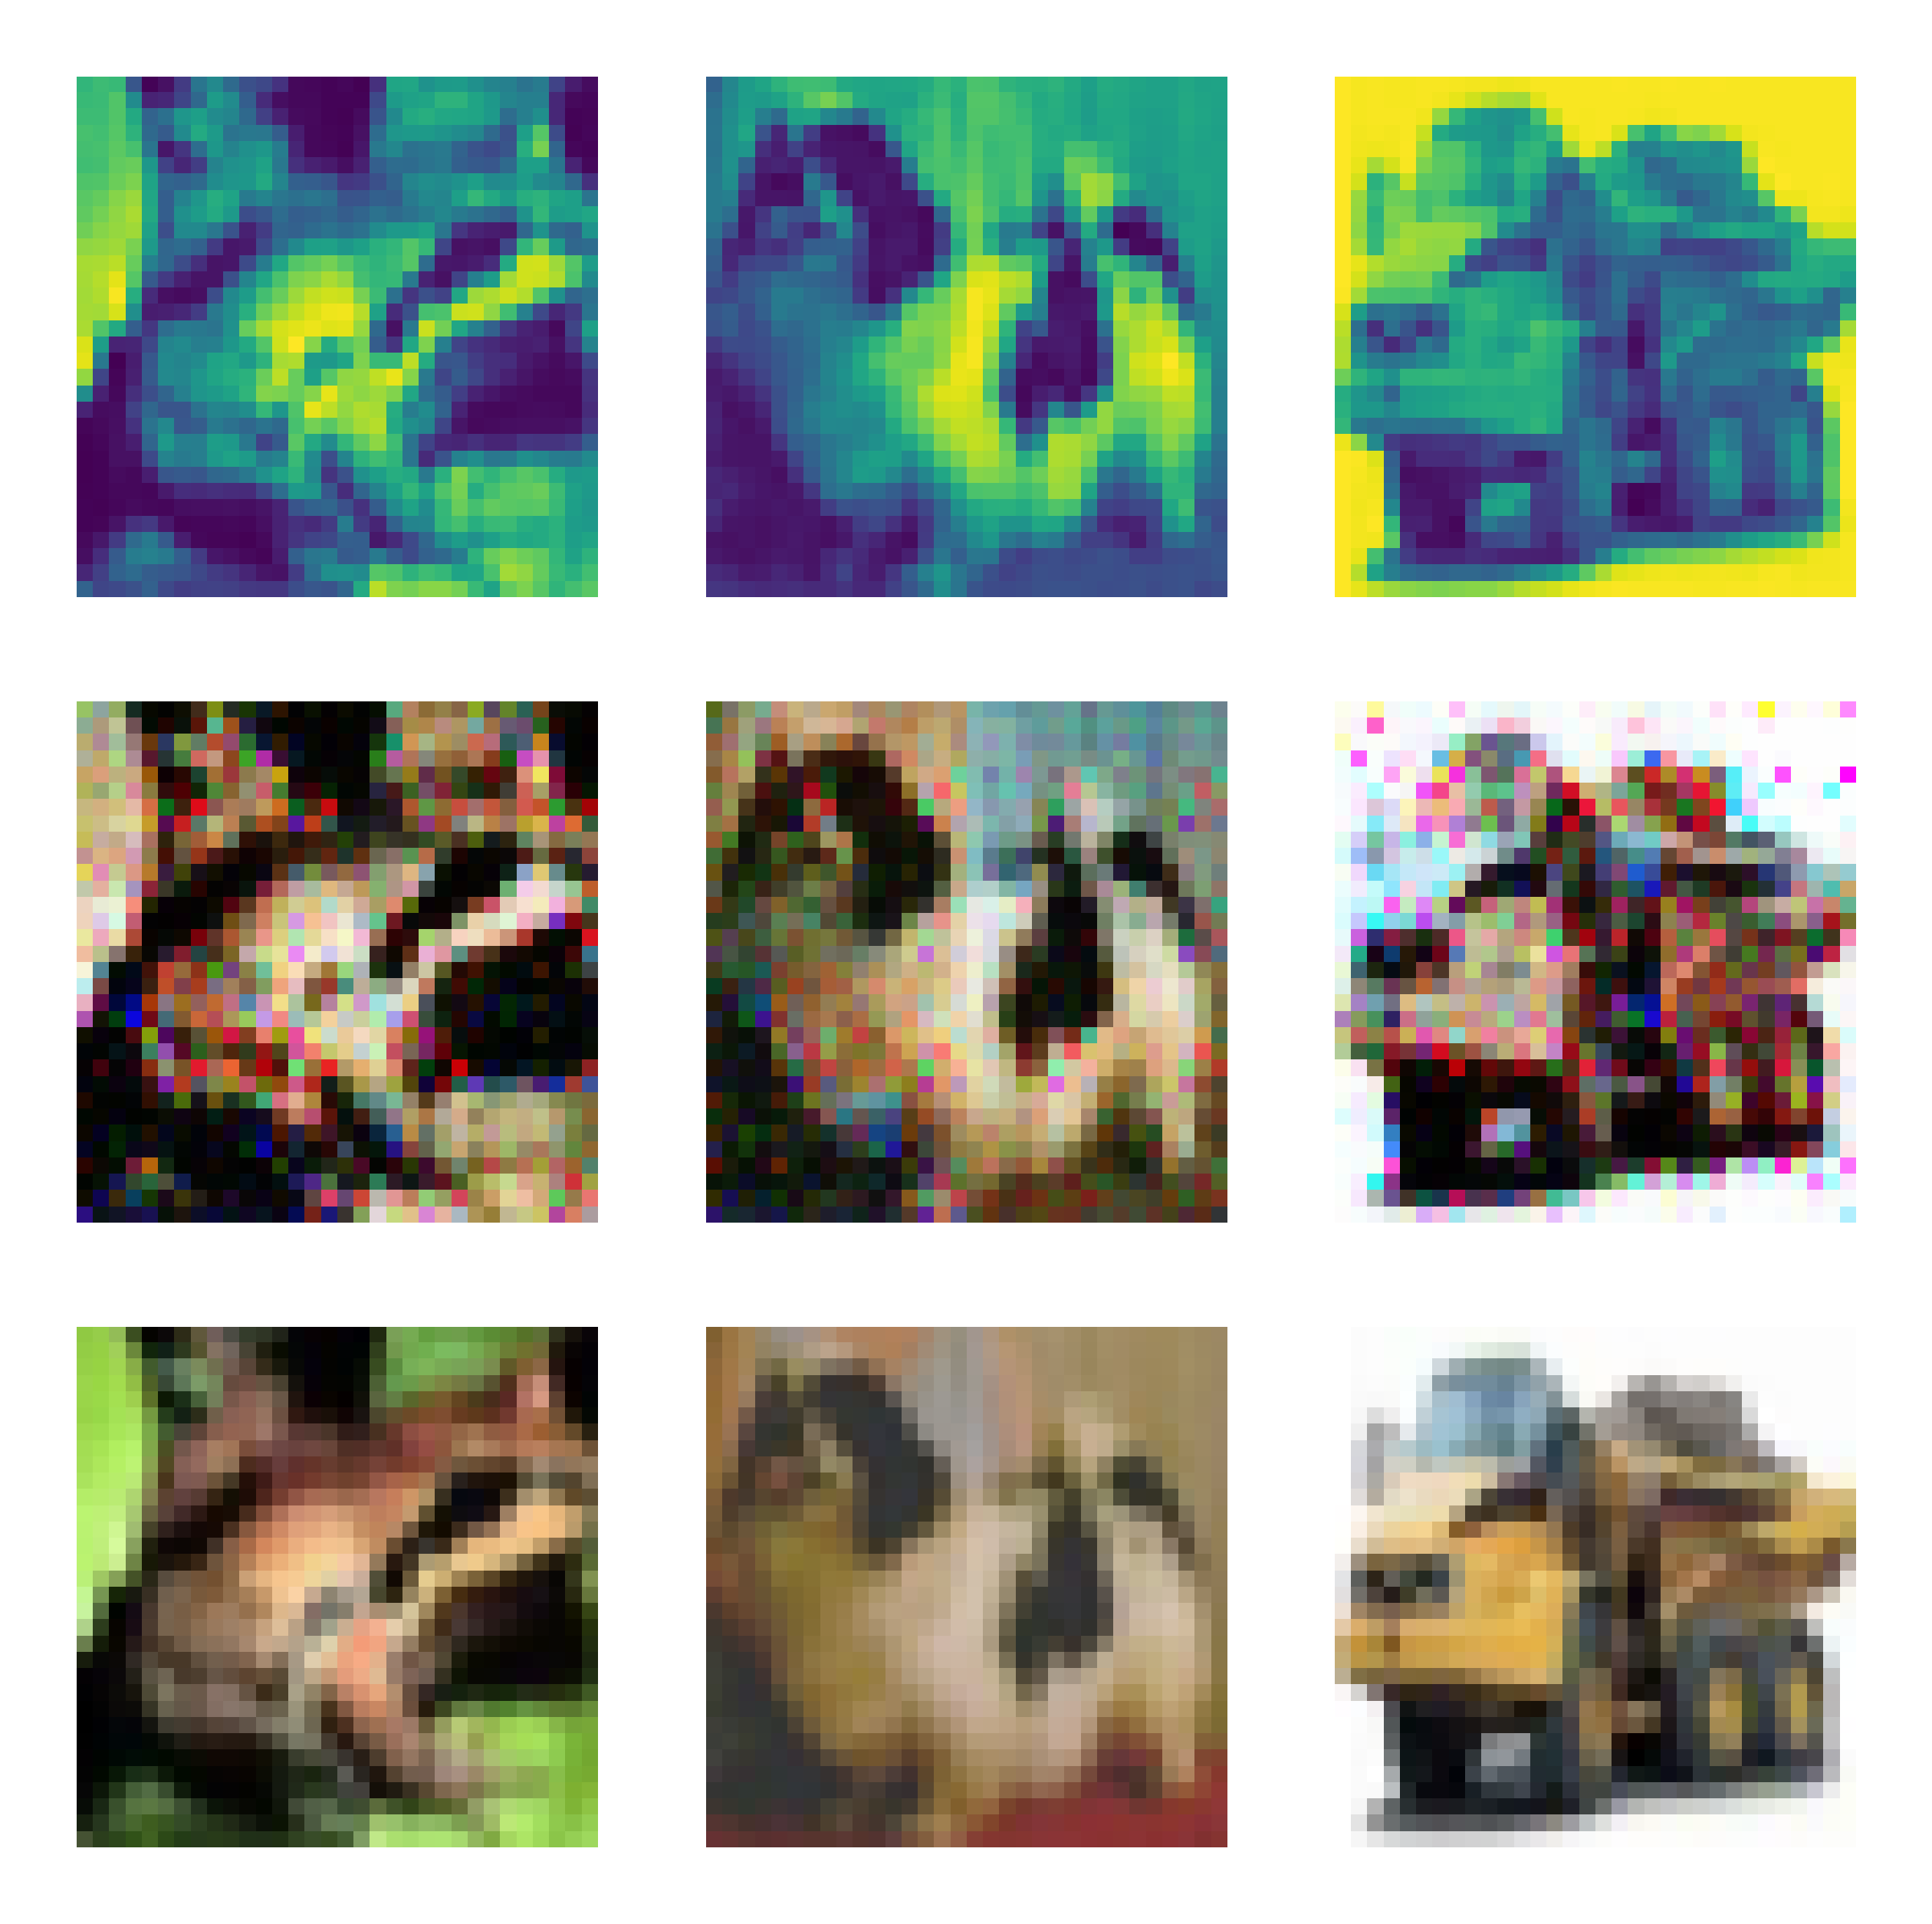

##############
For Epoch:6
Training Discriminator
2/2 [==============================] - 0s 6ms/step
Training Generator
Discriminator Loss:0.16258631546150842
Generator loss:0.6627022761564988
1/1 [==============================] - 0s 18ms/step


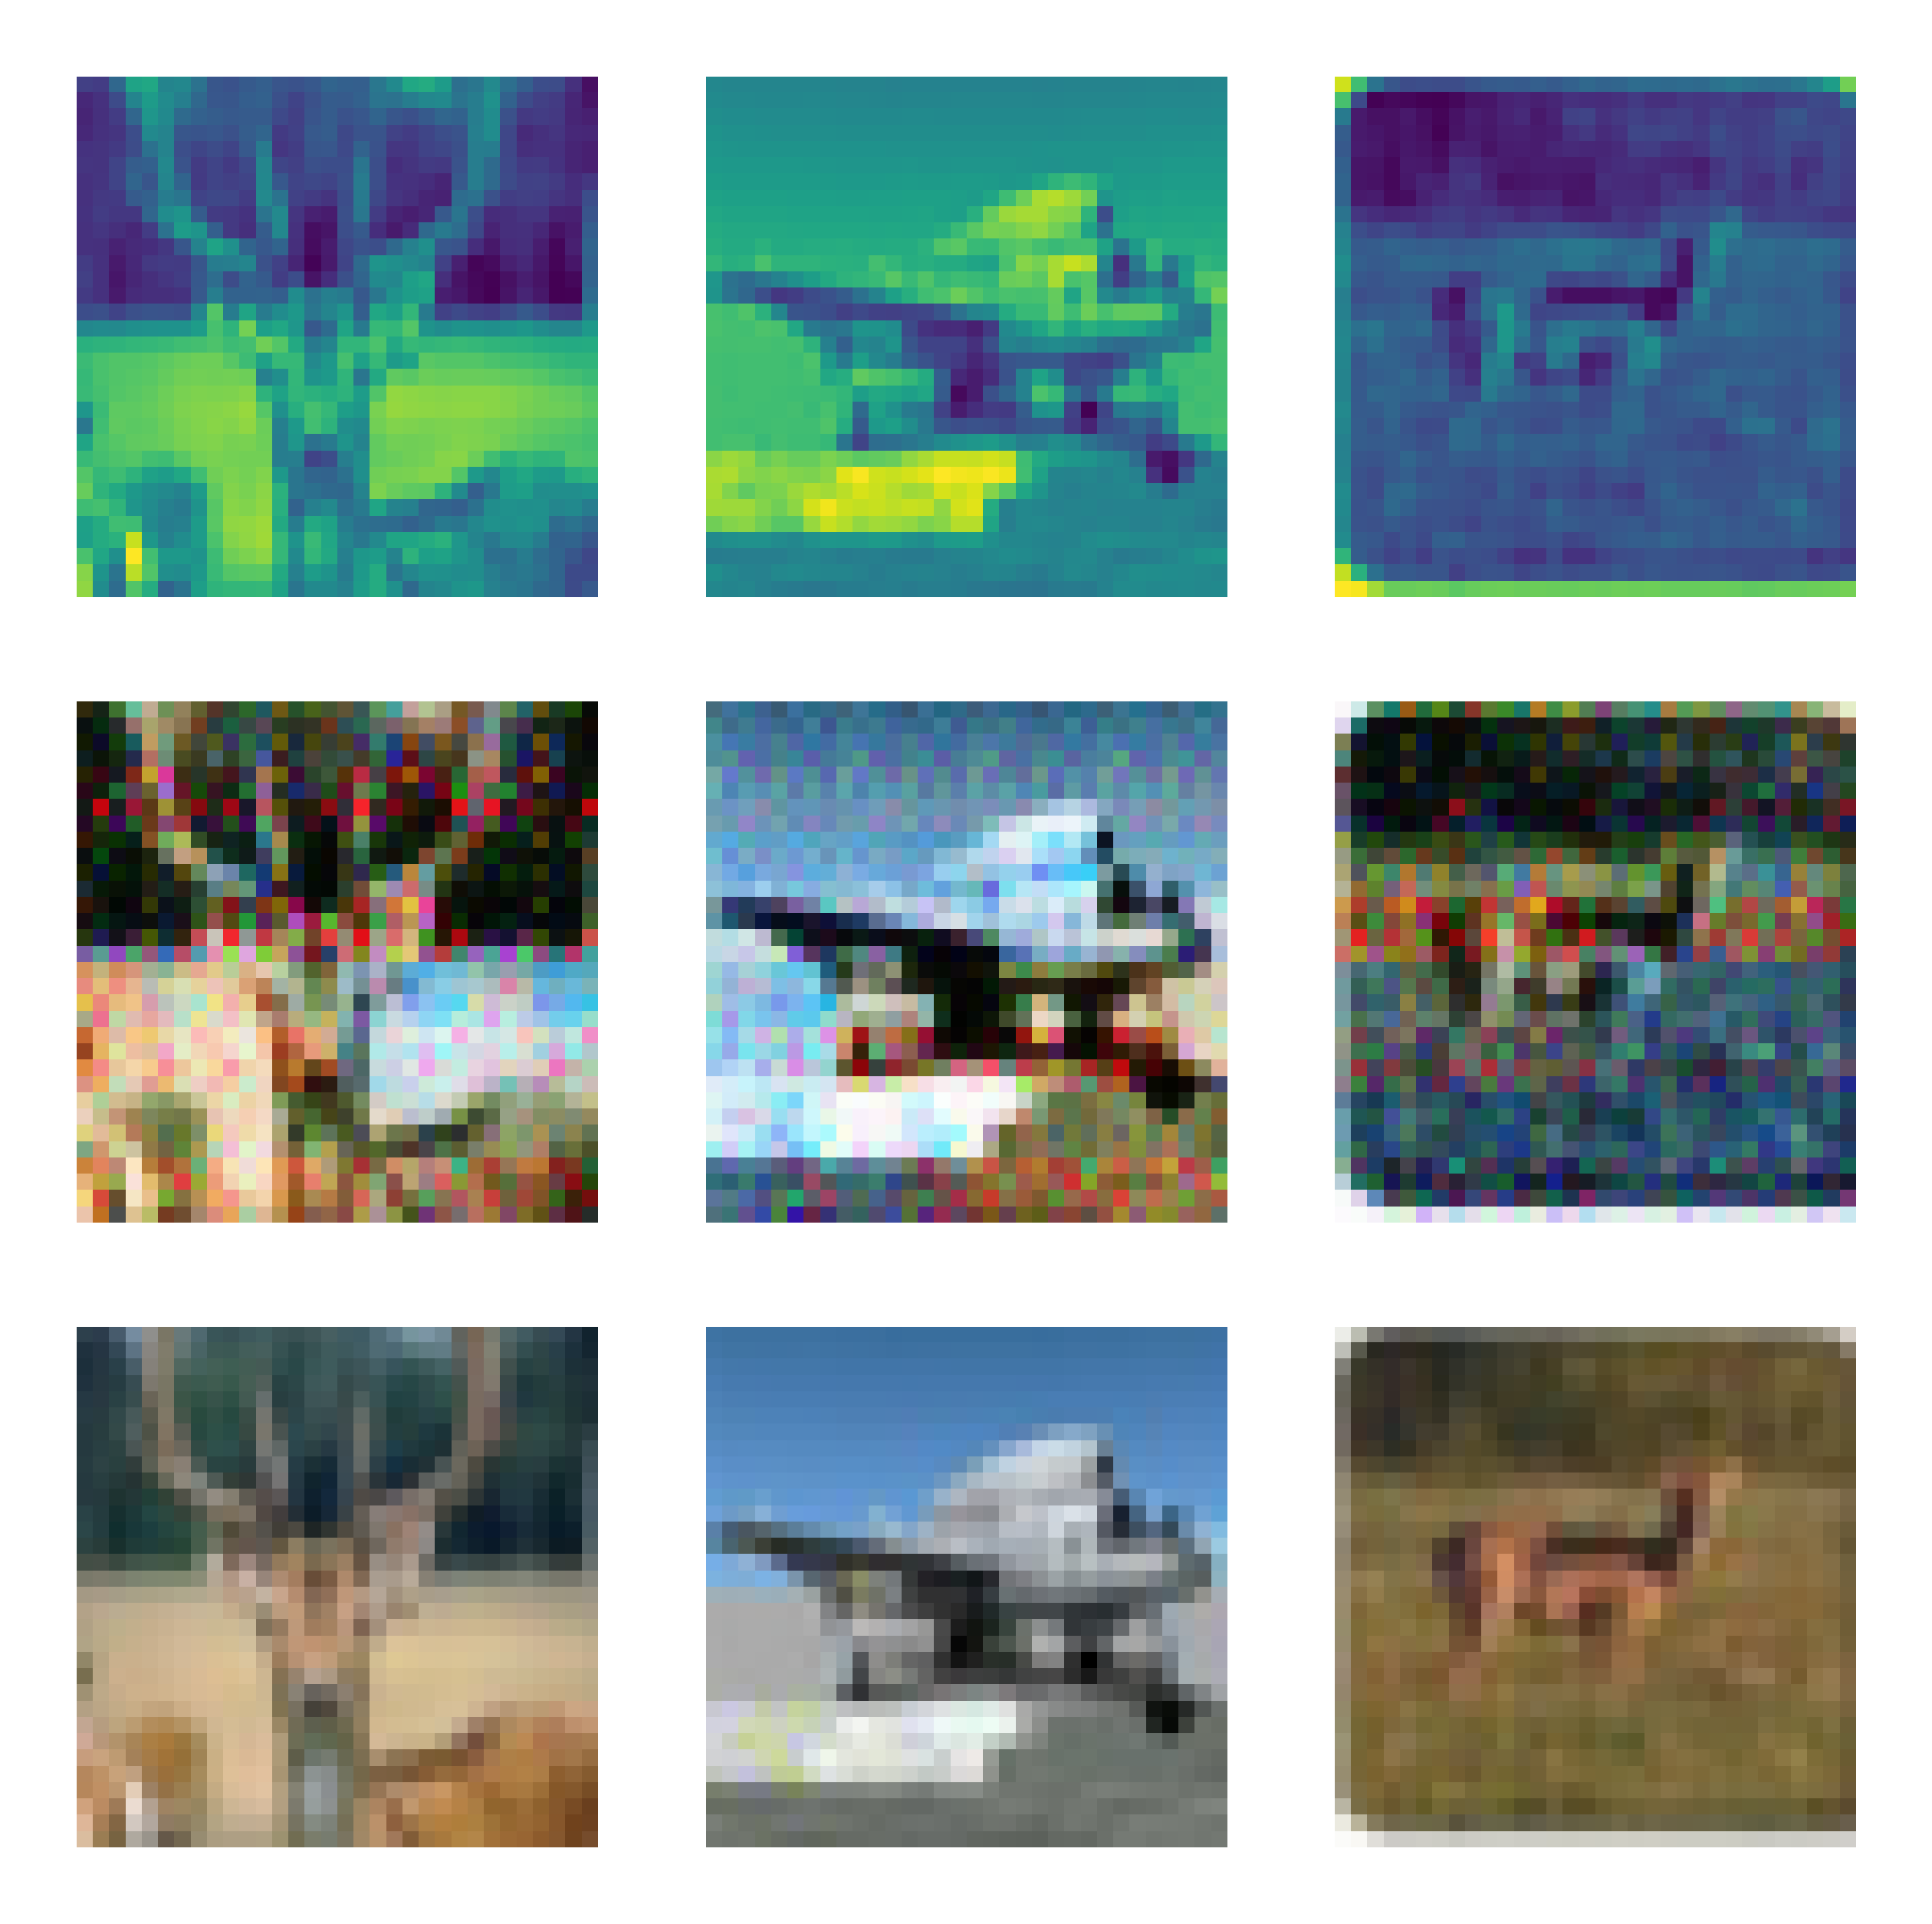

##############
For Epoch:7
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16259785202678081
Generator loss:0.6615030098165202
1/1 [==============================] - 0s 17ms/step


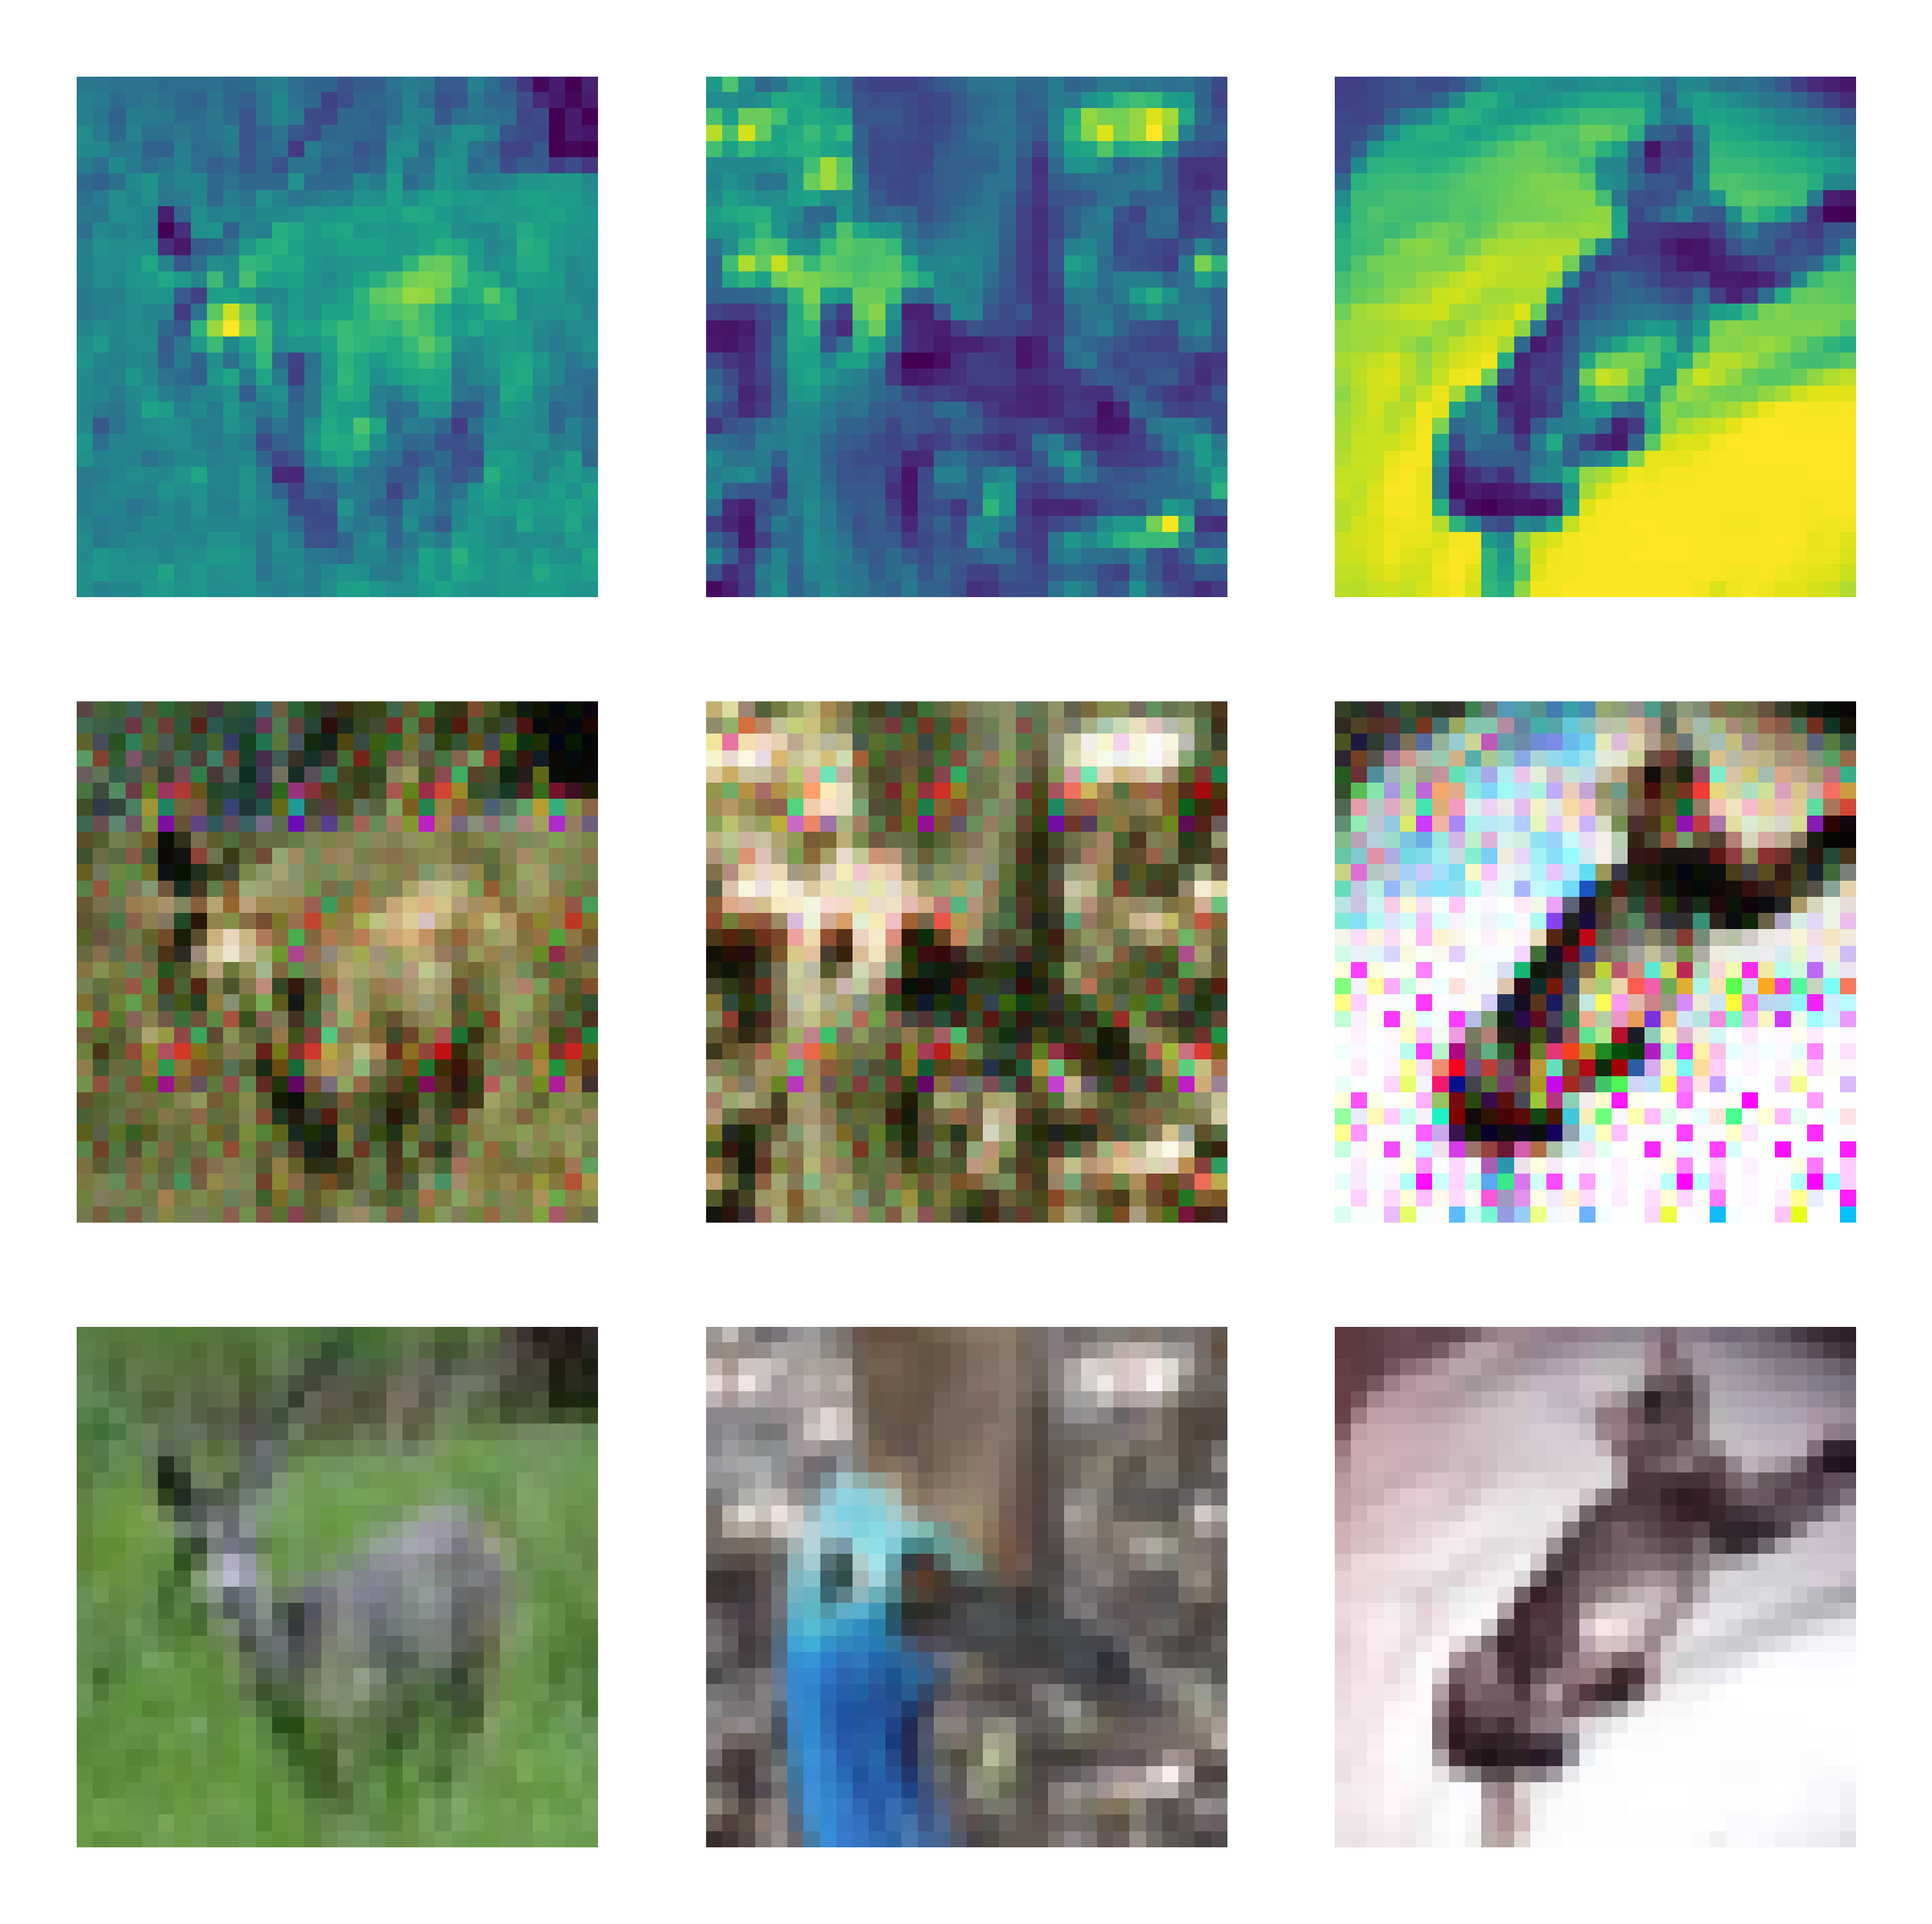

##############
For Epoch:8
Training Discriminator
2/2 [==============================] - 0s 7ms/step
Training Generator
Discriminator Loss:0.16259561654055166
Generator loss:0.6626295989904648
1/1 [==============================] - 0s 19ms/step


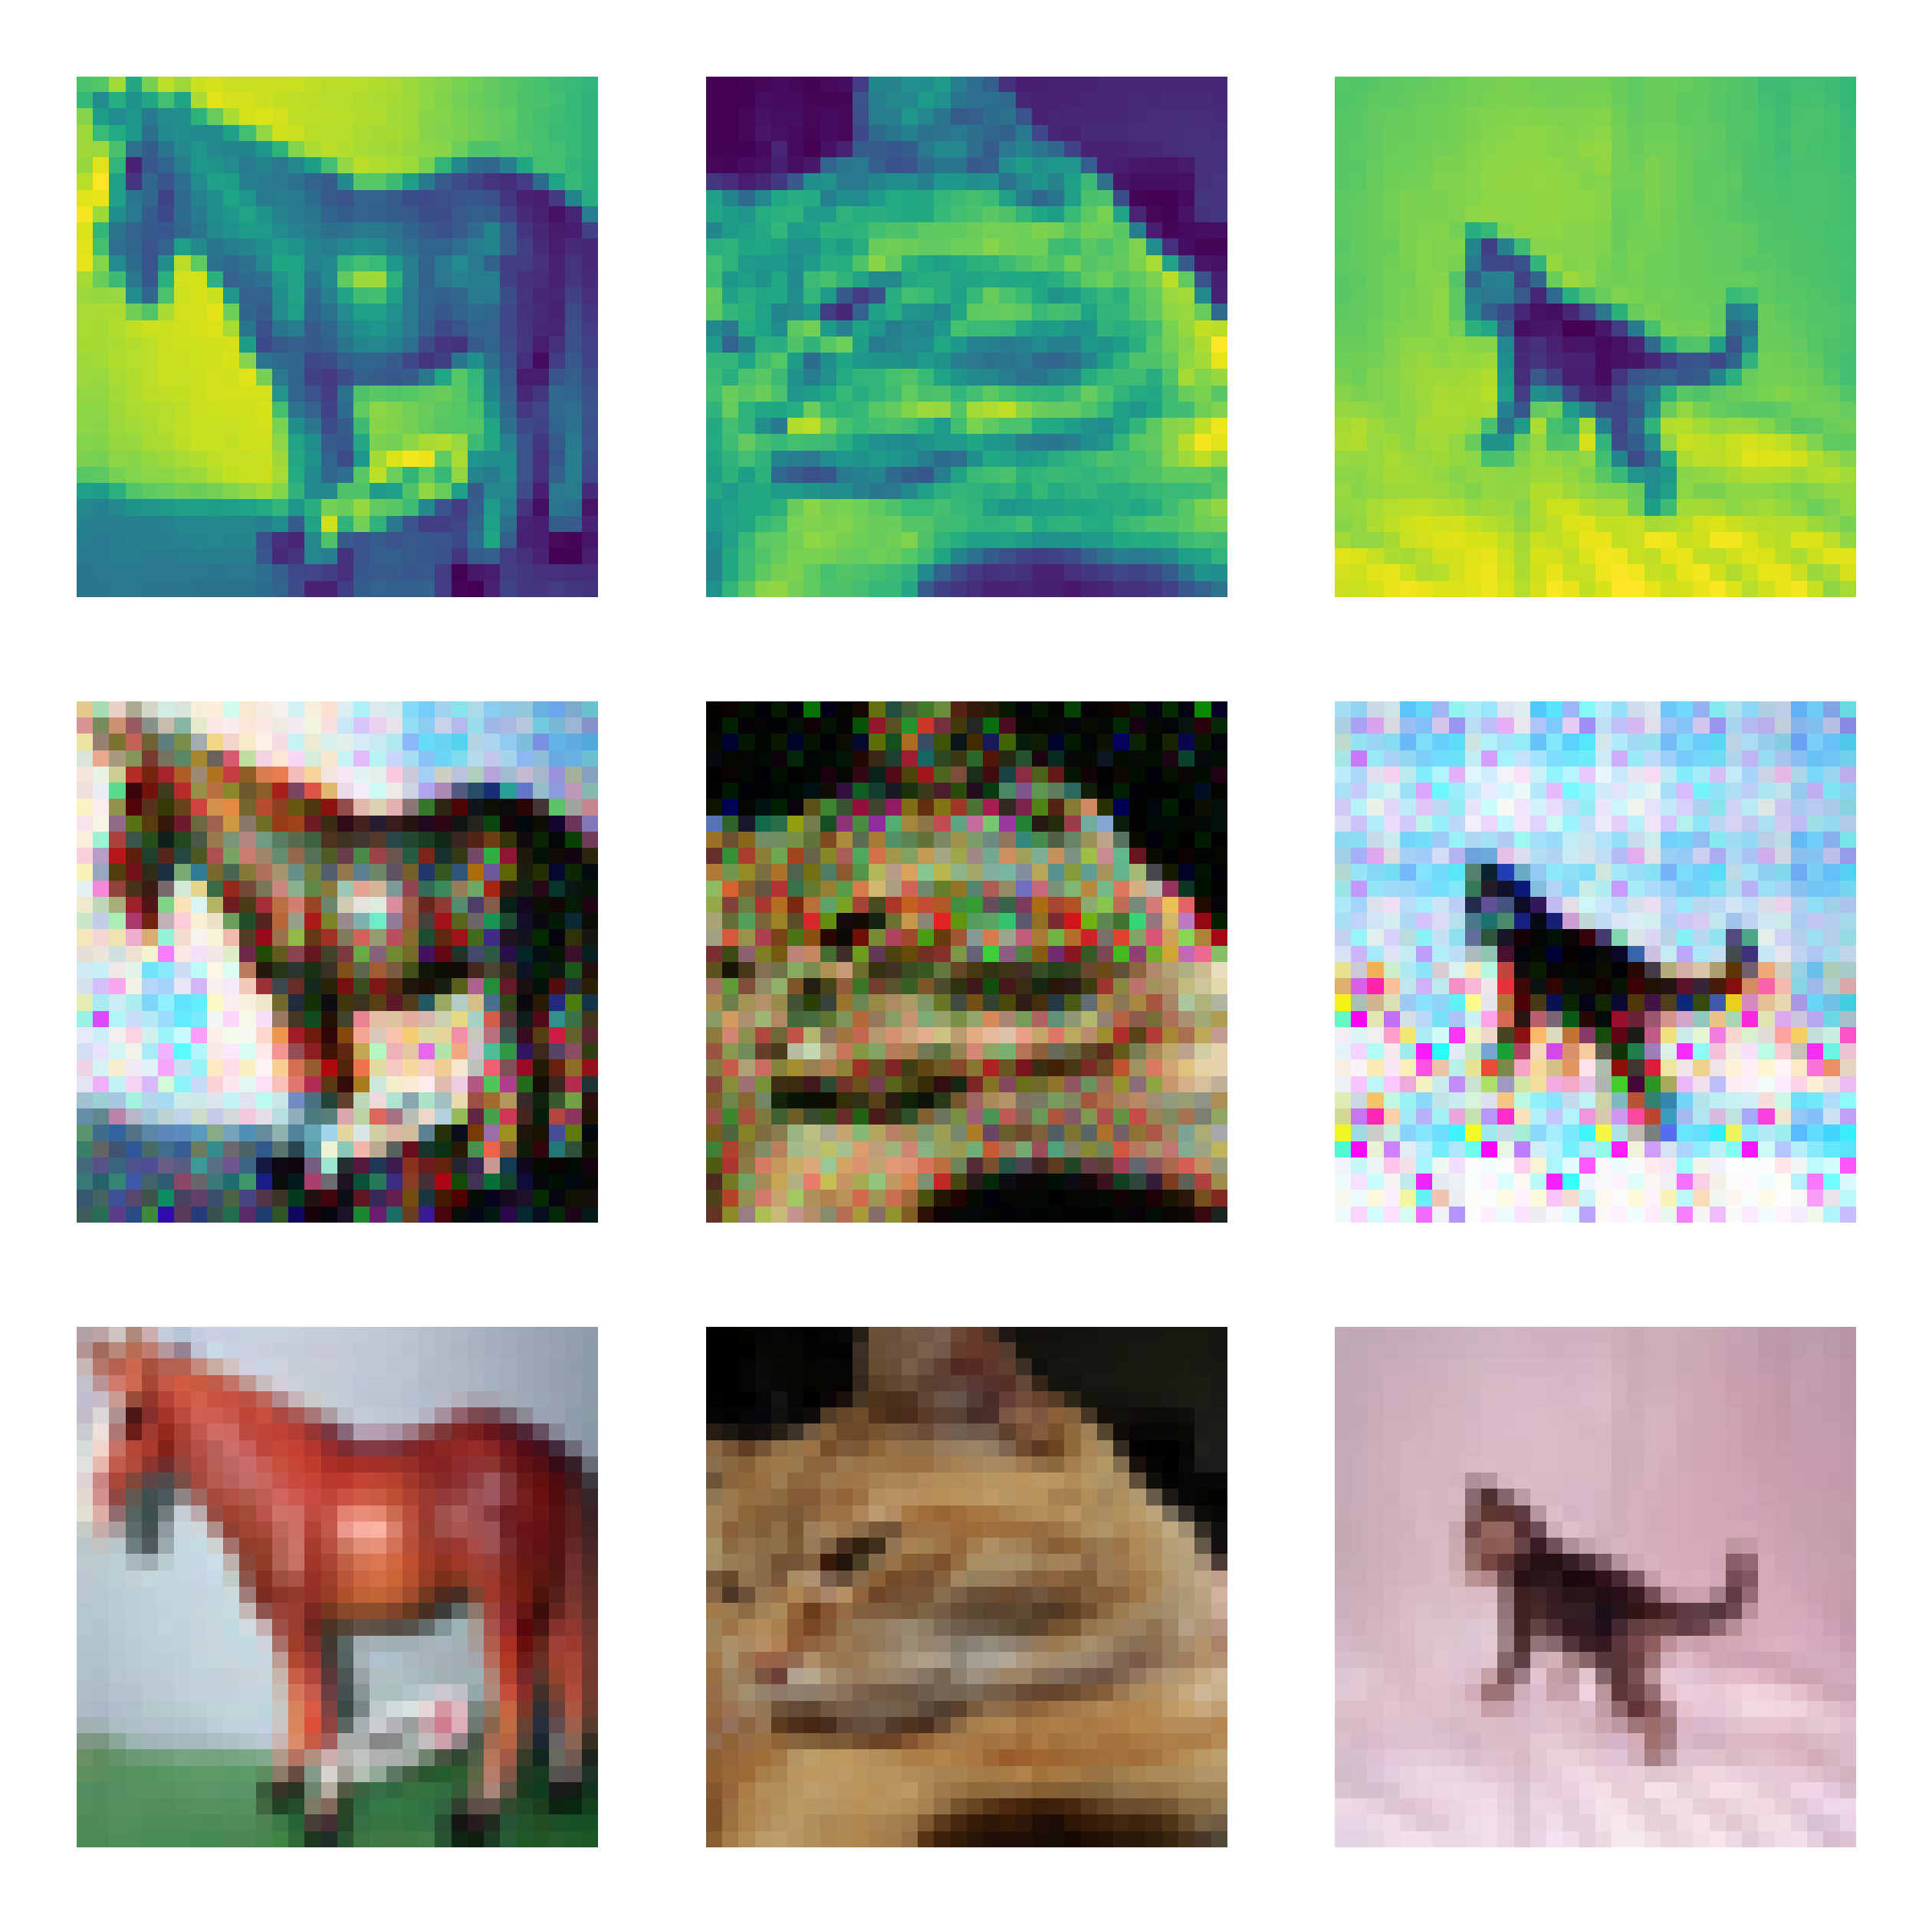

##############
For Epoch:9
Training Discriminator
2/2 [==============================] - 0s 6ms/step
Training Generator
Discriminator Loss:0.16258391129521377
Generator loss:0.6592920050661788
1/1 [==============================] - 0s 19ms/step


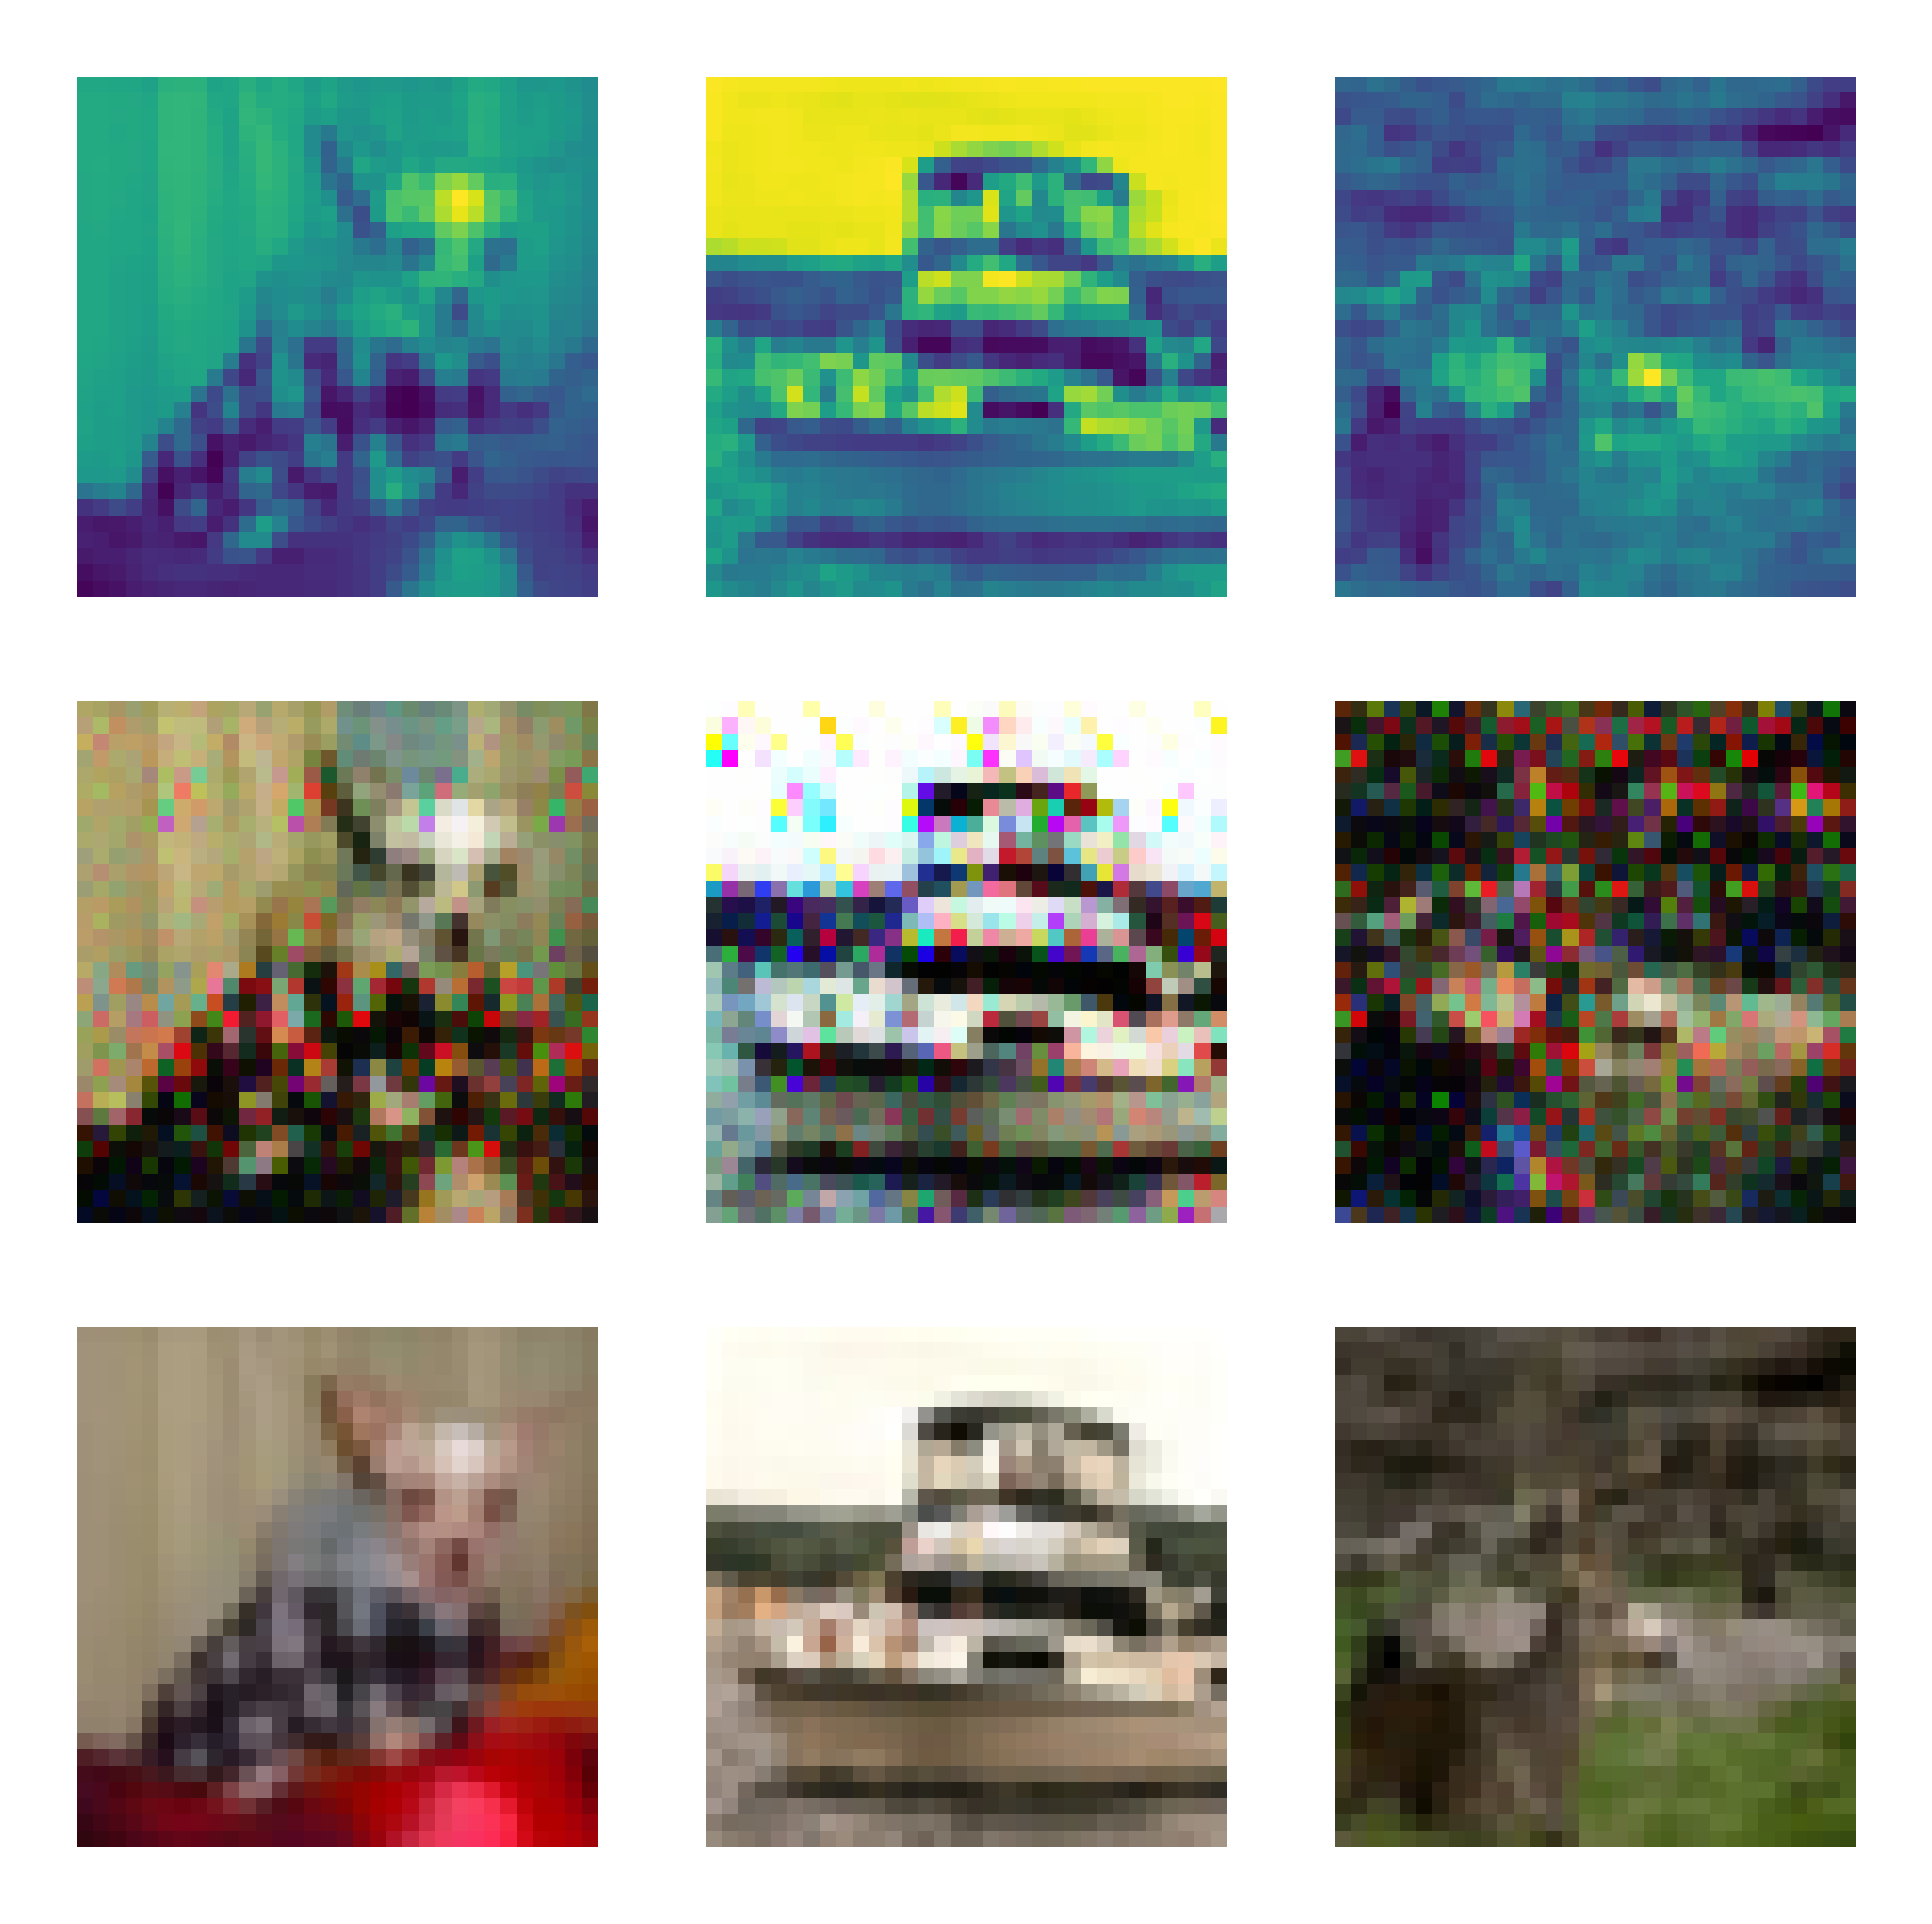

##############
For Epoch:10
Training Discriminator
2/2 [==============================] - 0s 10ms/step
Training Generator
Discriminator Loss:0.1625863798827365
Generator loss:0.6610813604460822
1/1 [==============================] - 0s 18ms/step


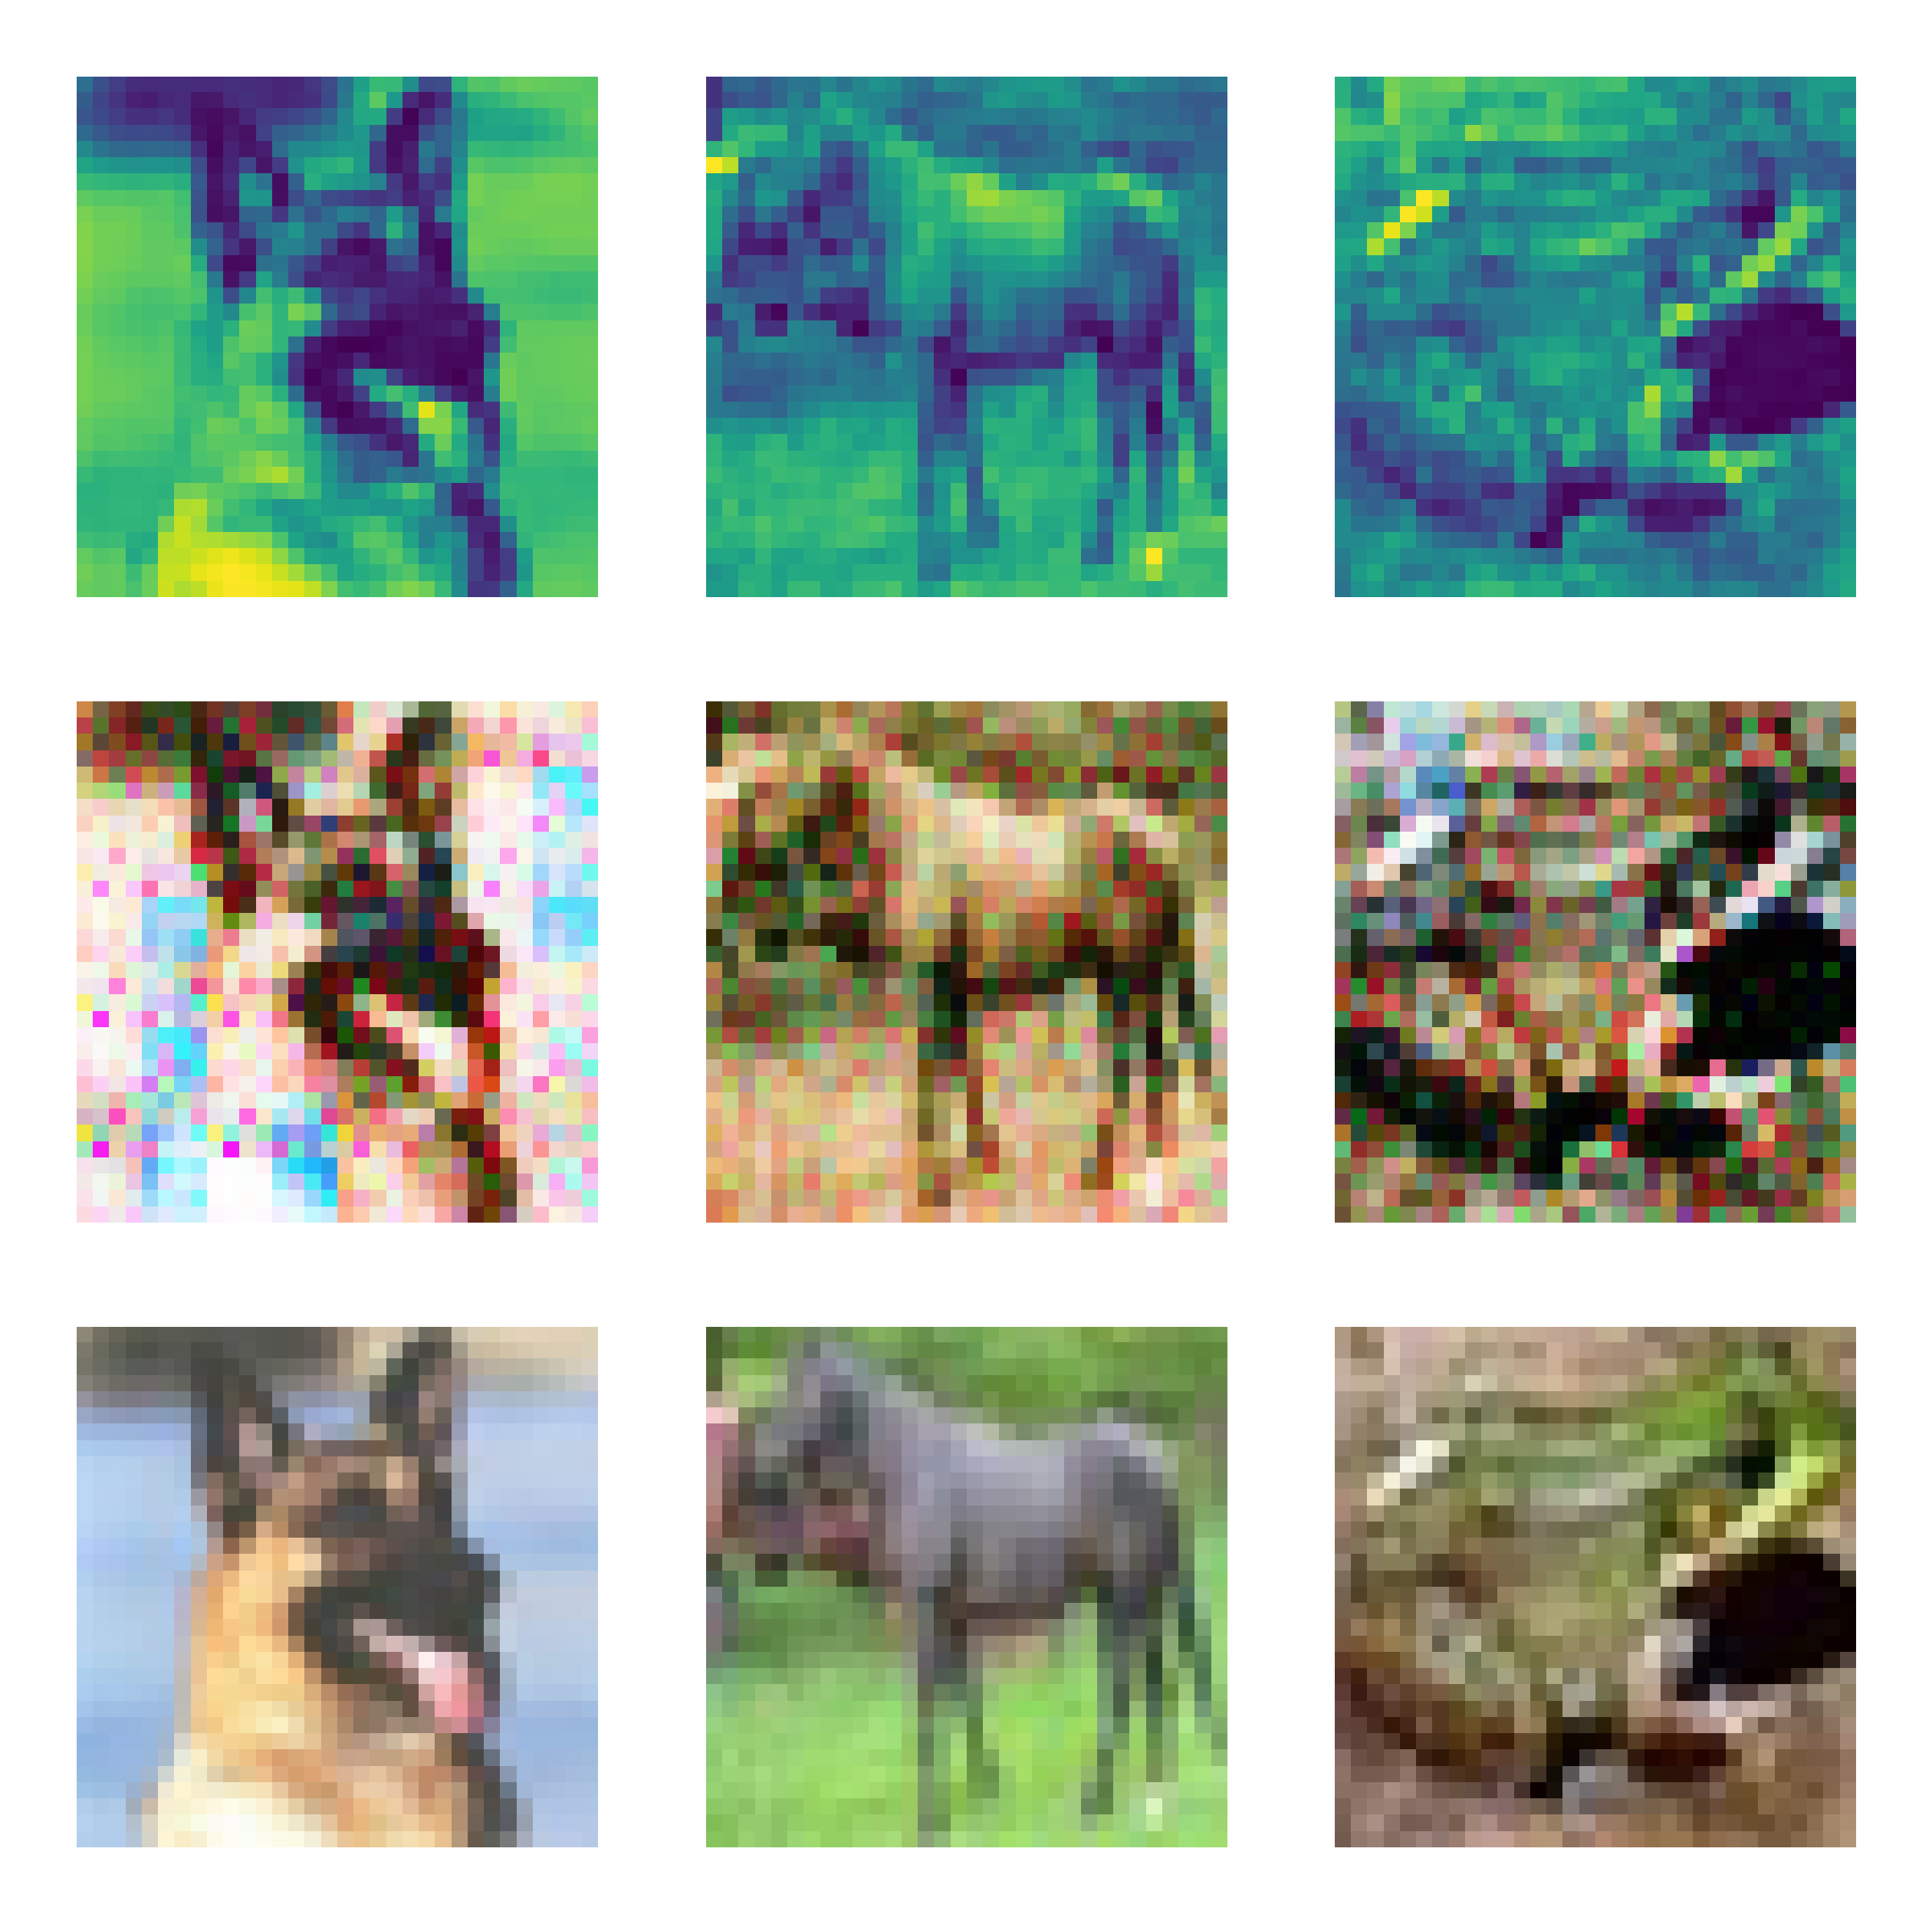

##############
For Epoch:11
Training Discriminator
2/2 [==============================] - 0s 8ms/step
Training Generator
Discriminator Loss:0.16258460803014102
Generator loss:0.6599150027474786
1/1 [==============================] - 0s 19ms/step


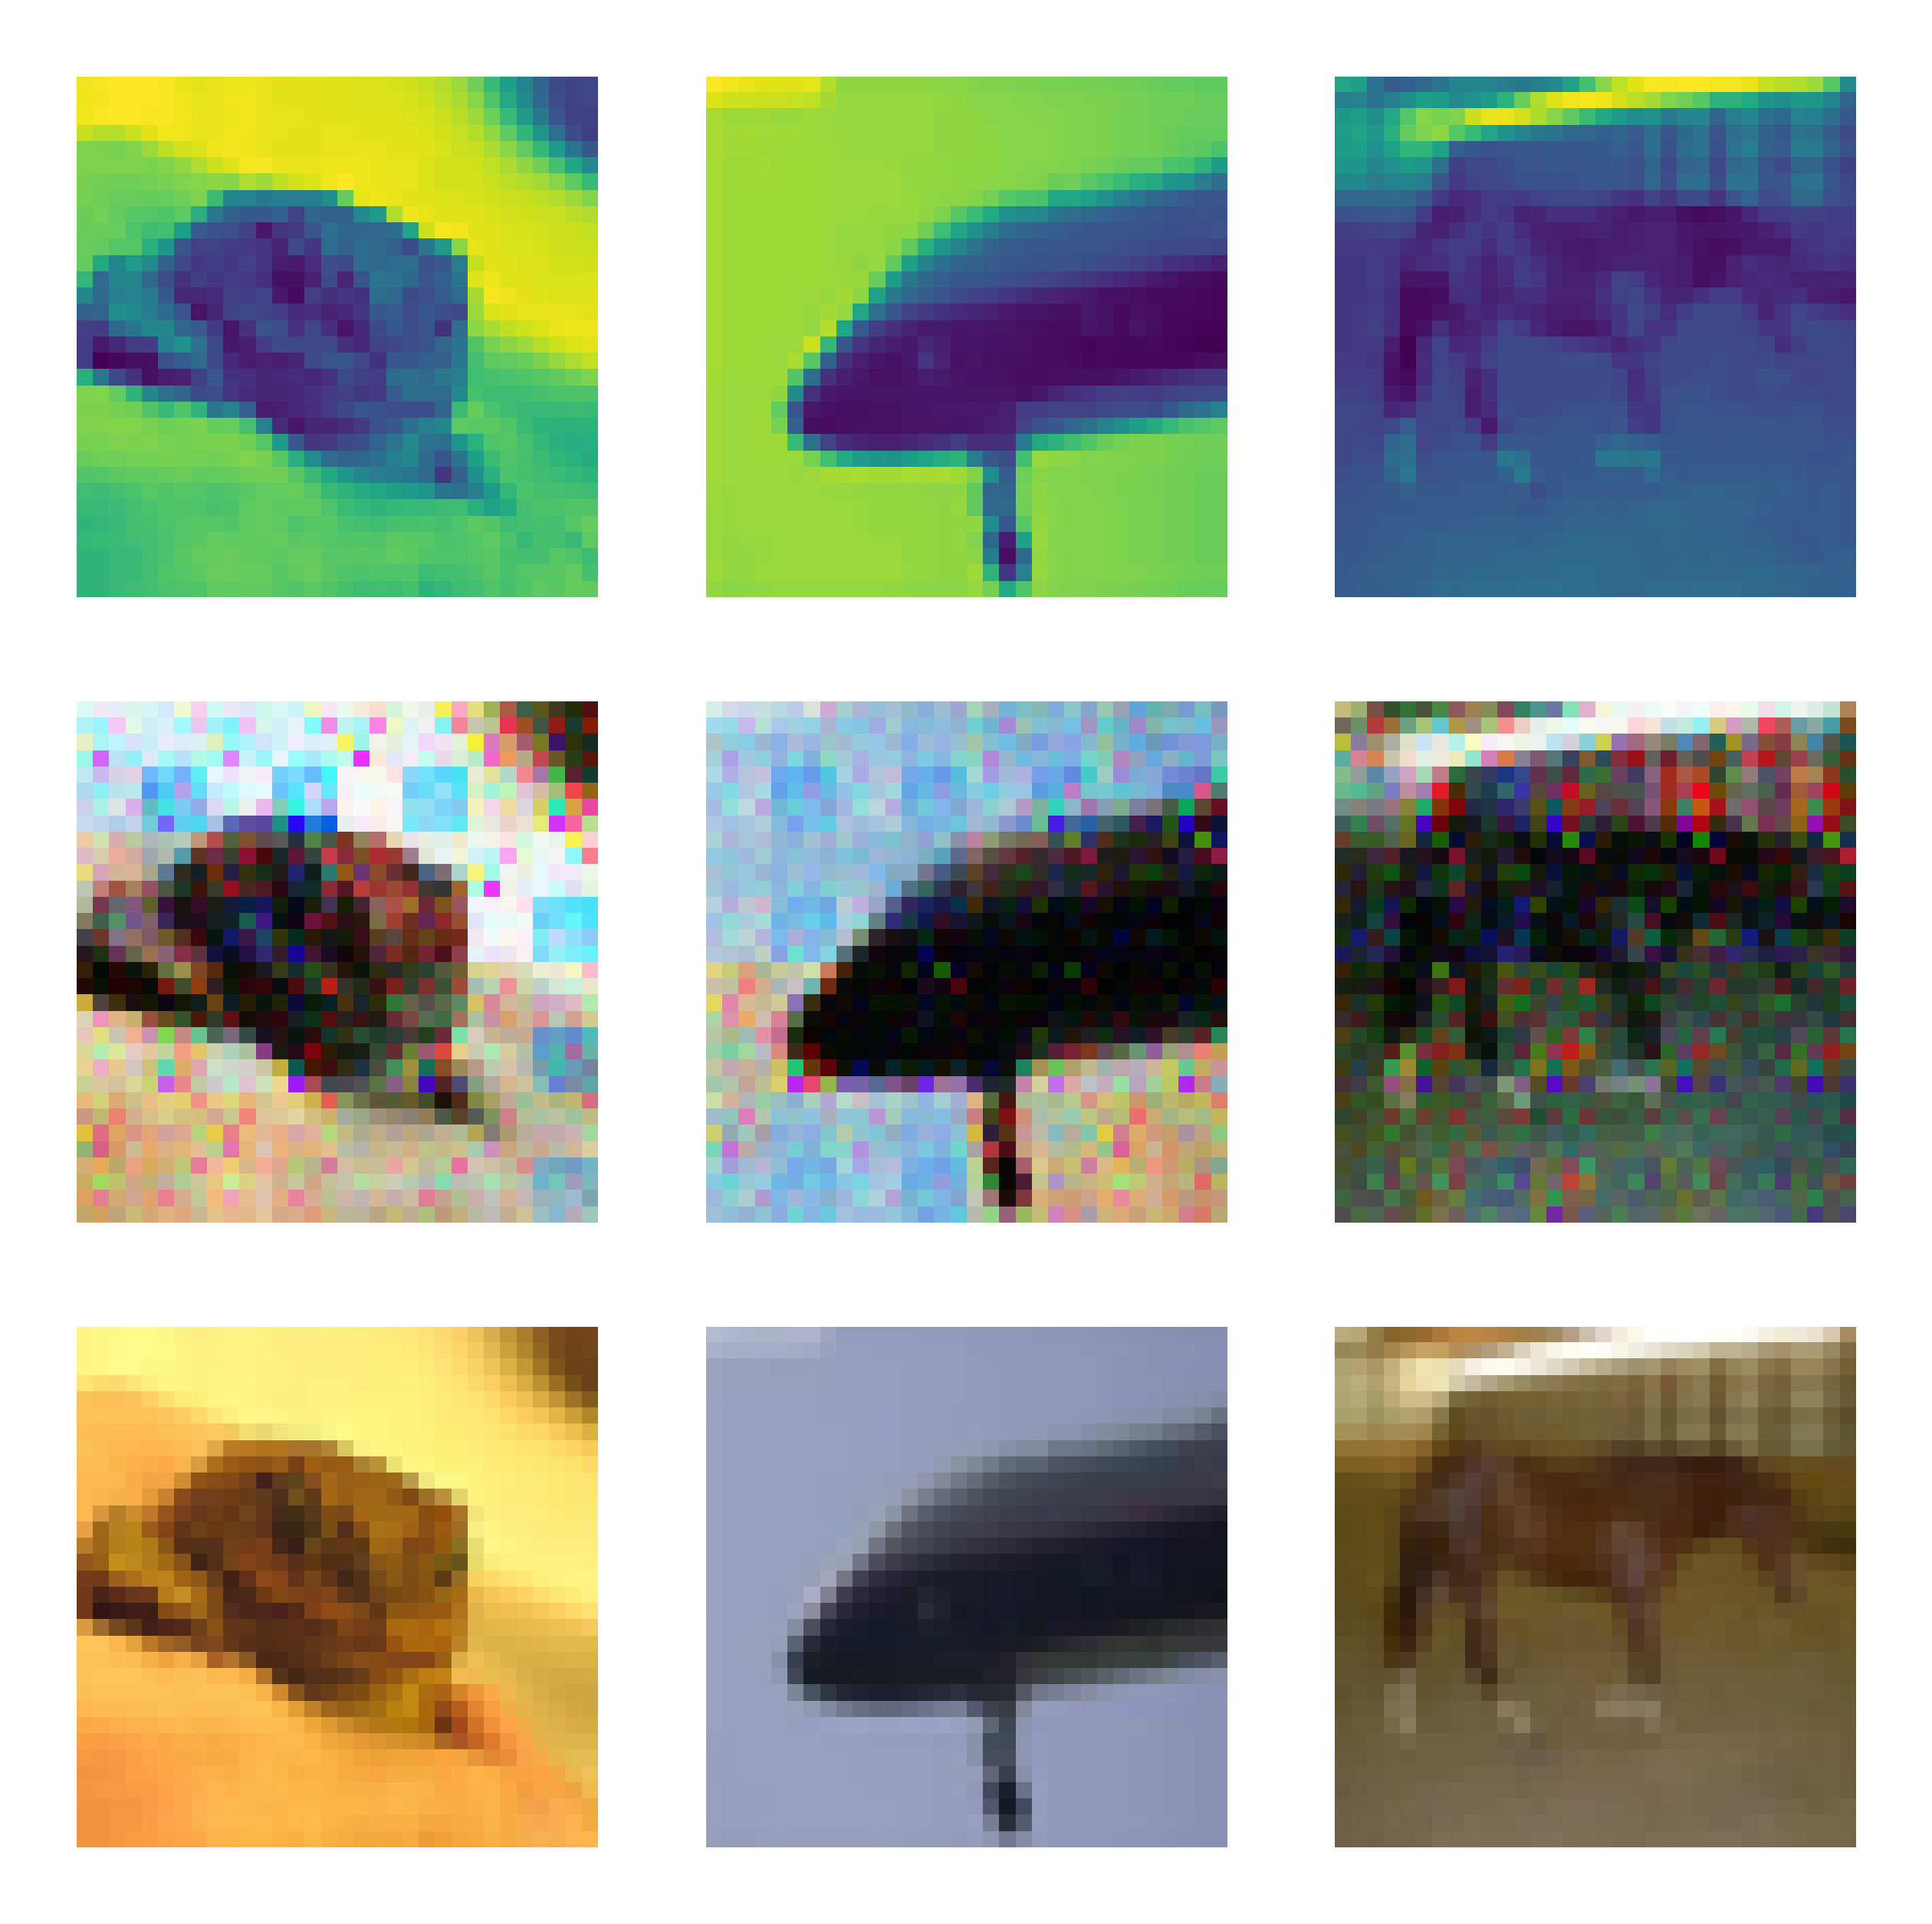

##############
For Epoch:12
Training Discriminator
2/2 [==============================] - 0s 5ms/step
Training Generator
Discriminator Loss:0.16259369210545643
Generator loss:0.660199412678042
1/1 [==============================] - 0s 18ms/step


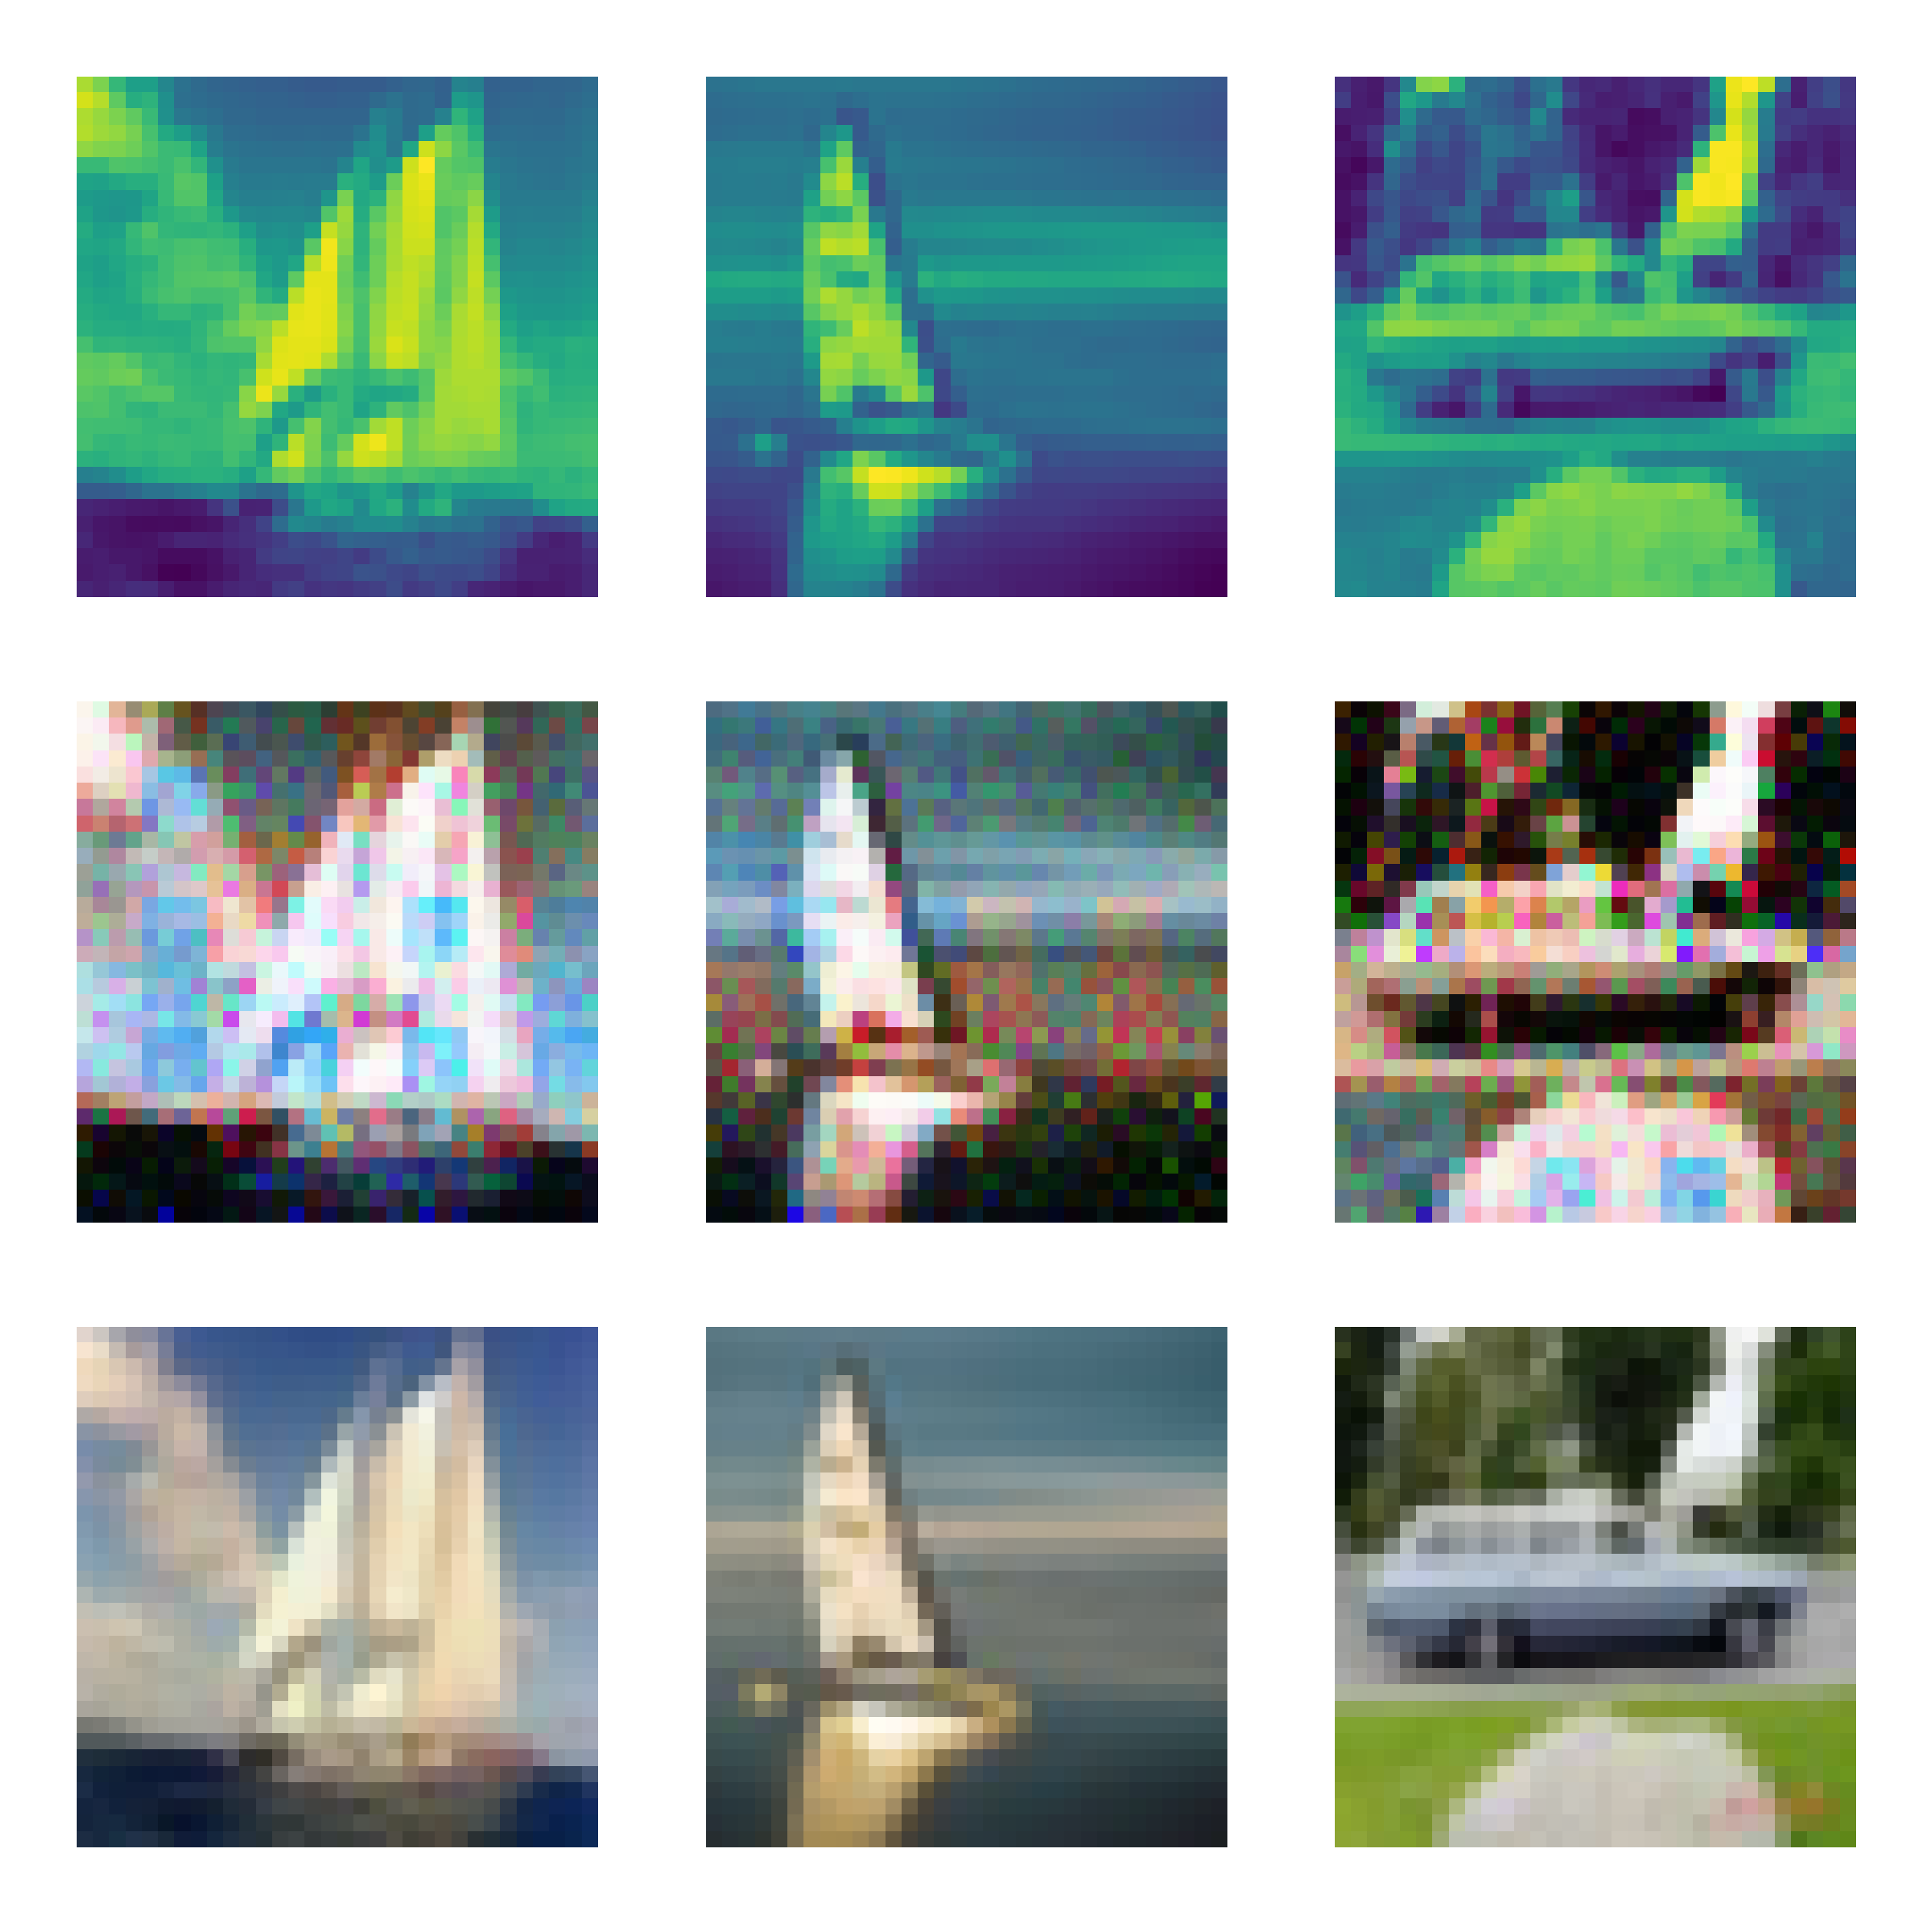

##############
For Epoch:13
Training Discriminator
2/2 [==============================] - 0s 6ms/step
Training Generator
Discriminator Loss:0.16257977053106665
Generator loss:0.6591143935409367
1/1 [==============================] - 0s 18ms/step


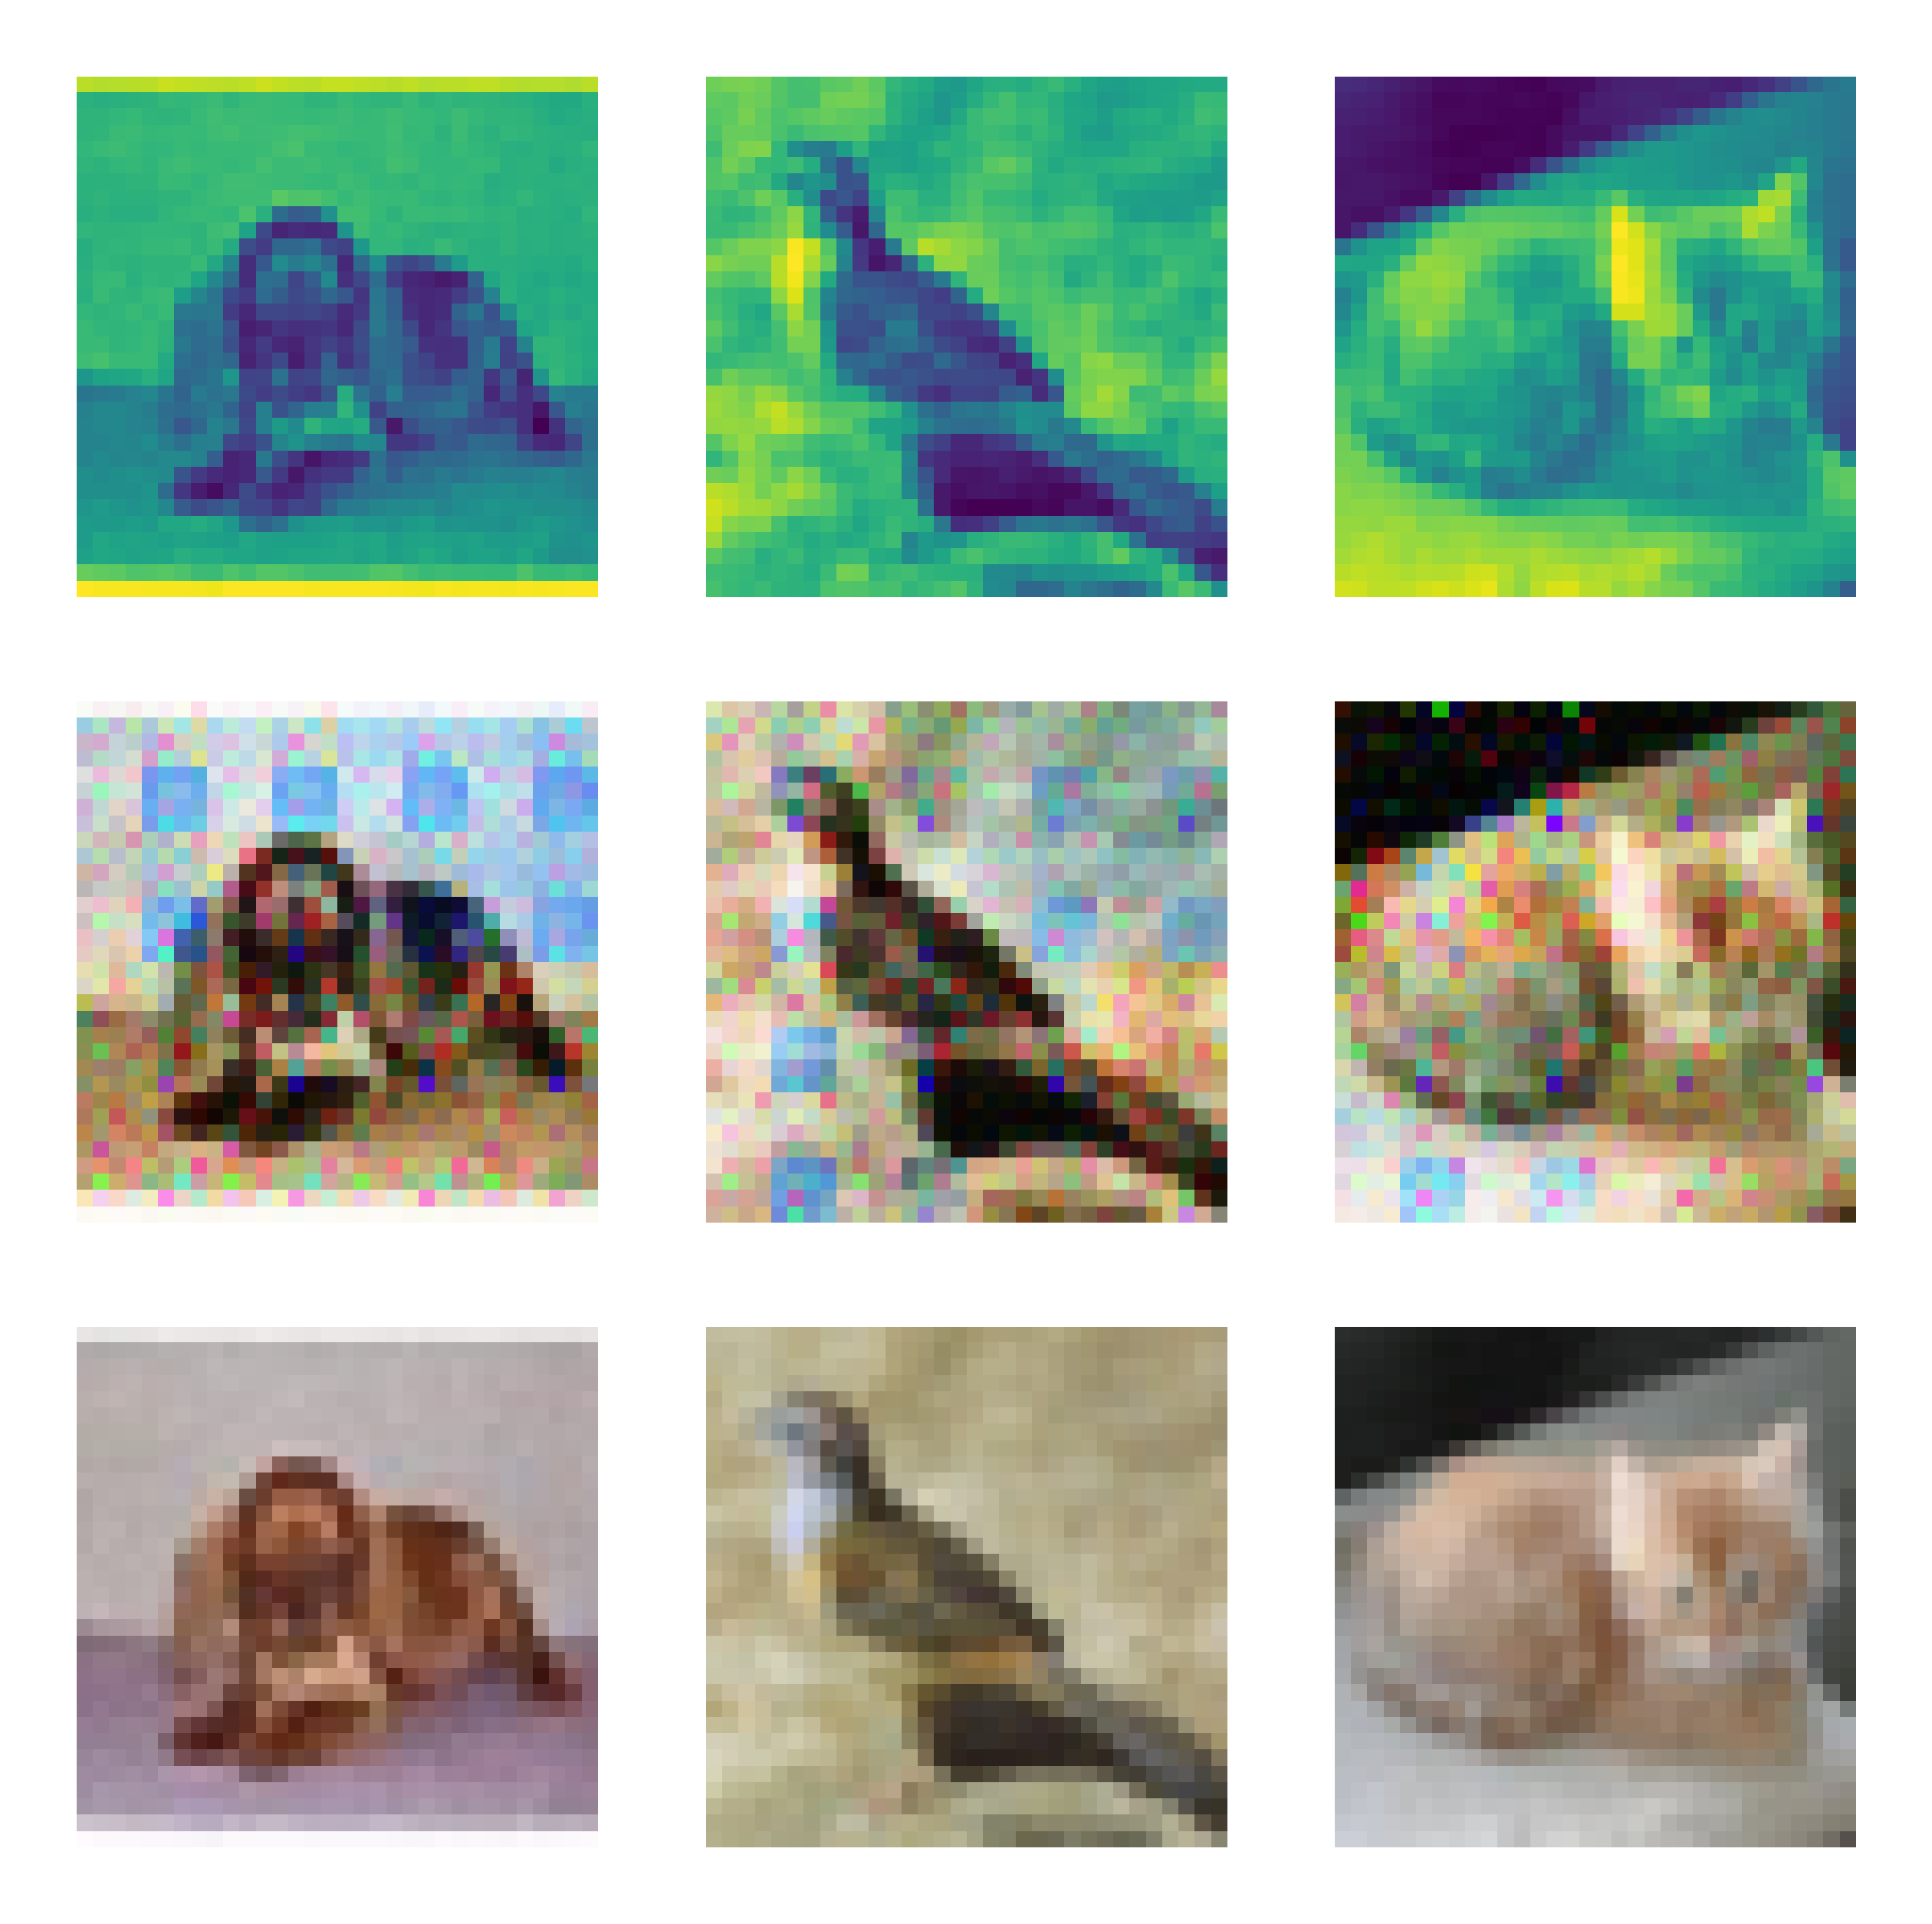

##############
For Epoch:14
Training Discriminator
2/2 [==============================] - 0s 5ms/step
Training Generator
Discriminator Loss:0.16258594130279866
Generator loss:0.6602863105189087
1/1 [==============================] - 0s 19ms/step


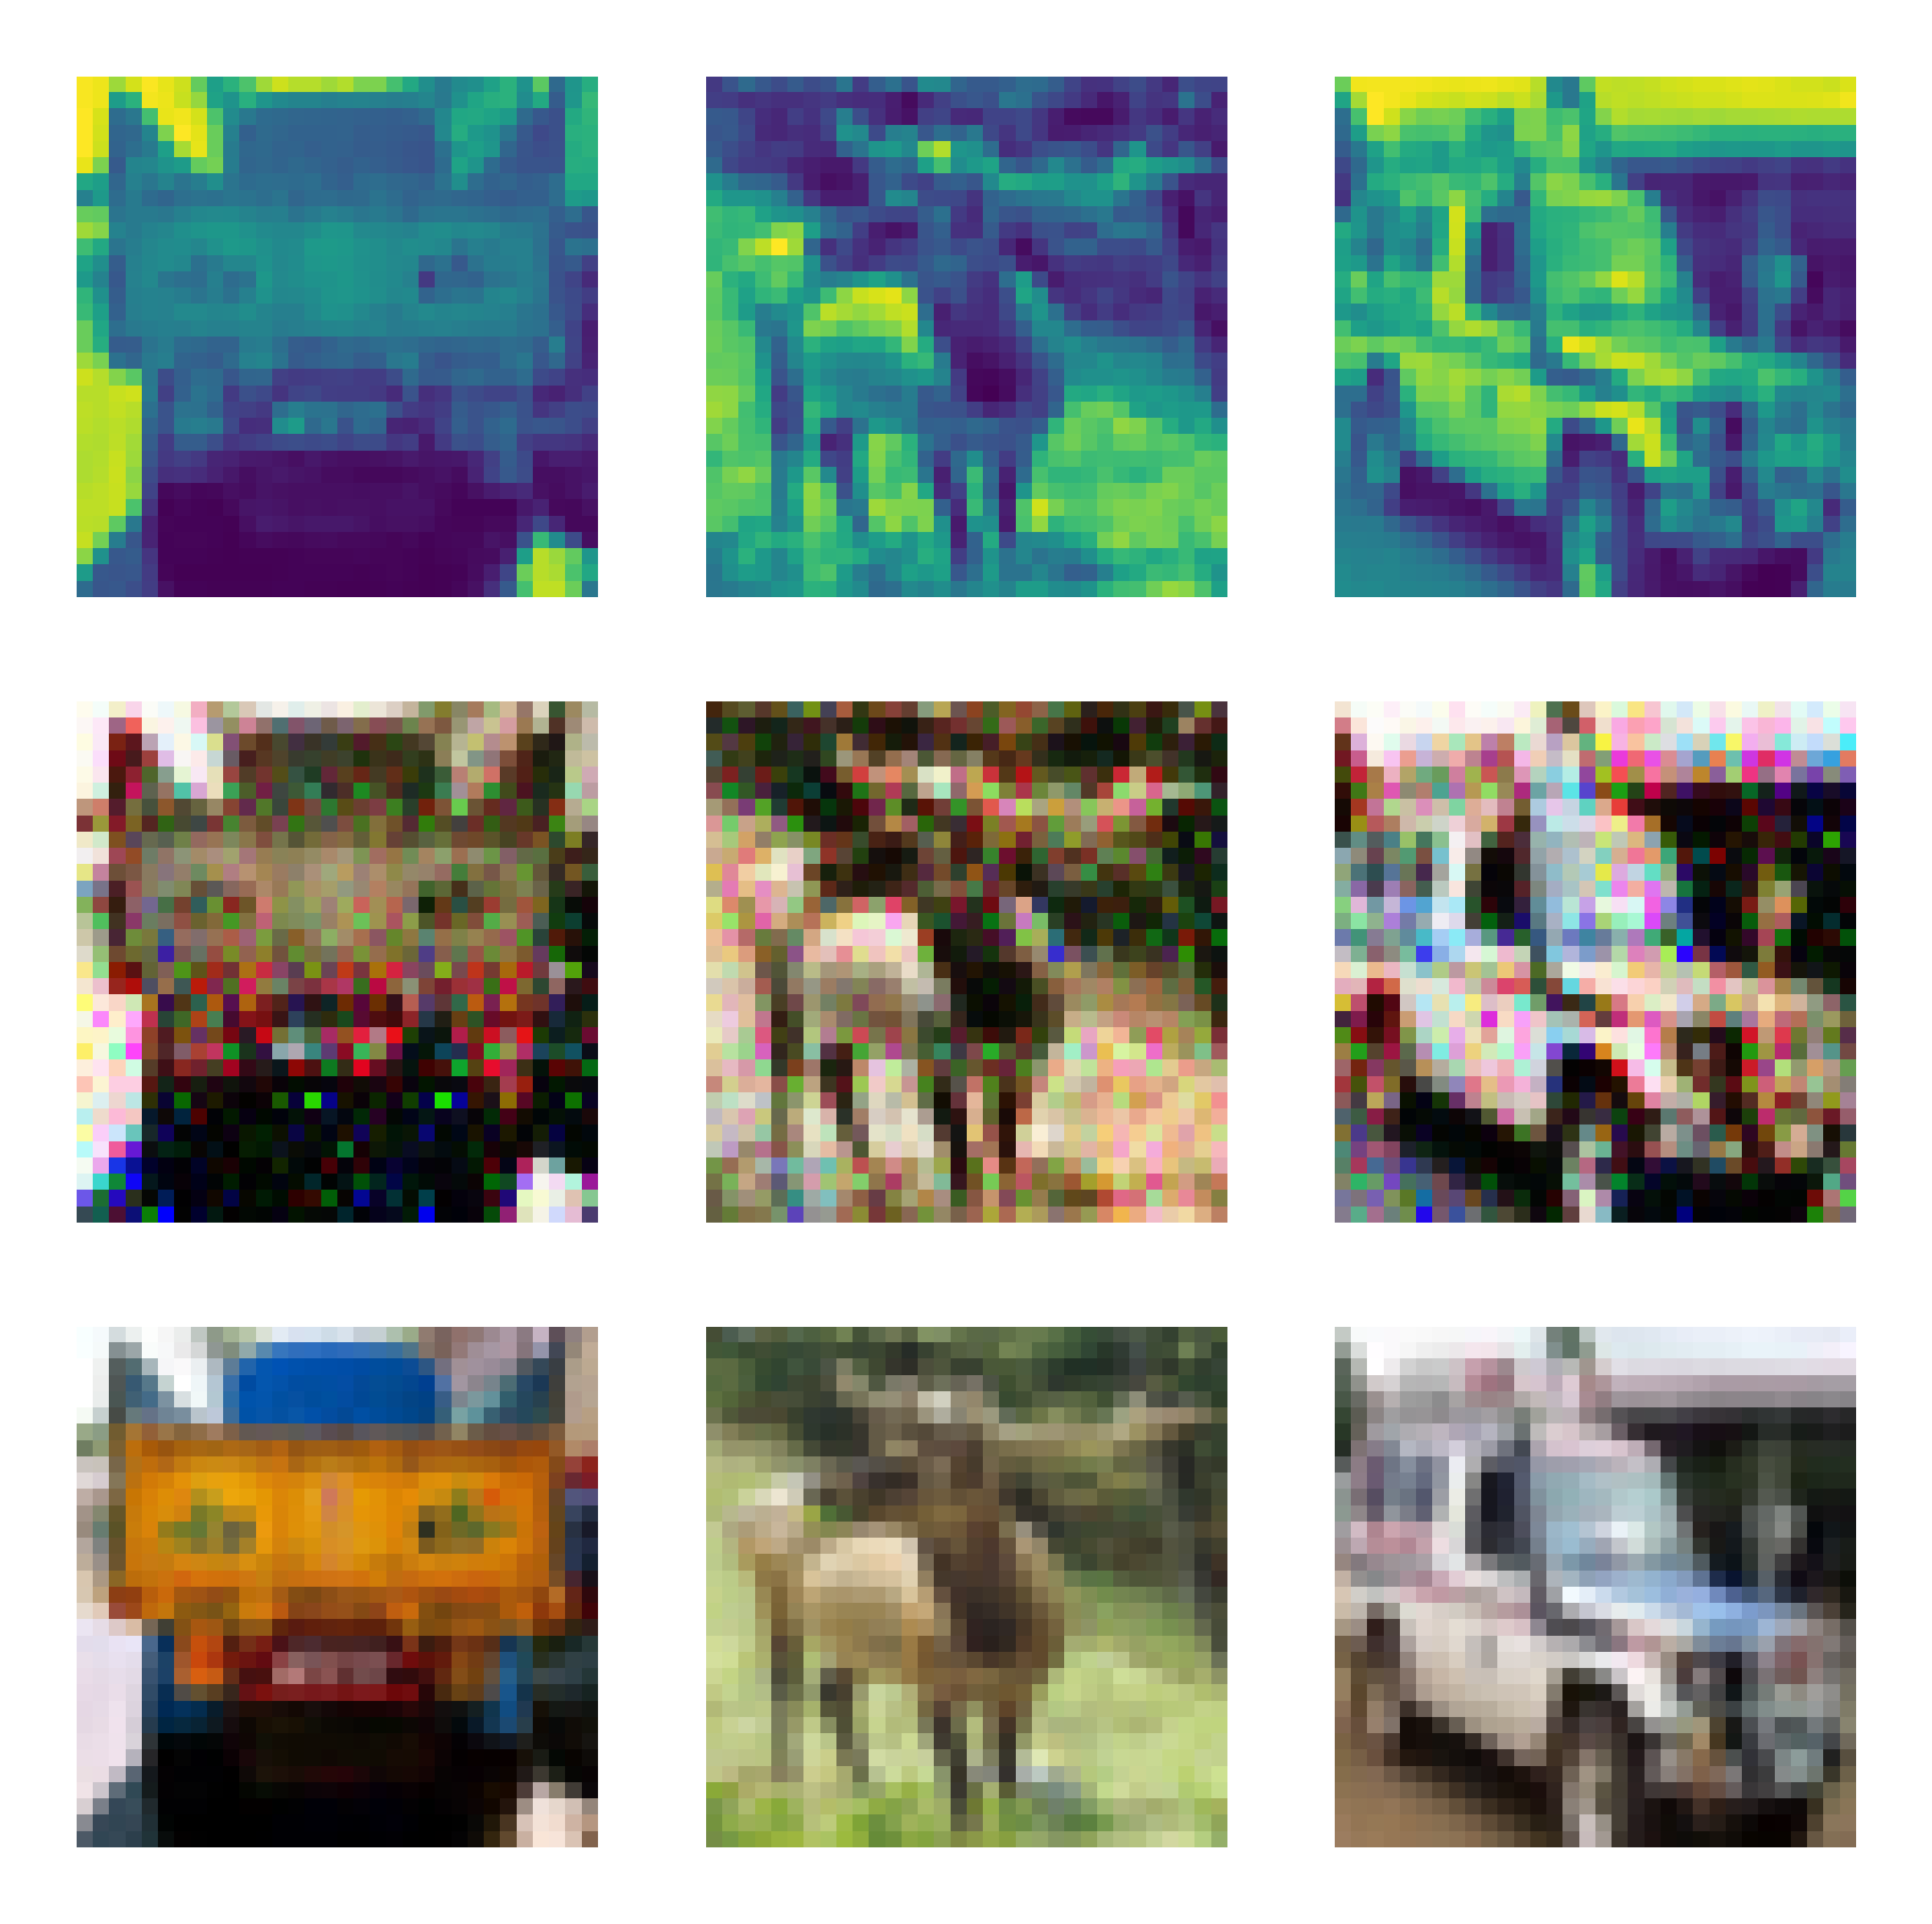

##############
For Epoch:15
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.1625803623862711
Generator loss:0.6585492356720134
1/1 [==============================] - 0s 19ms/step


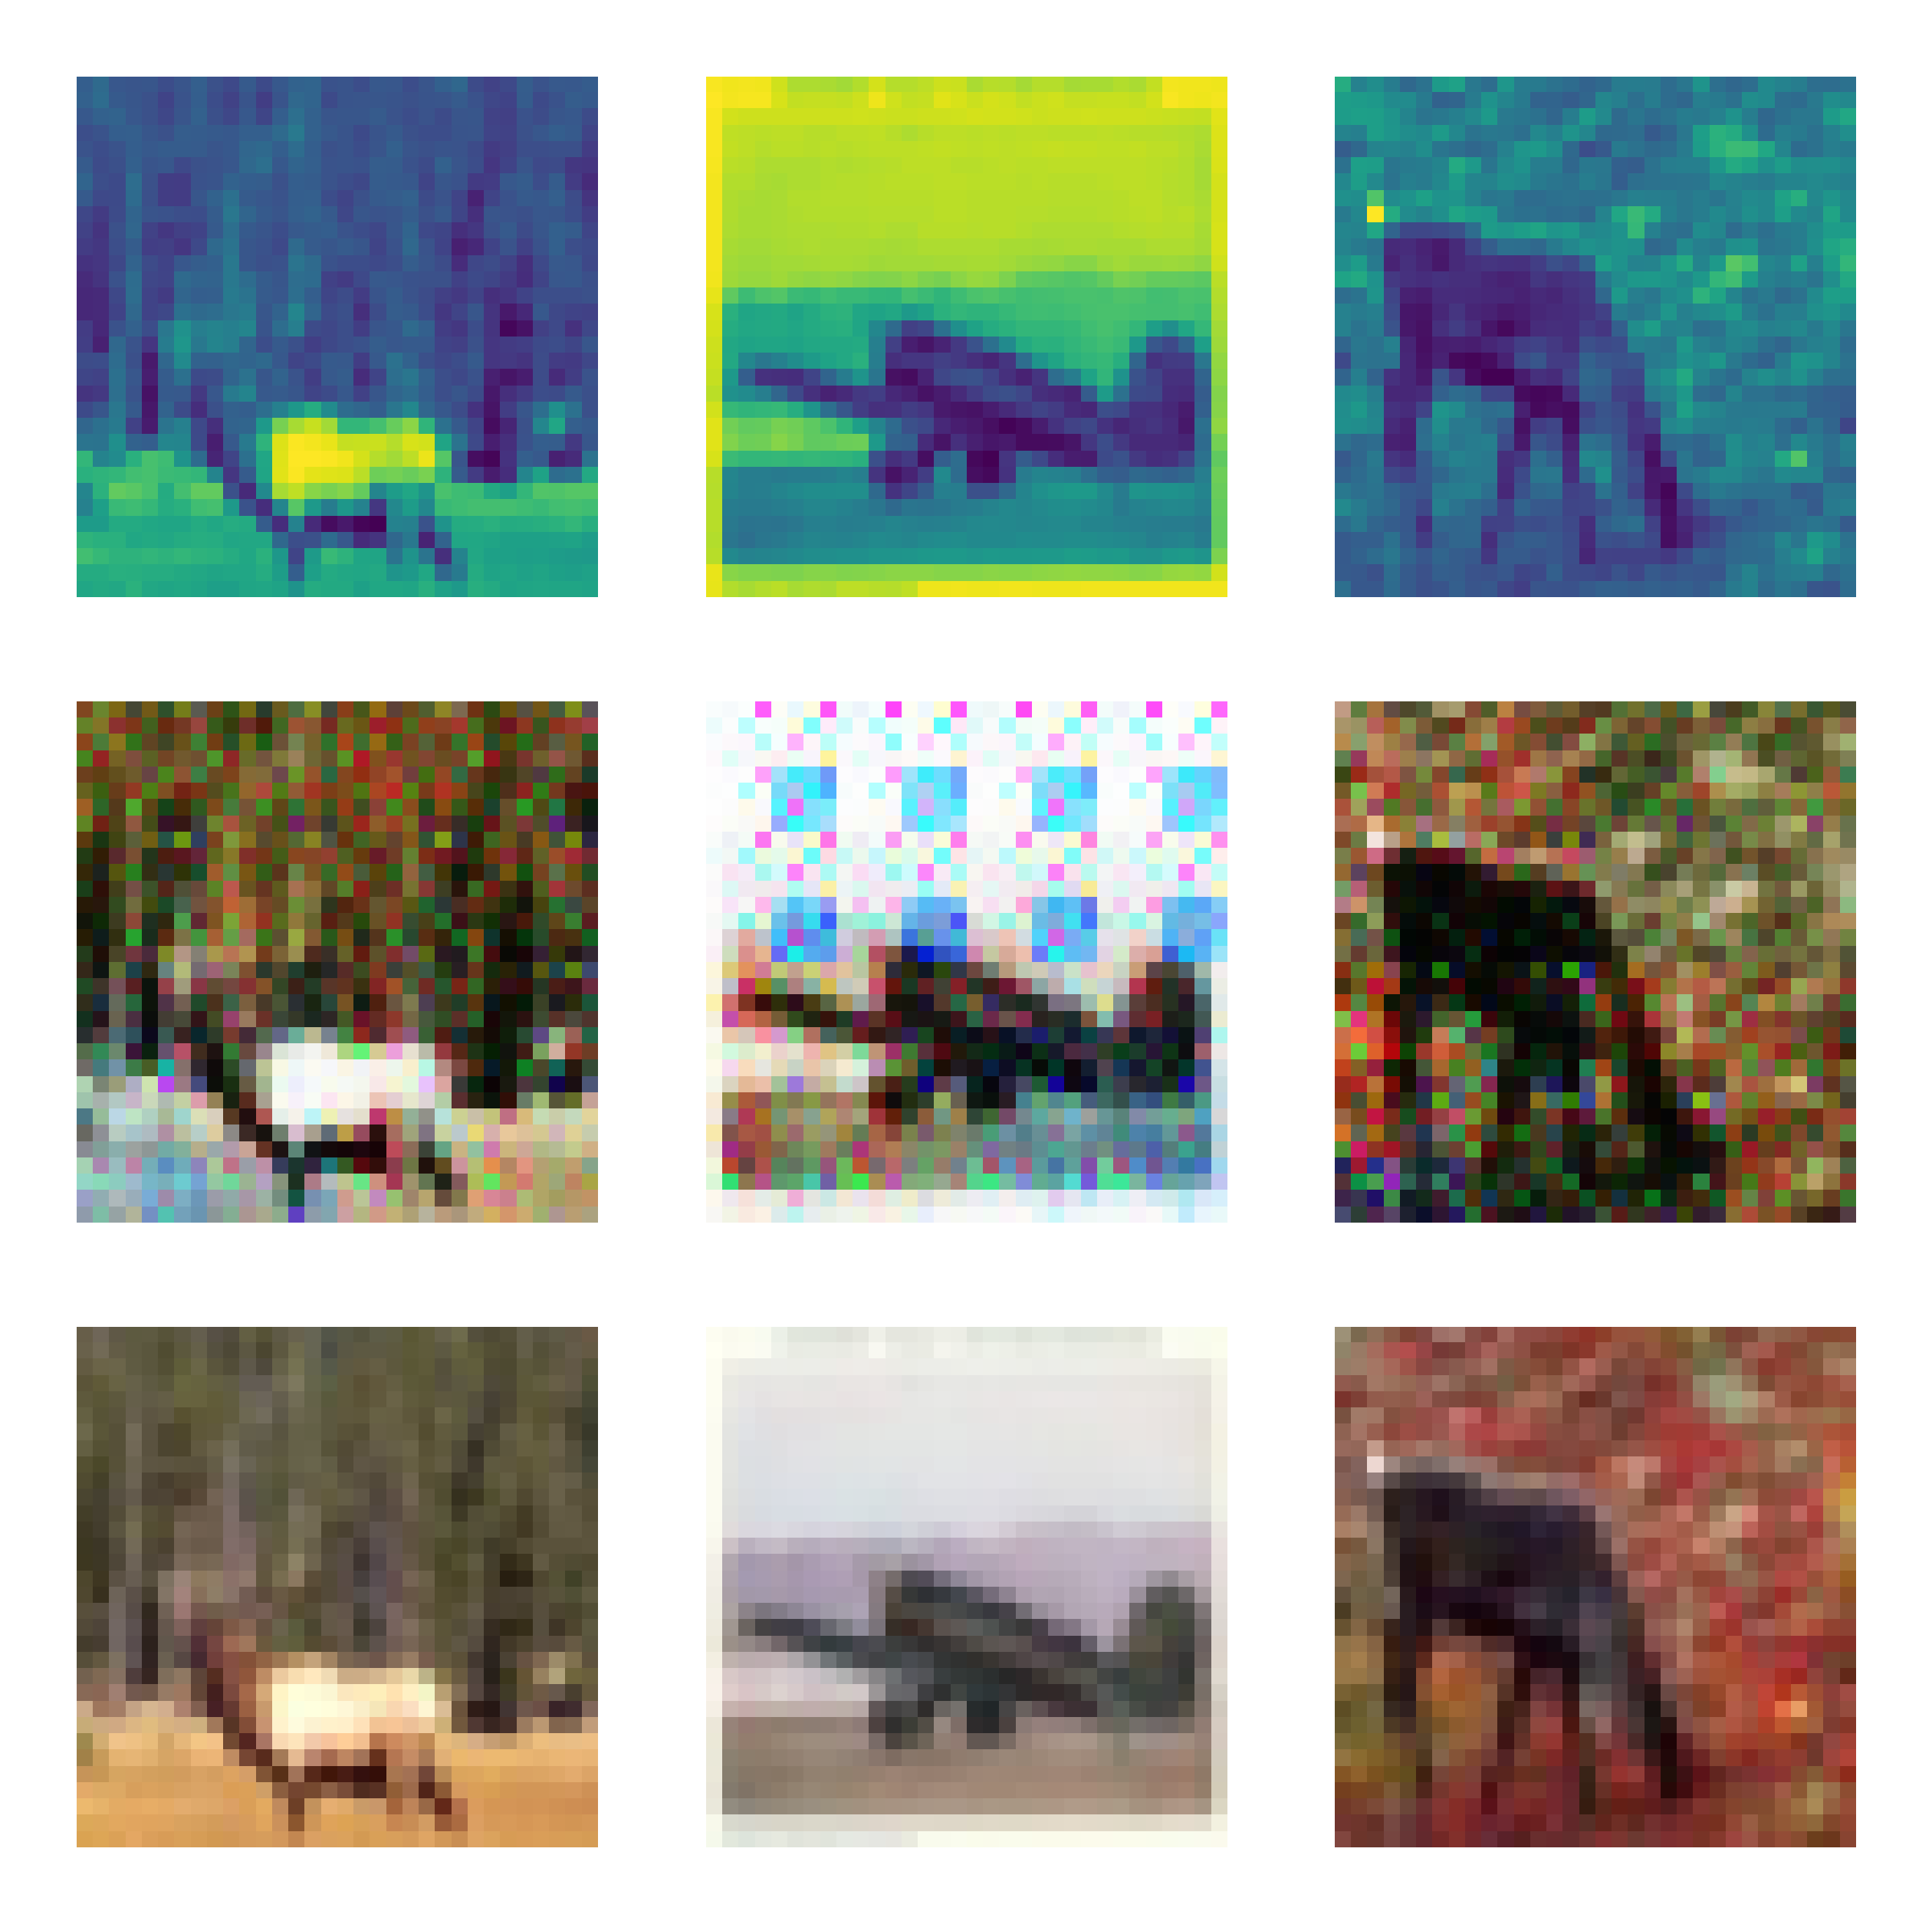

##############
For Epoch:16
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.16259079321654074
Generator loss:0.6590201281584226
1/1 [==============================] - 0s 20ms/step


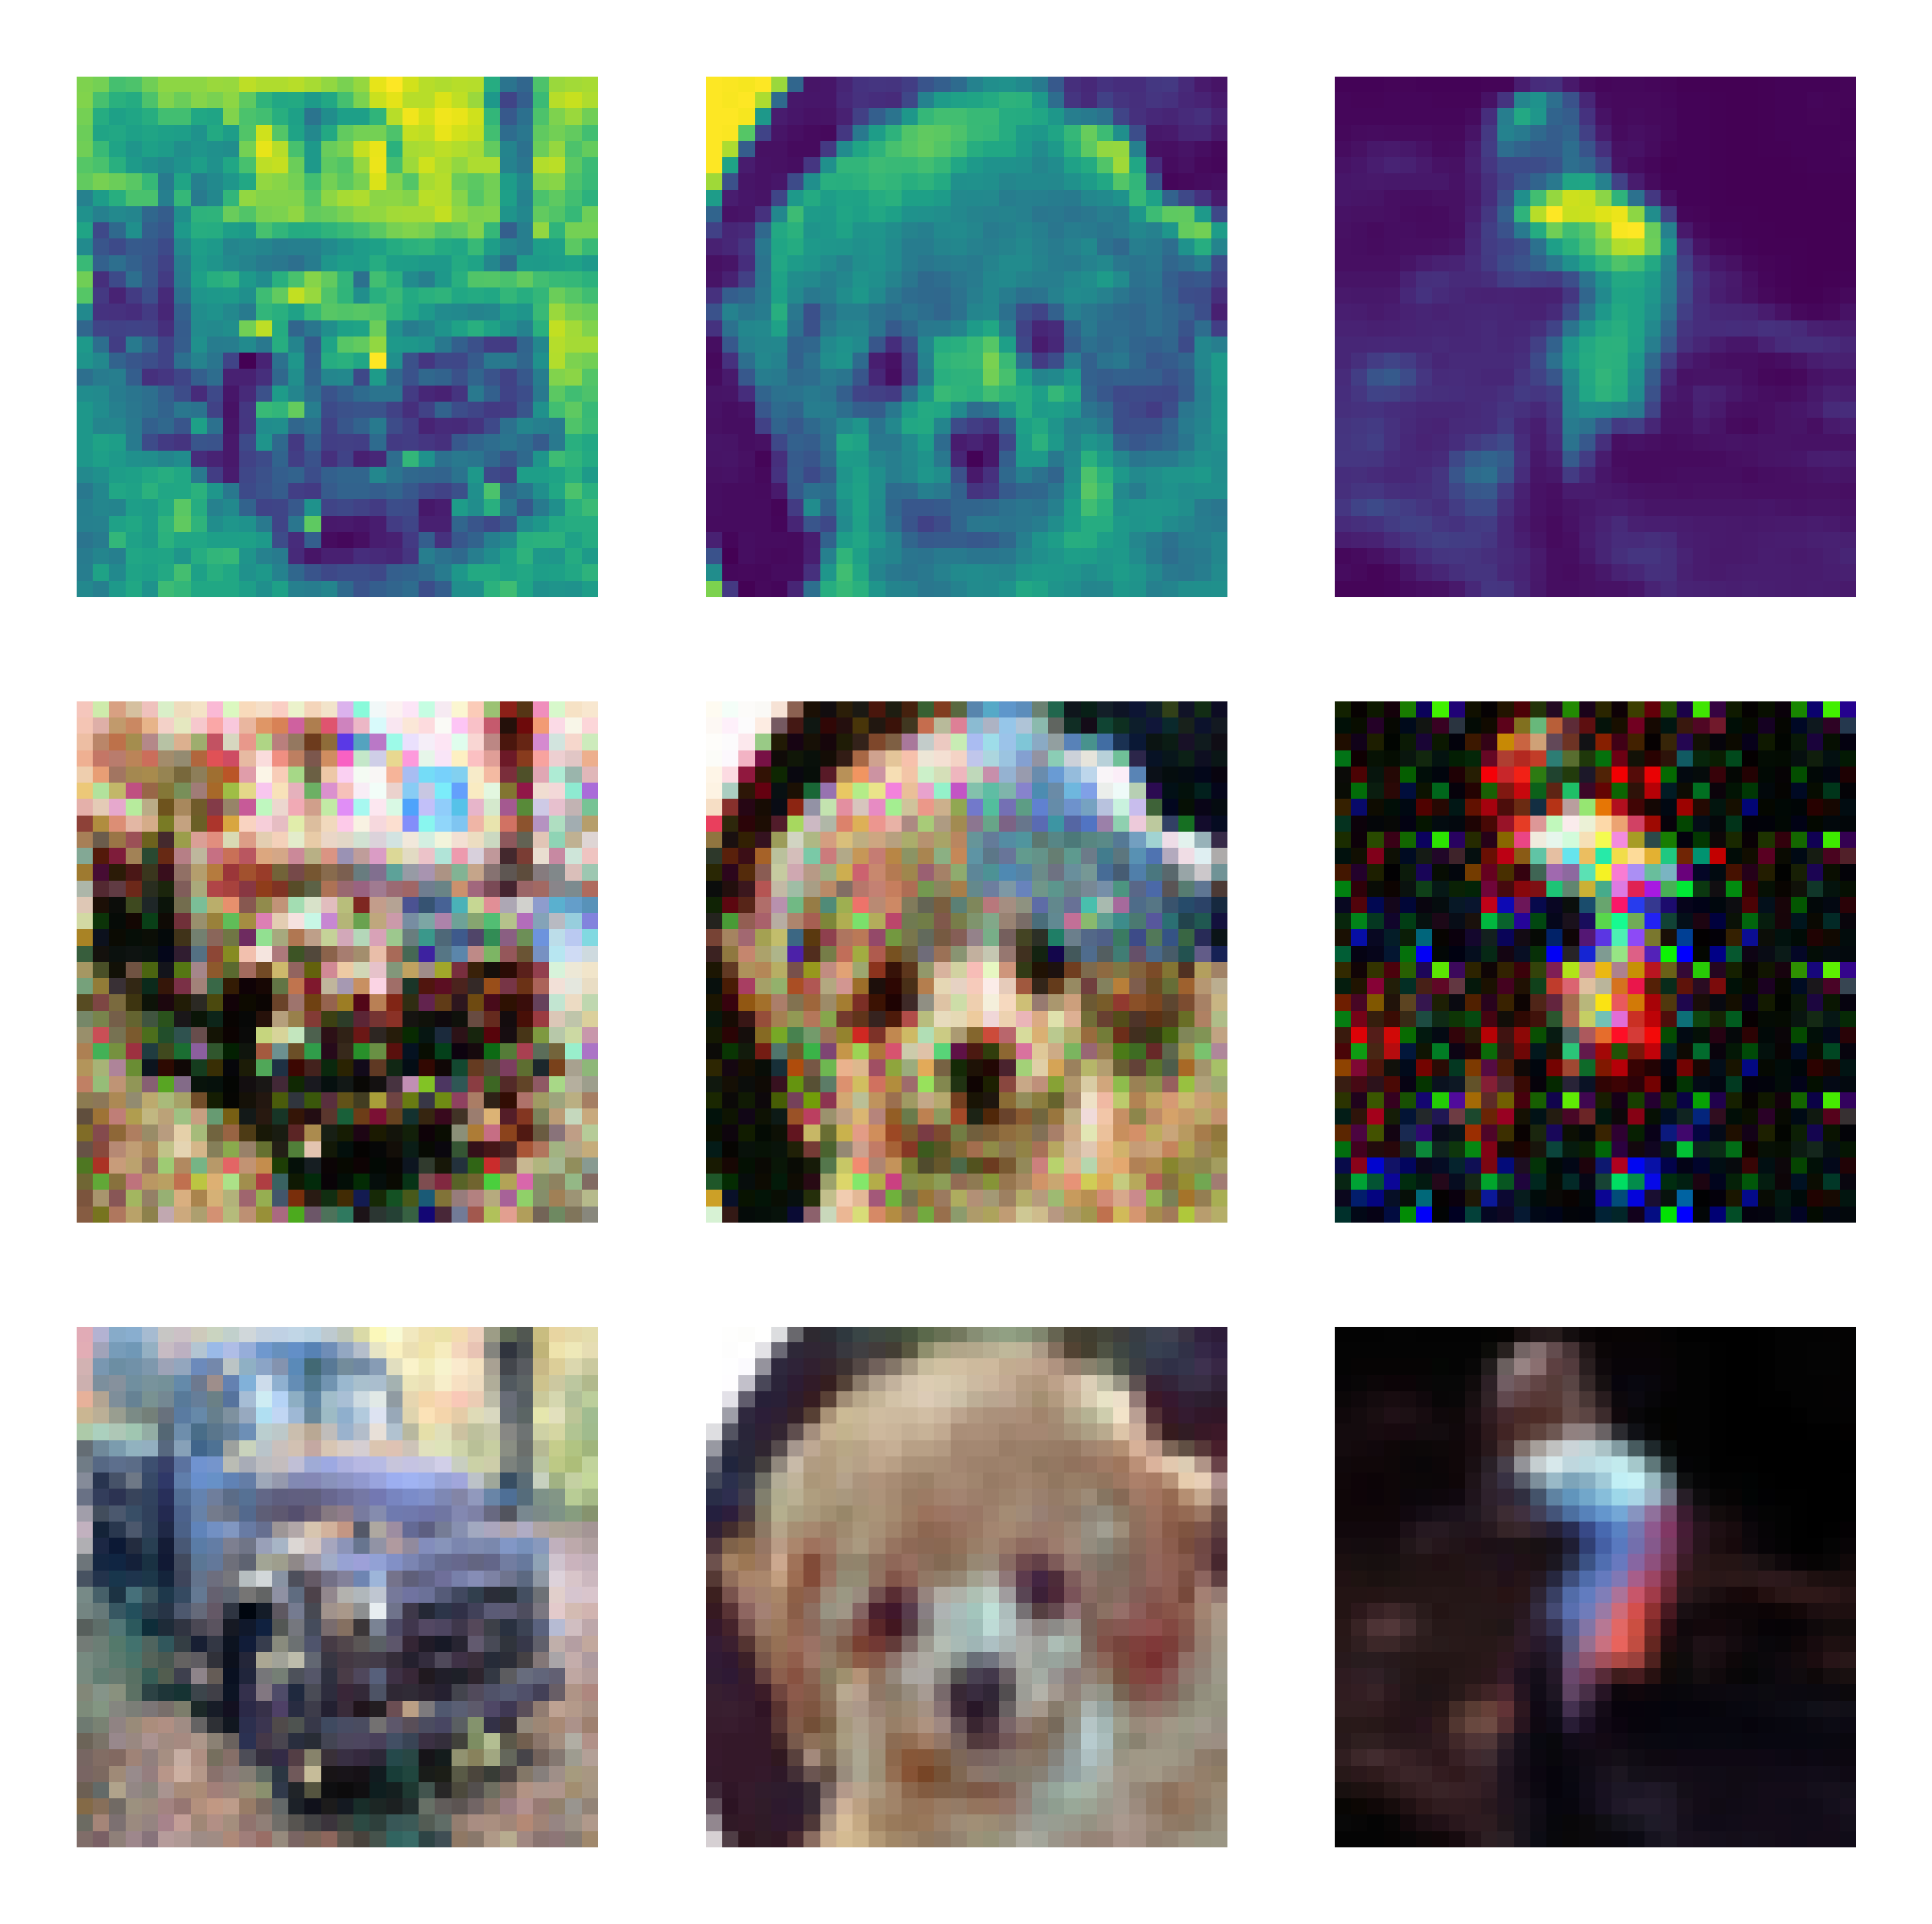

##############
For Epoch:17
Training Discriminator
2/2 [==============================] - 0s 10ms/step
Training Generator
Discriminator Loss:0.16259340549487372
Generator loss:0.6582041655340766
1/1 [==============================] - 0s 17ms/step


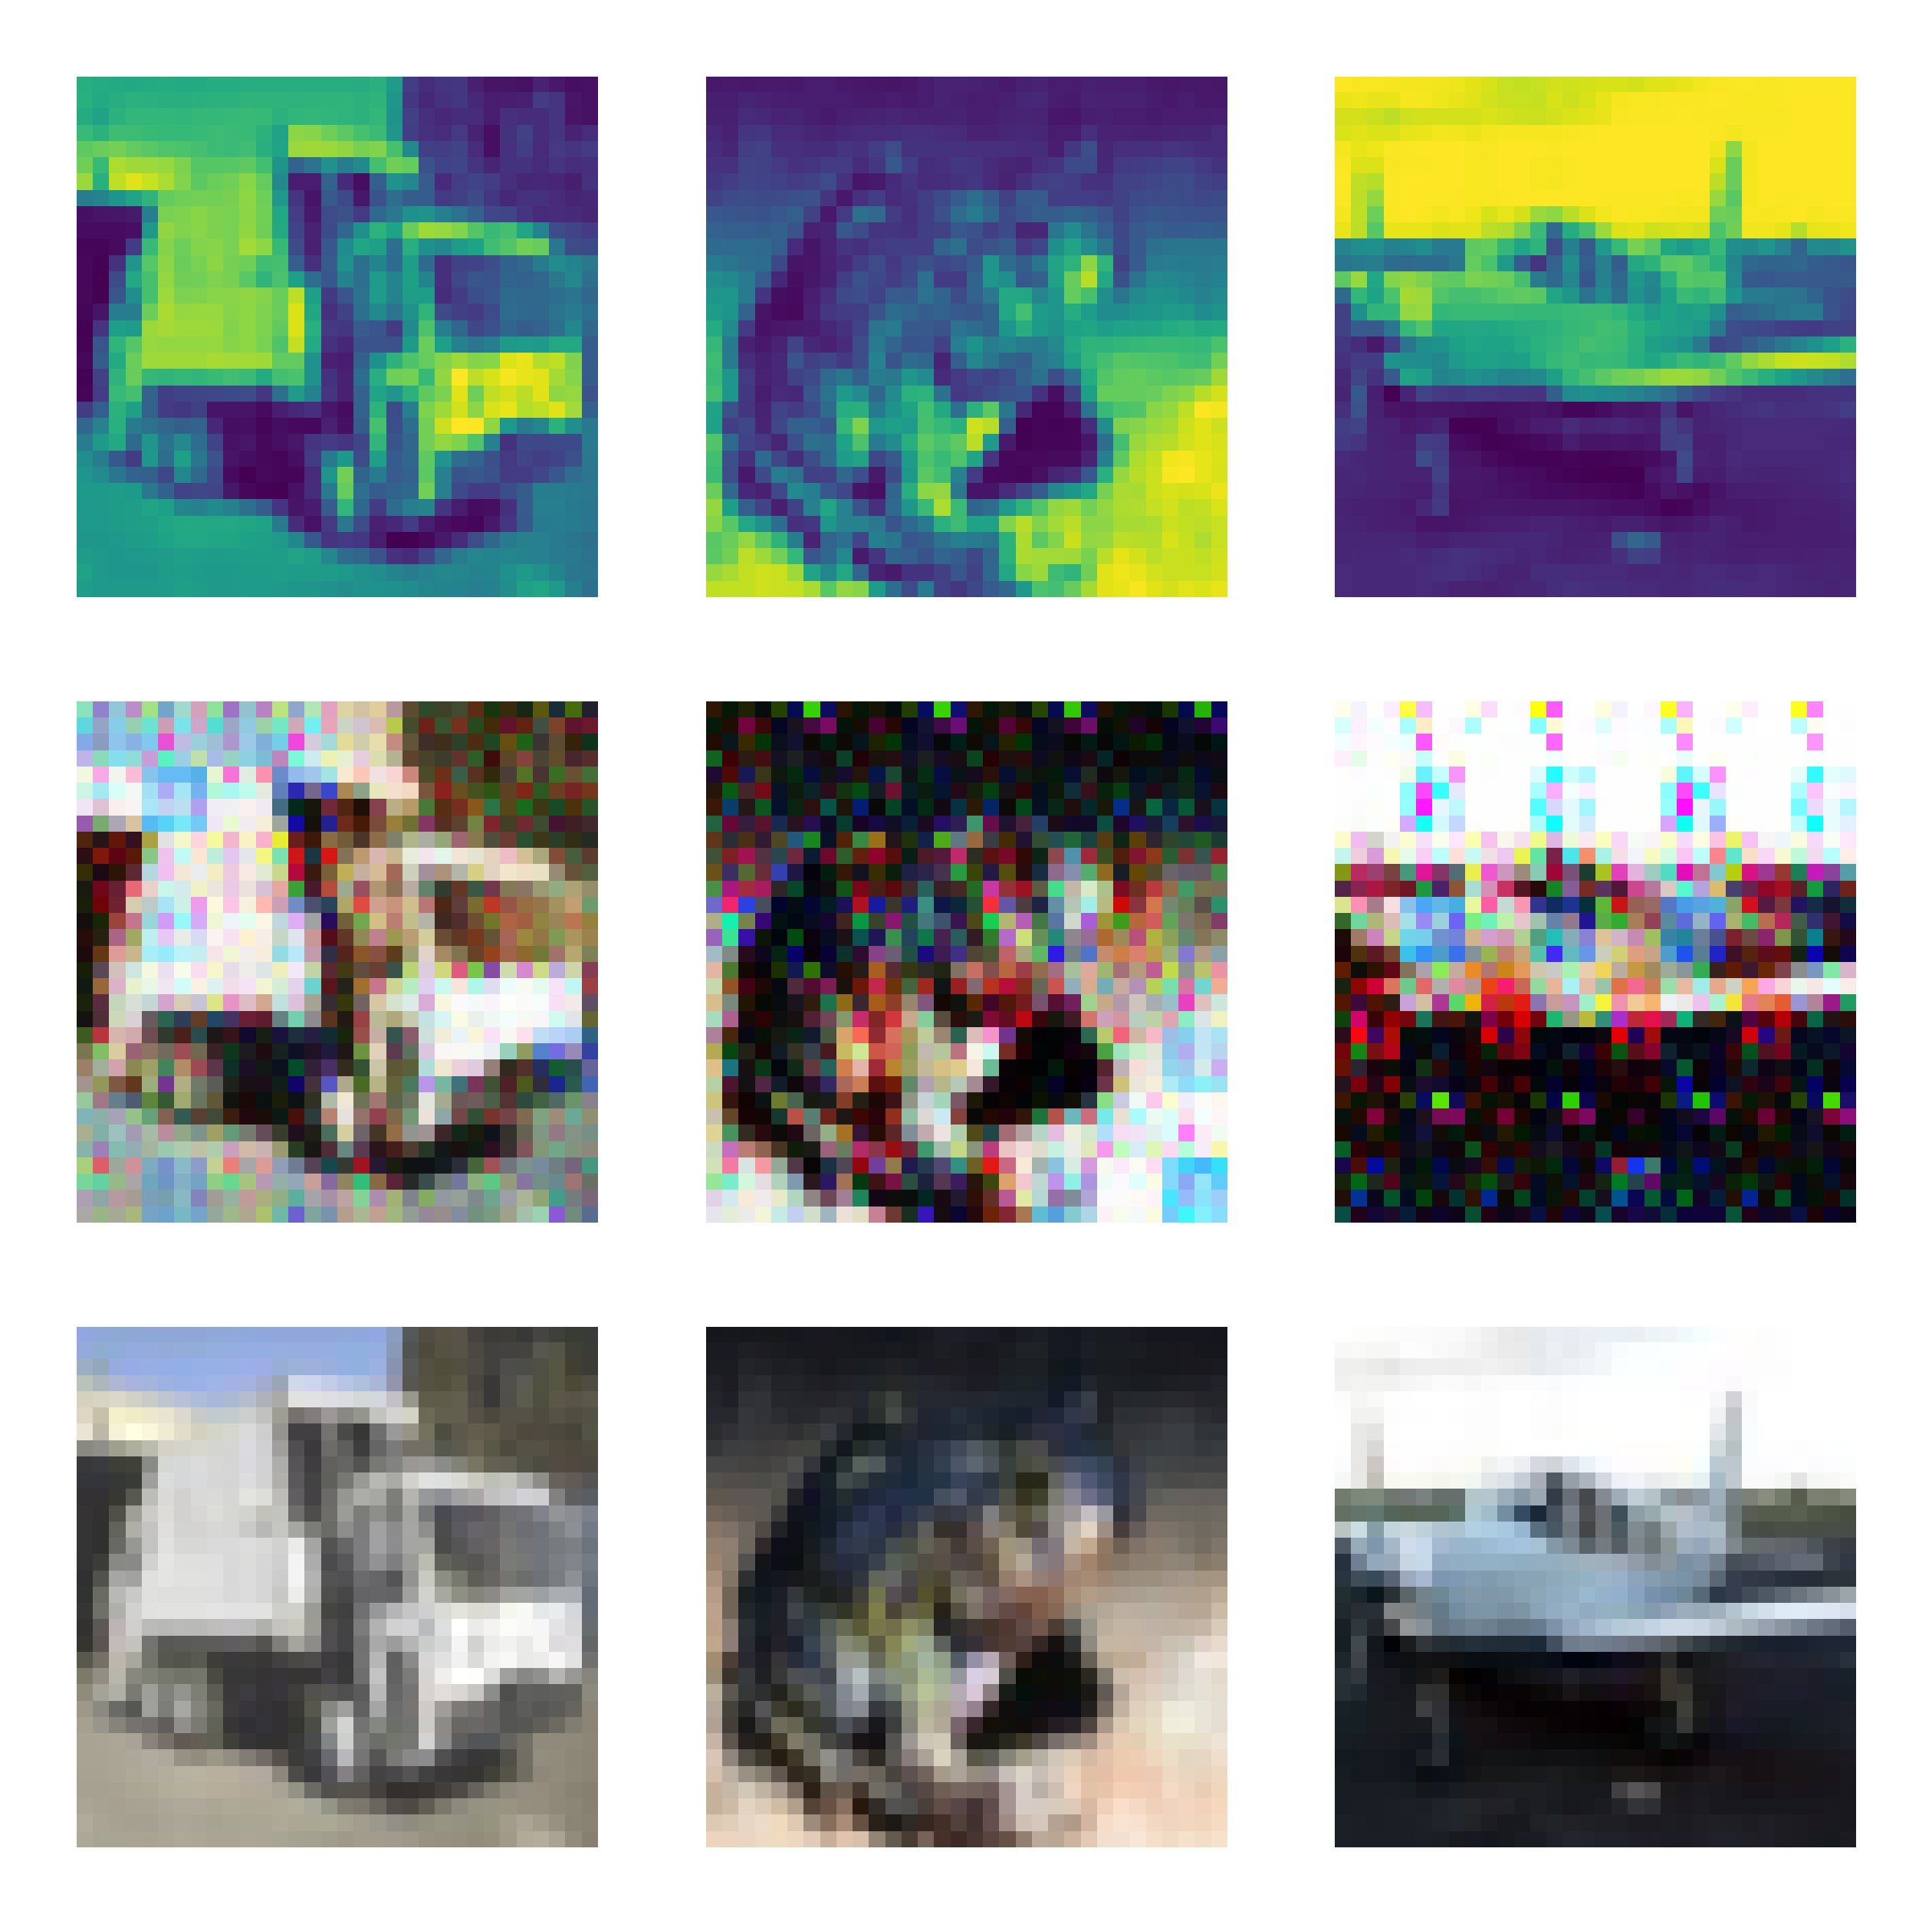

##############
For Epoch:18
Training Discriminator
2/2 [==============================] - 0s 6ms/step
Training Generator
Discriminator Loss:0.16260321883470627
Generator loss:0.6588268020214179
1/1 [==============================] - 0s 19ms/step


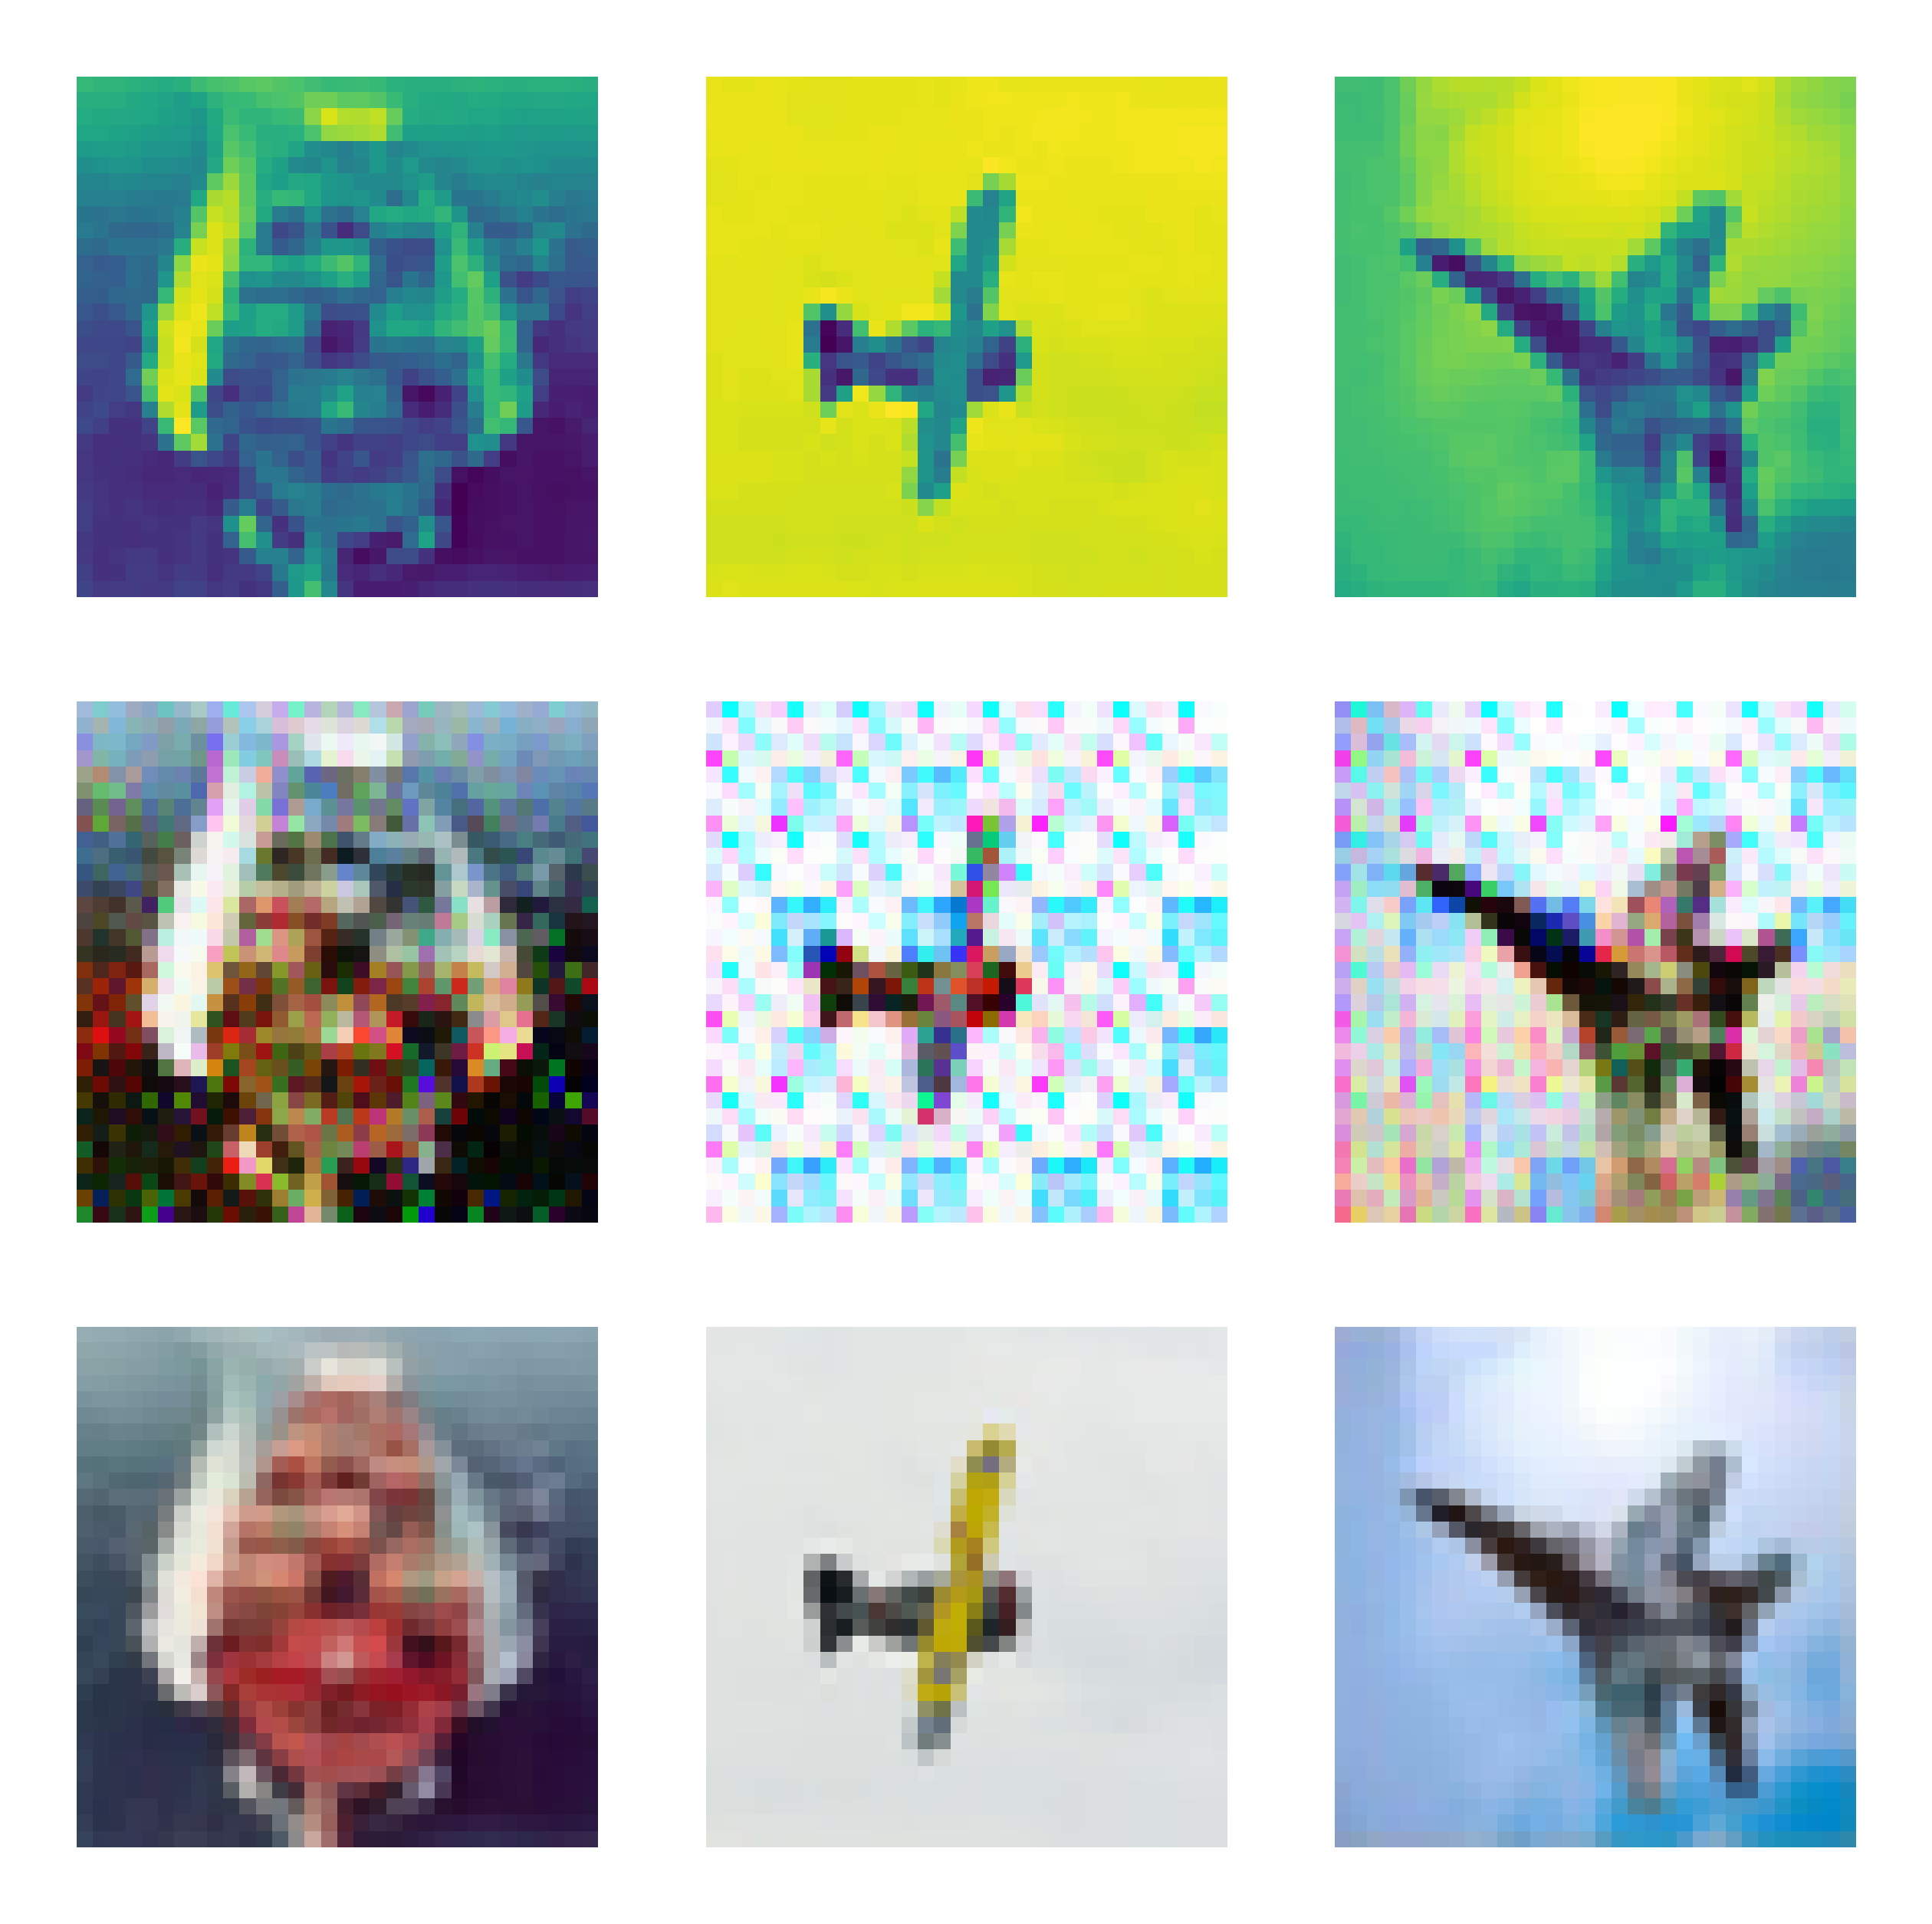

##############
For Epoch:19
Training Discriminator
2/2 [==============================] - 0s 7ms/step
Training Generator
Discriminator Loss:0.16258609128123674
Generator loss:0.659089878328845
1/1 [==============================] - 0s 18ms/step


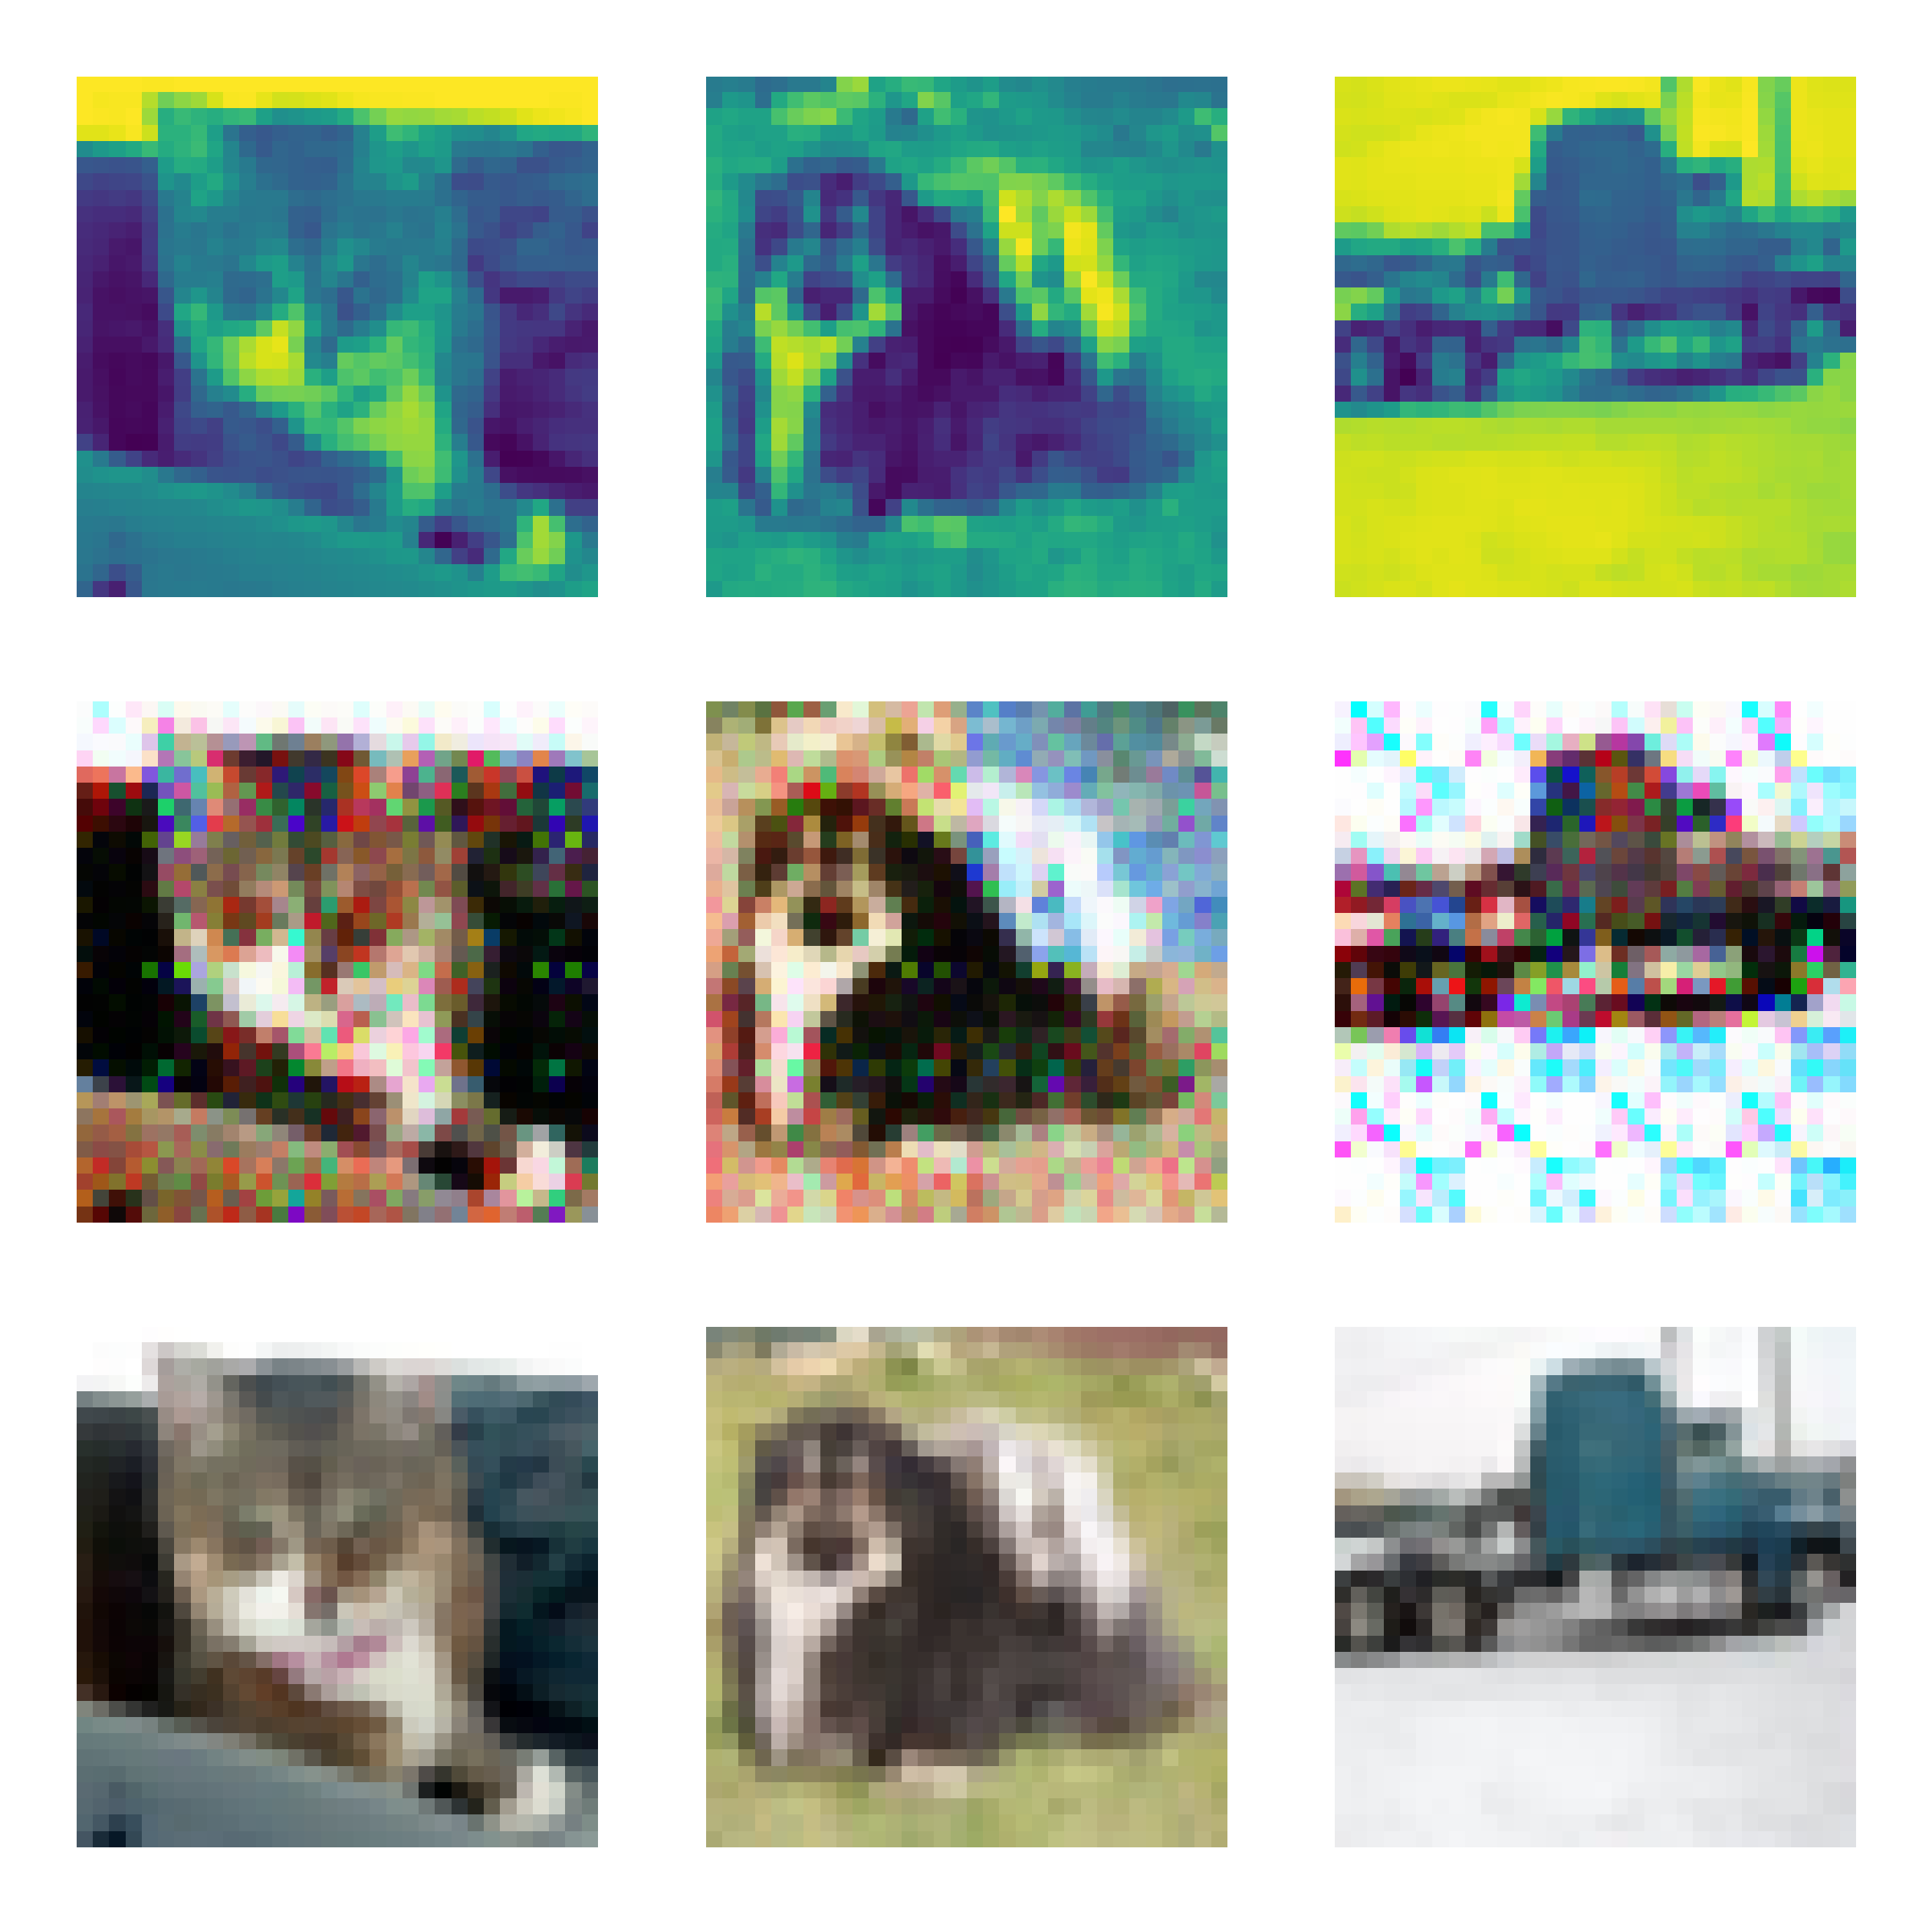

##############
For Epoch:20
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.16257861563585219
Generator loss:0.6616139418294287
1/1 [==============================] - 0s 20ms/step


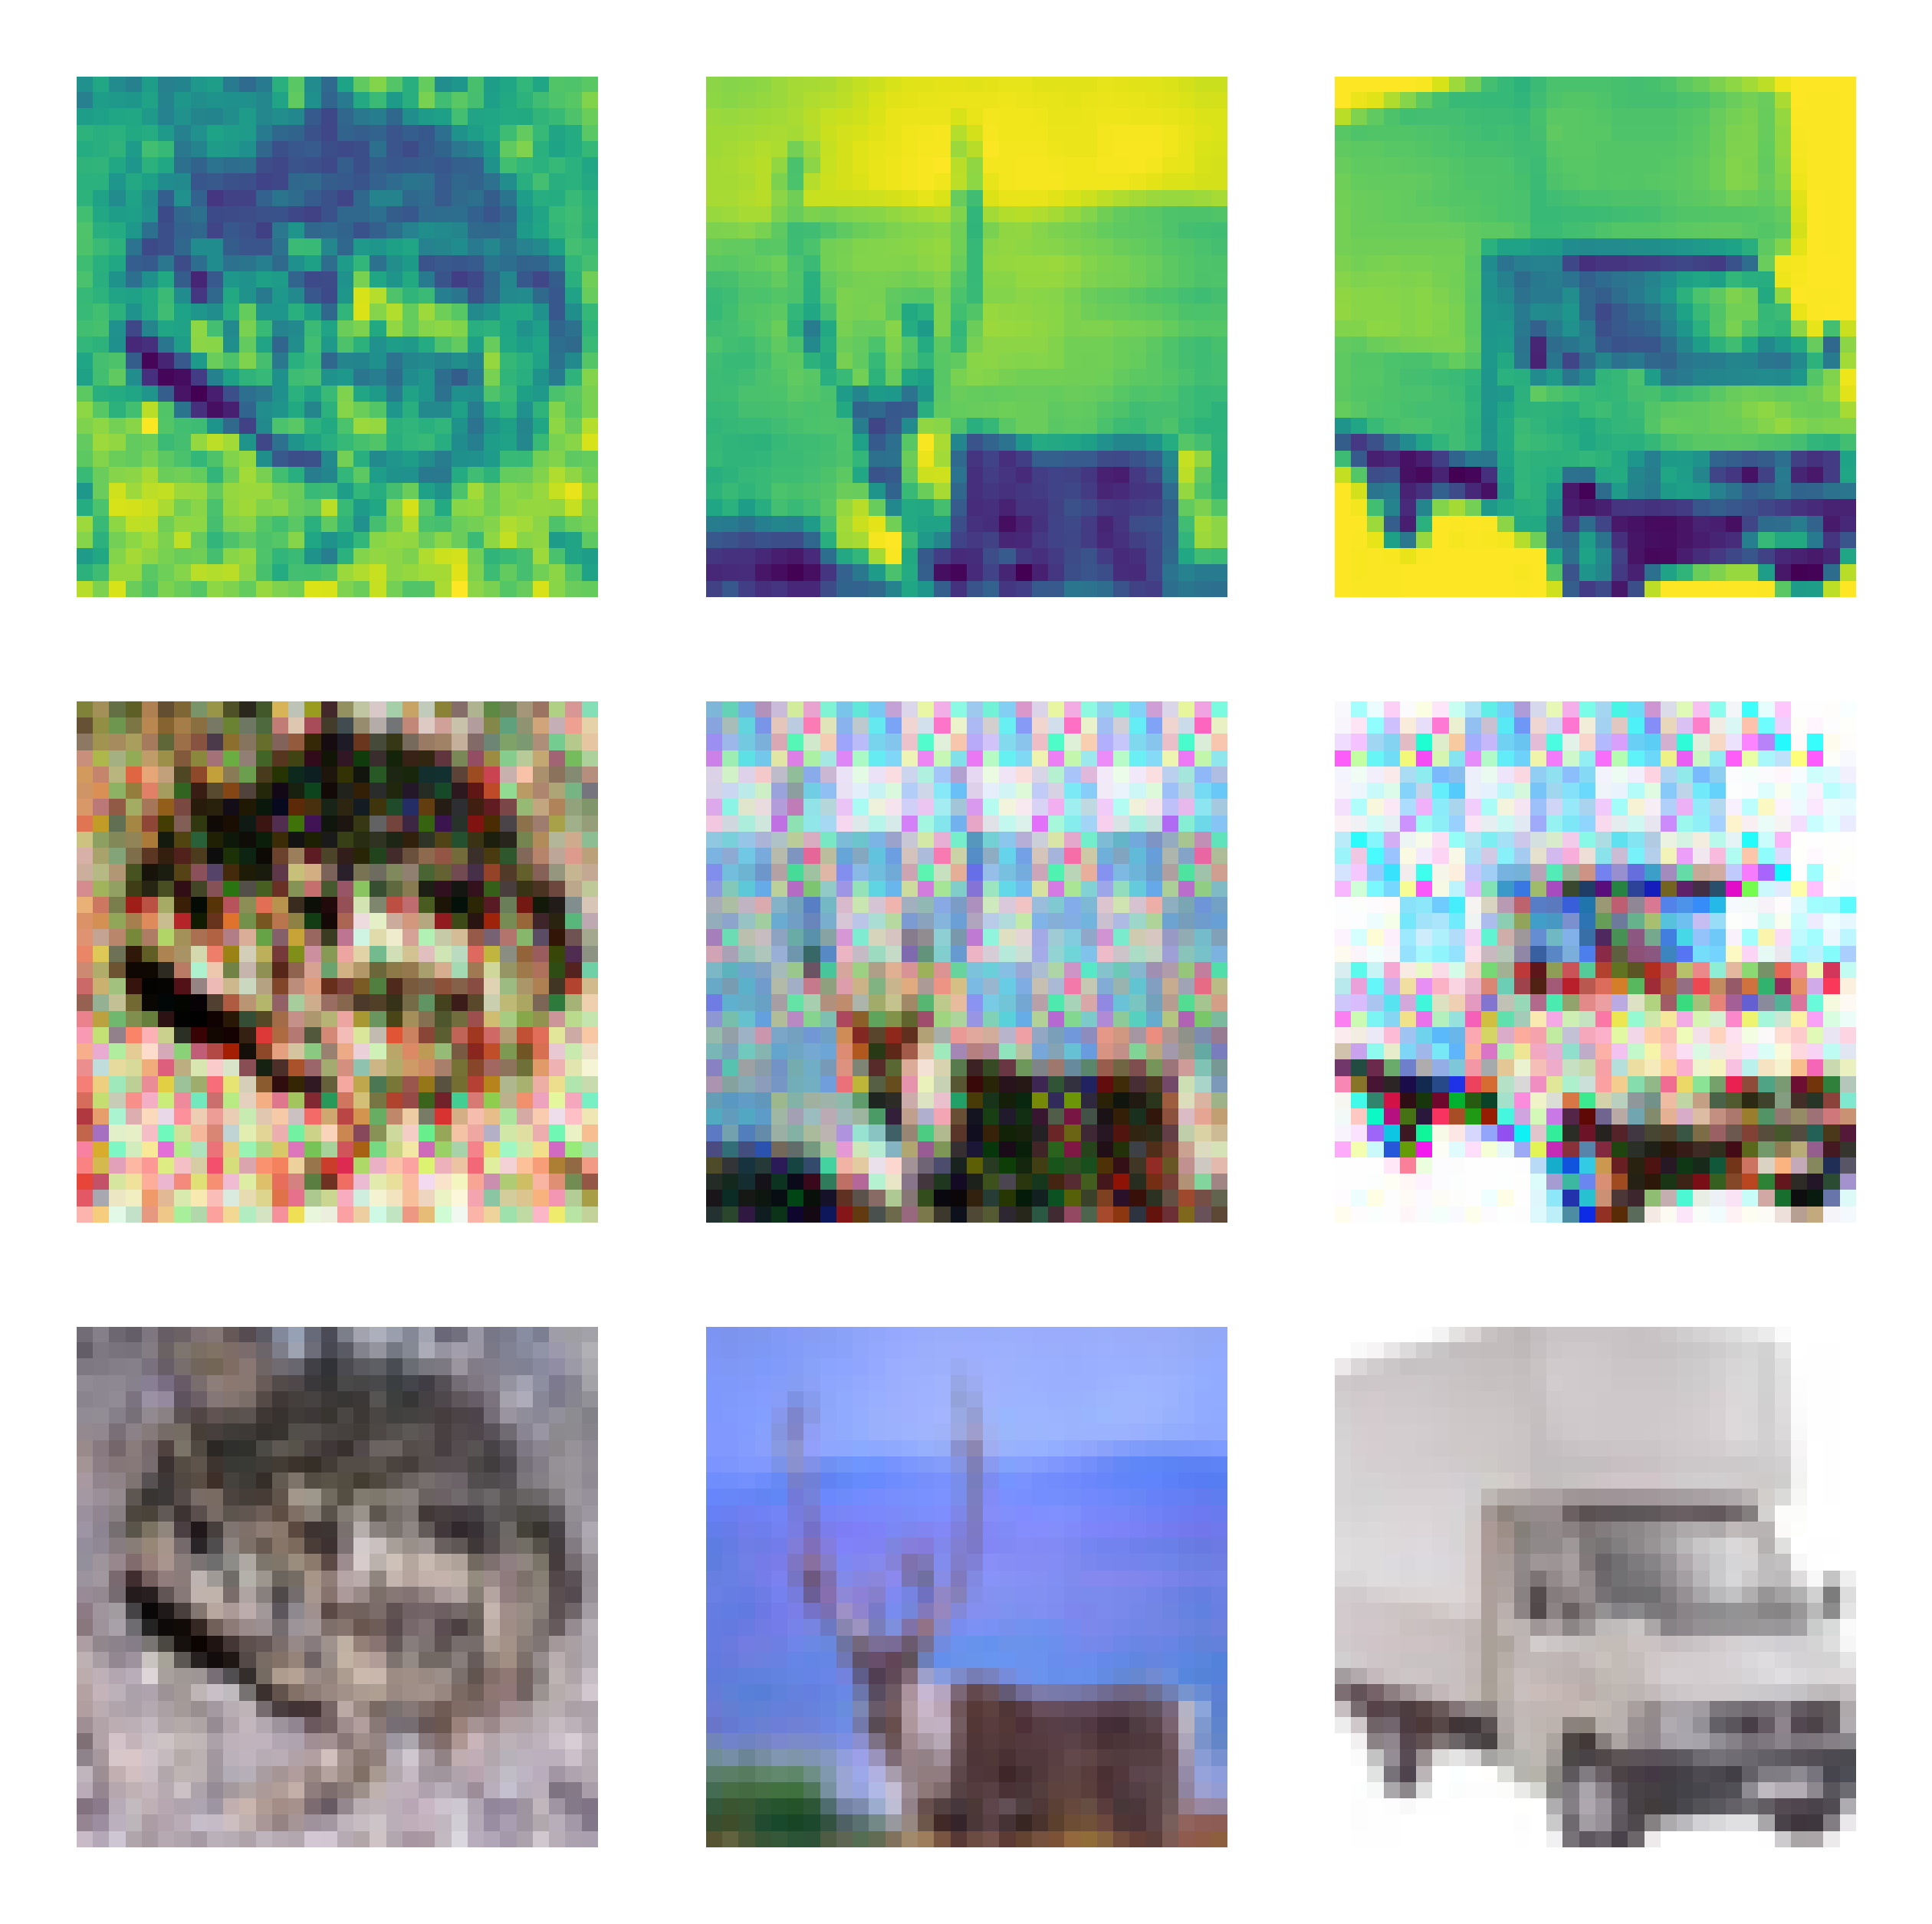

##############
For Epoch:21
Training Discriminator
2/2 [==============================] - 0s 7ms/step
Training Generator
Discriminator Loss:0.16258368912282564
Generator loss:0.6602880838844511
1/1 [==============================] - 0s 22ms/step


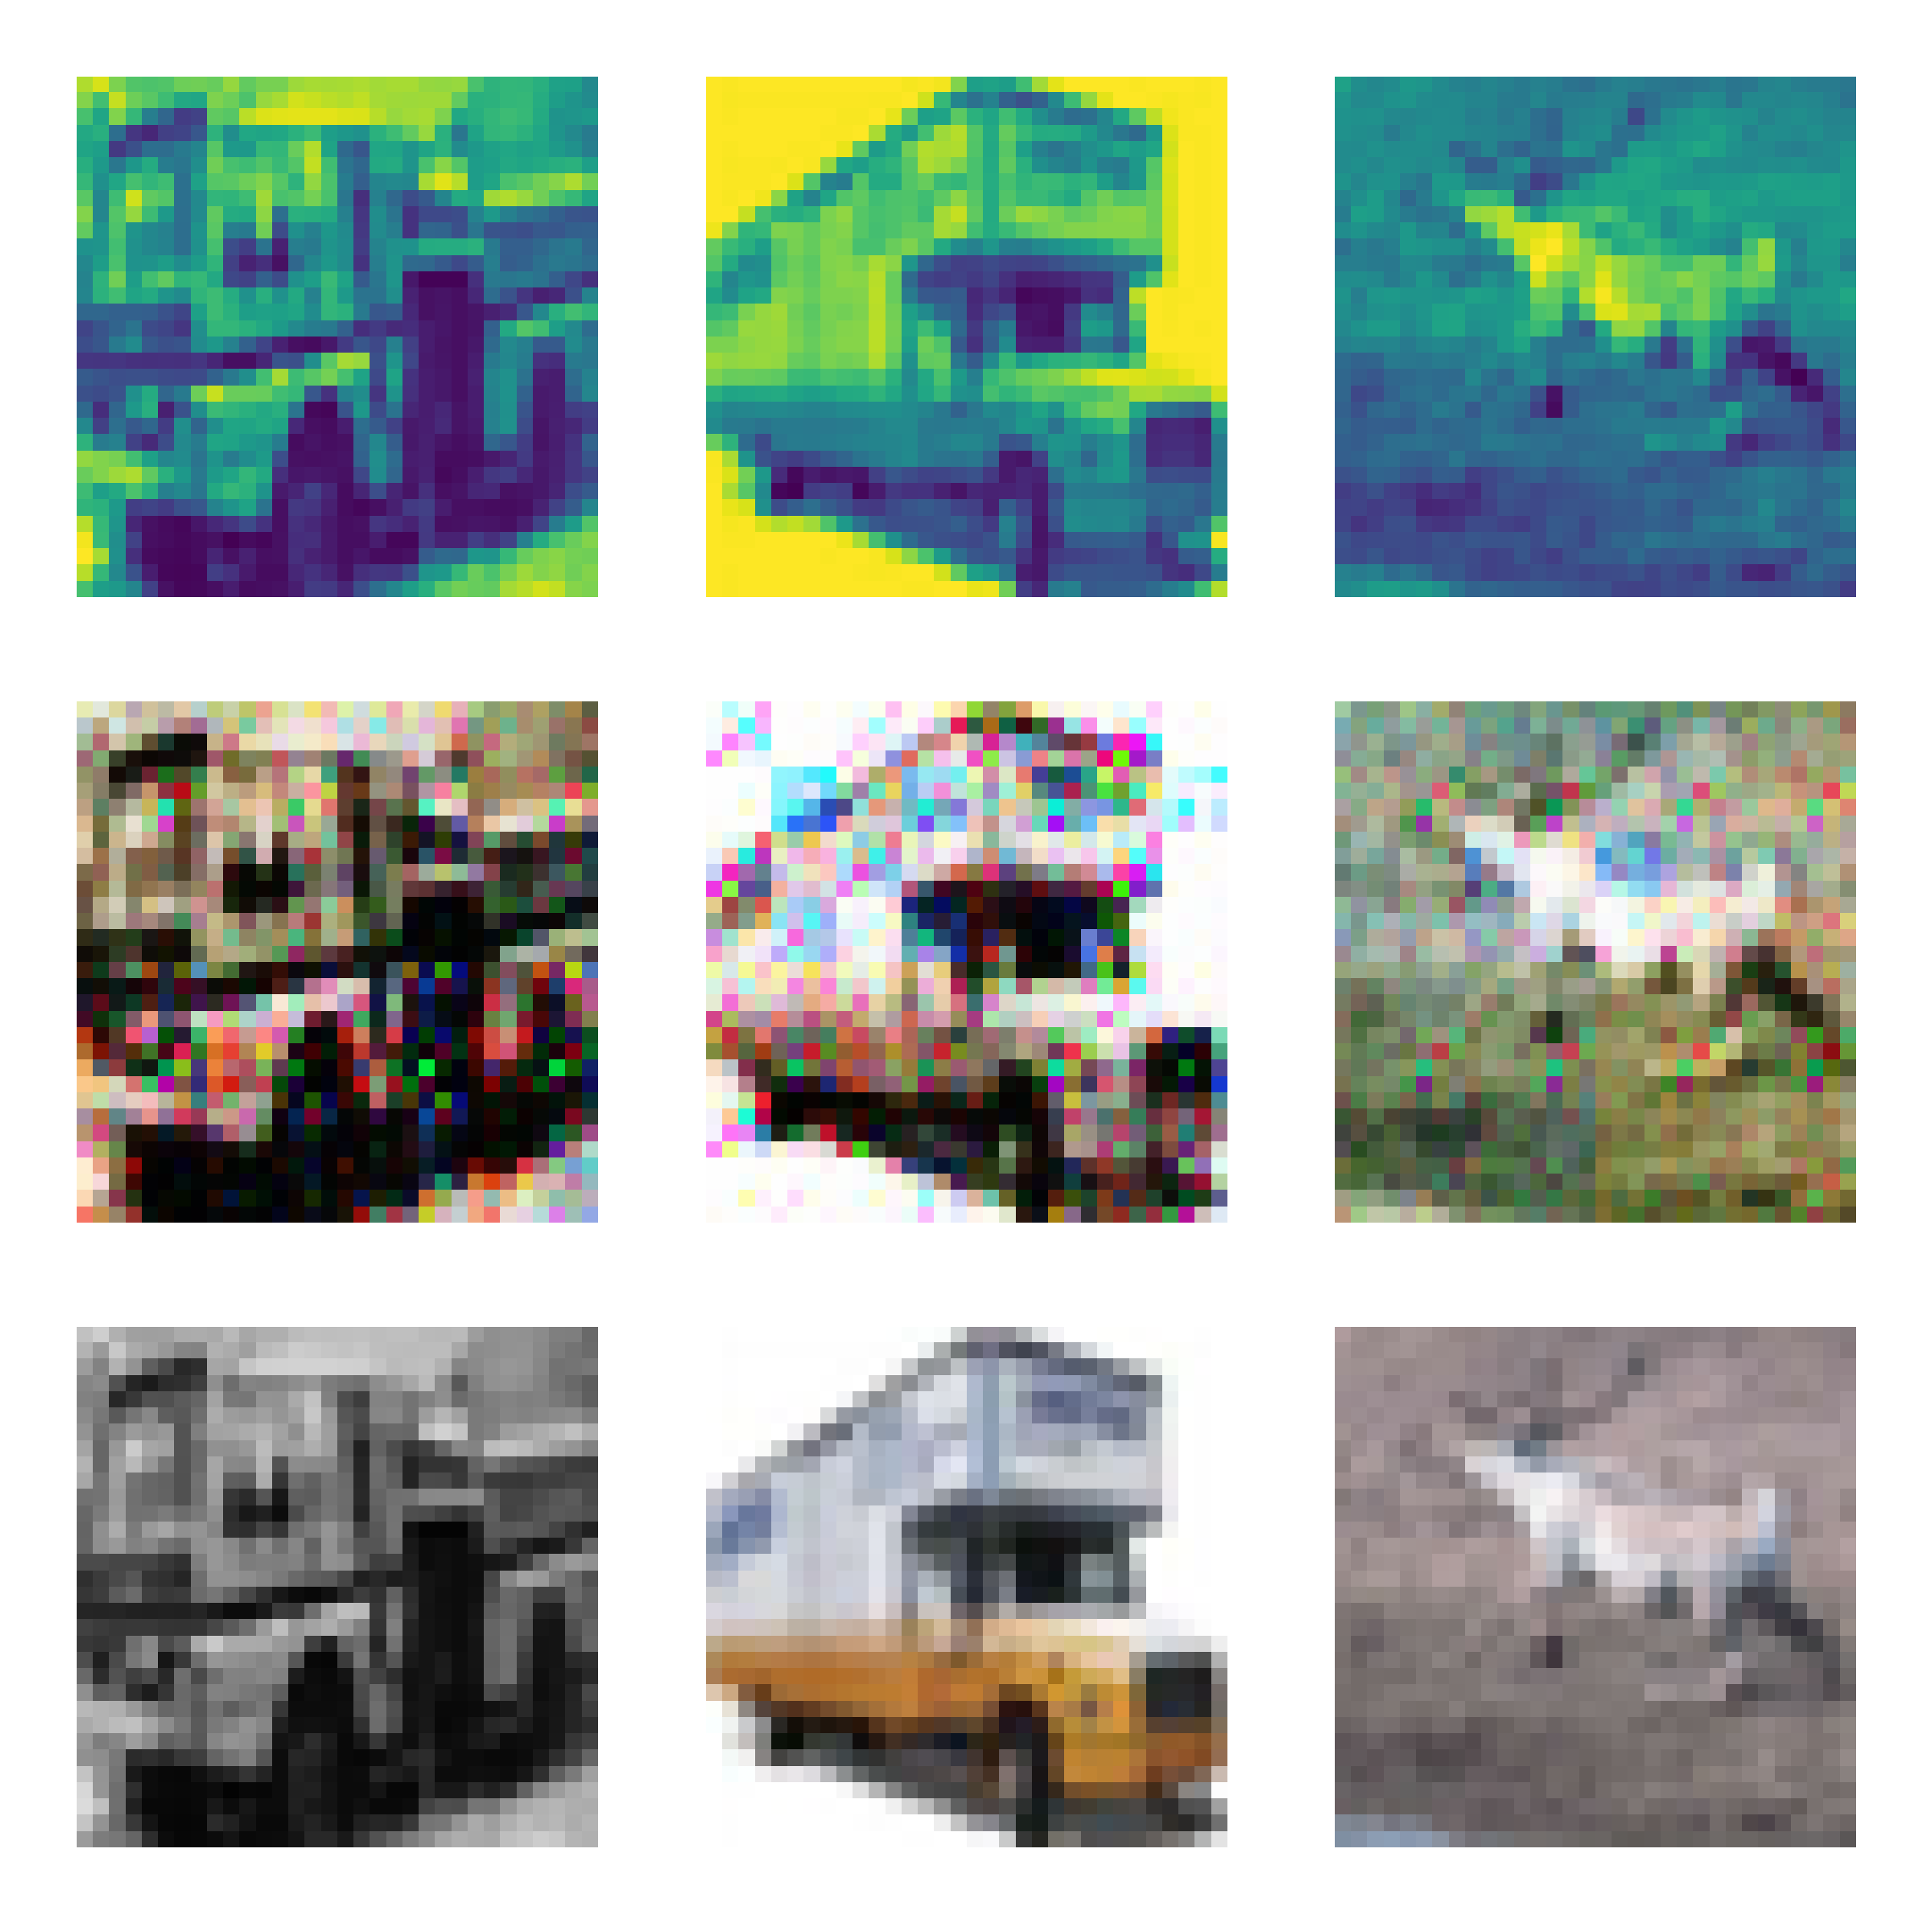

##############
For Epoch:22
Training Discriminator
2/2 [==============================] - 0s 22ms/step
Training Generator
Discriminator Loss:0.16257969783744514
Generator loss:0.6602166156228791
1/1 [==============================] - 0s 17ms/step


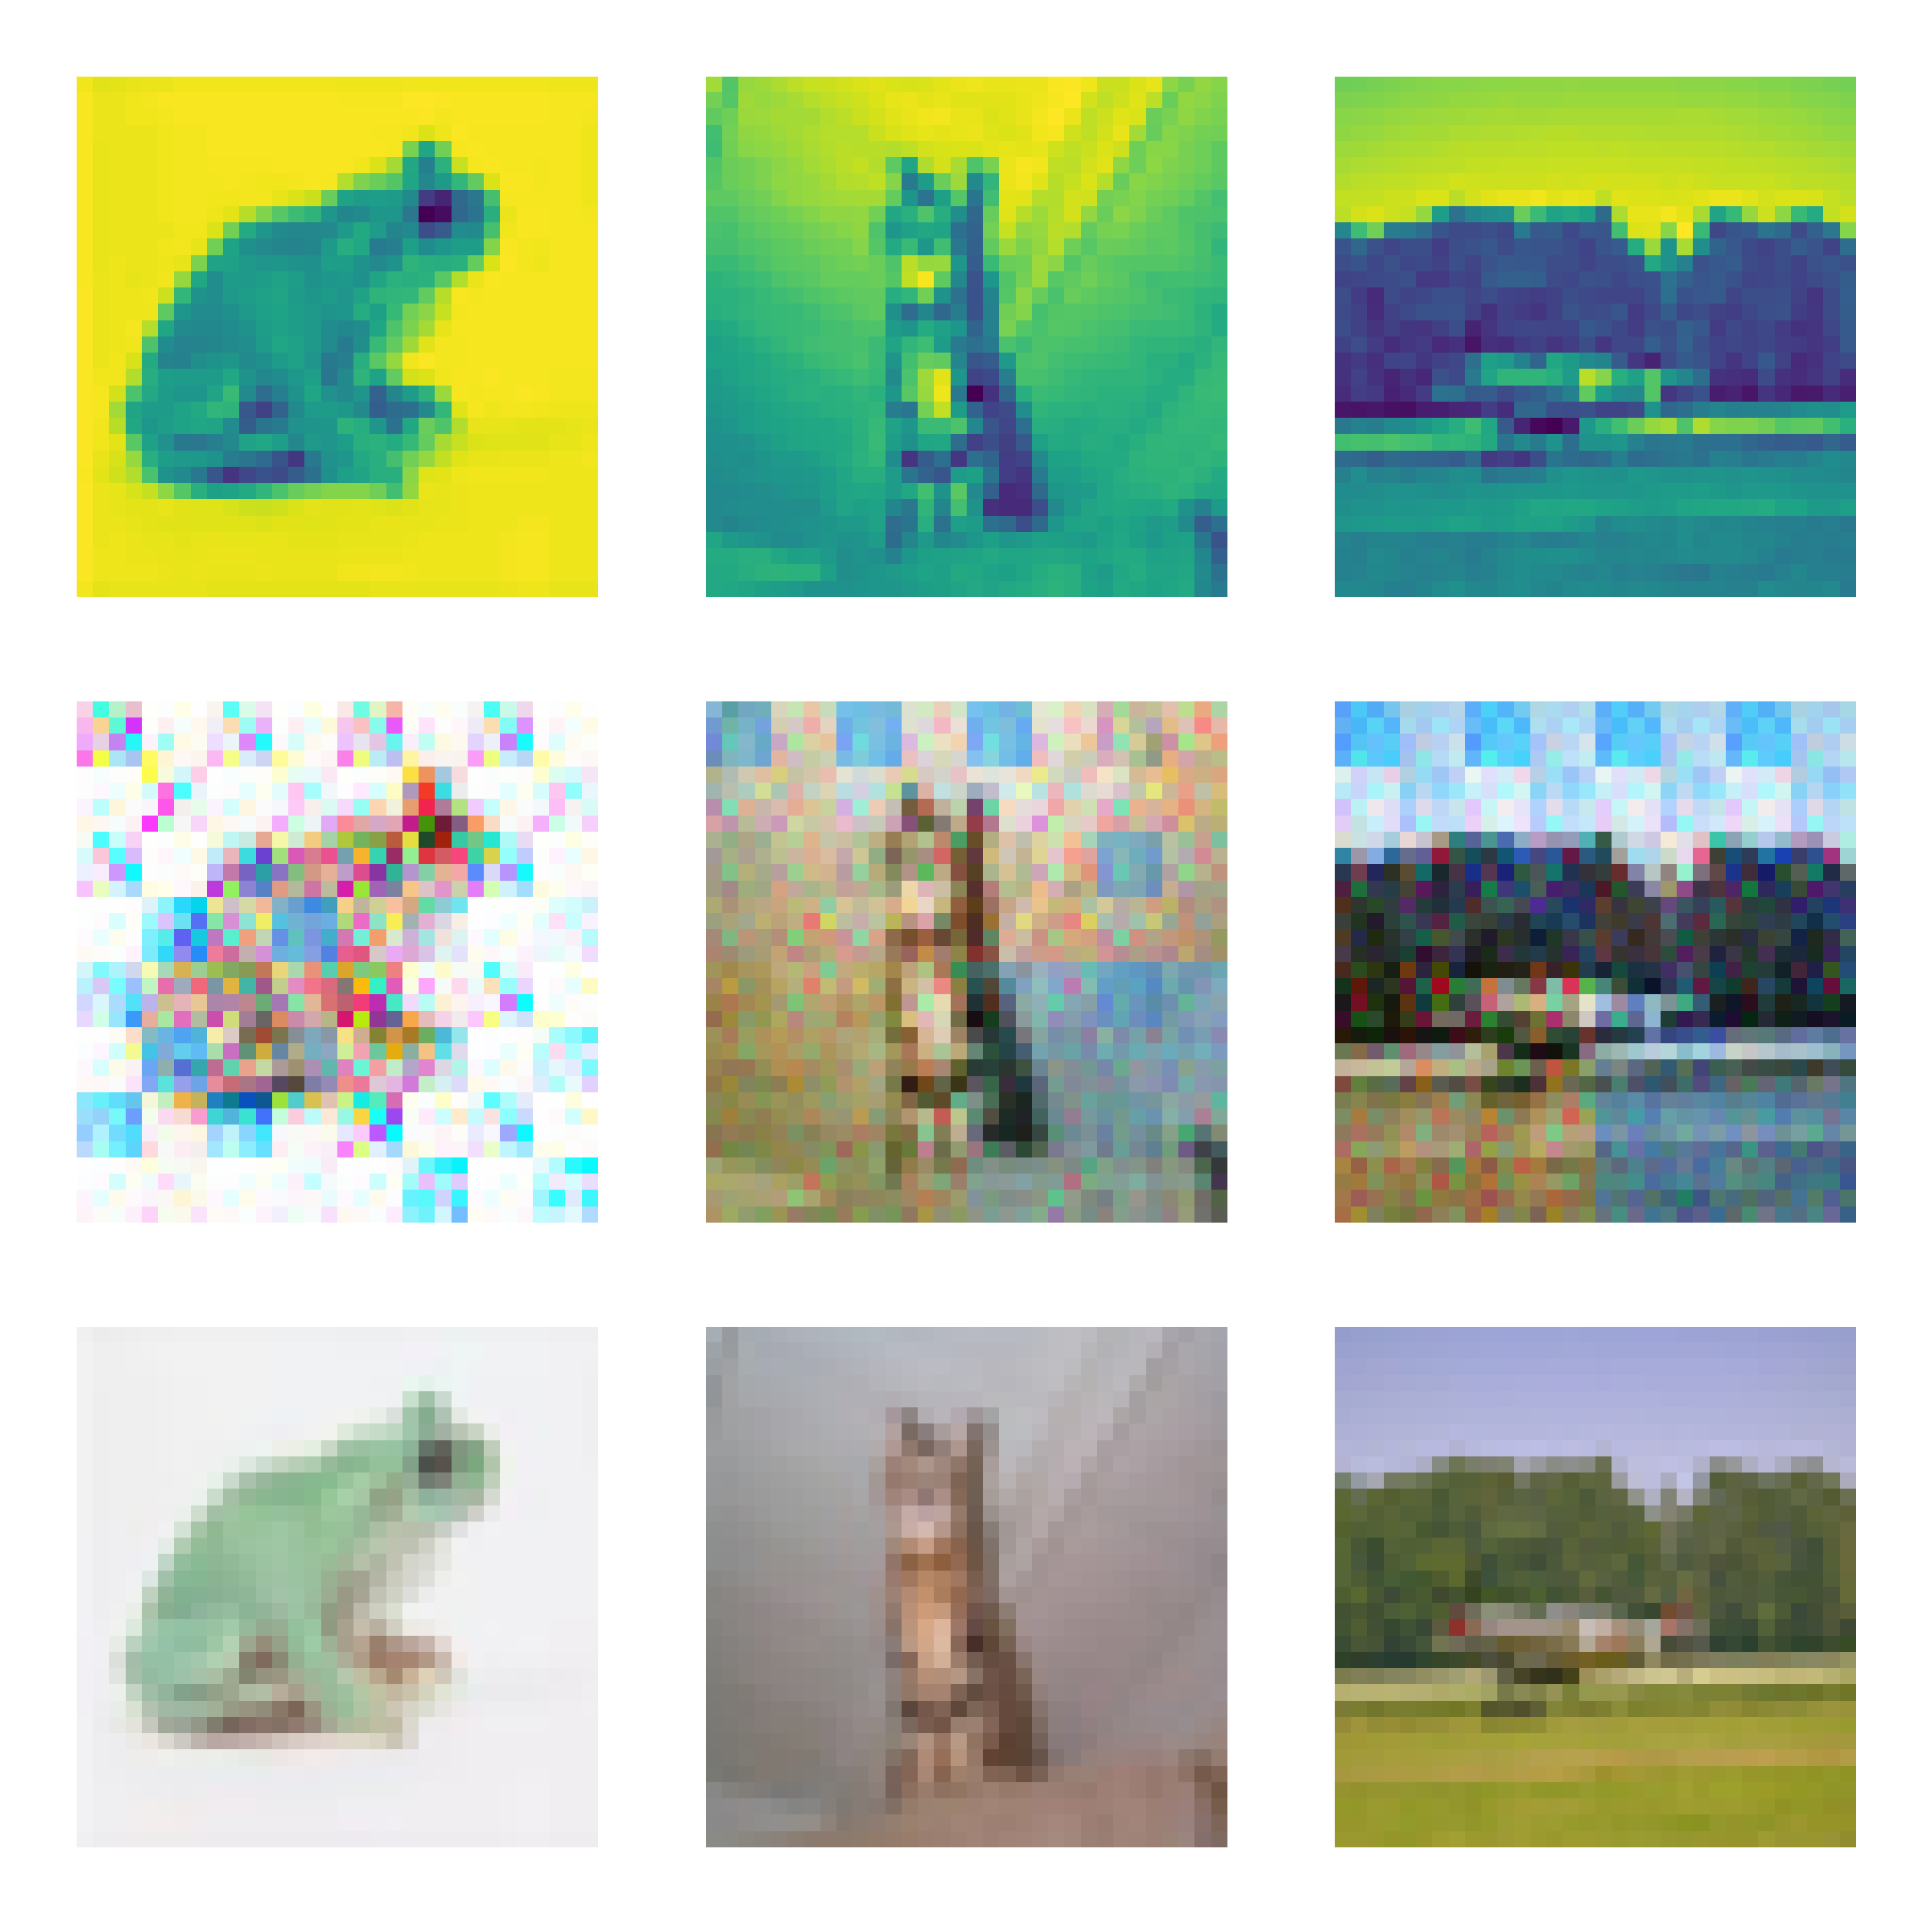

##############
For Epoch:23
Training Discriminator
2/2 [==============================] - 0s 18ms/step
Training Generator
Discriminator Loss:0.1625729800592909
Generator loss:0.659005710711846
1/1 [==============================] - 0s 19ms/step


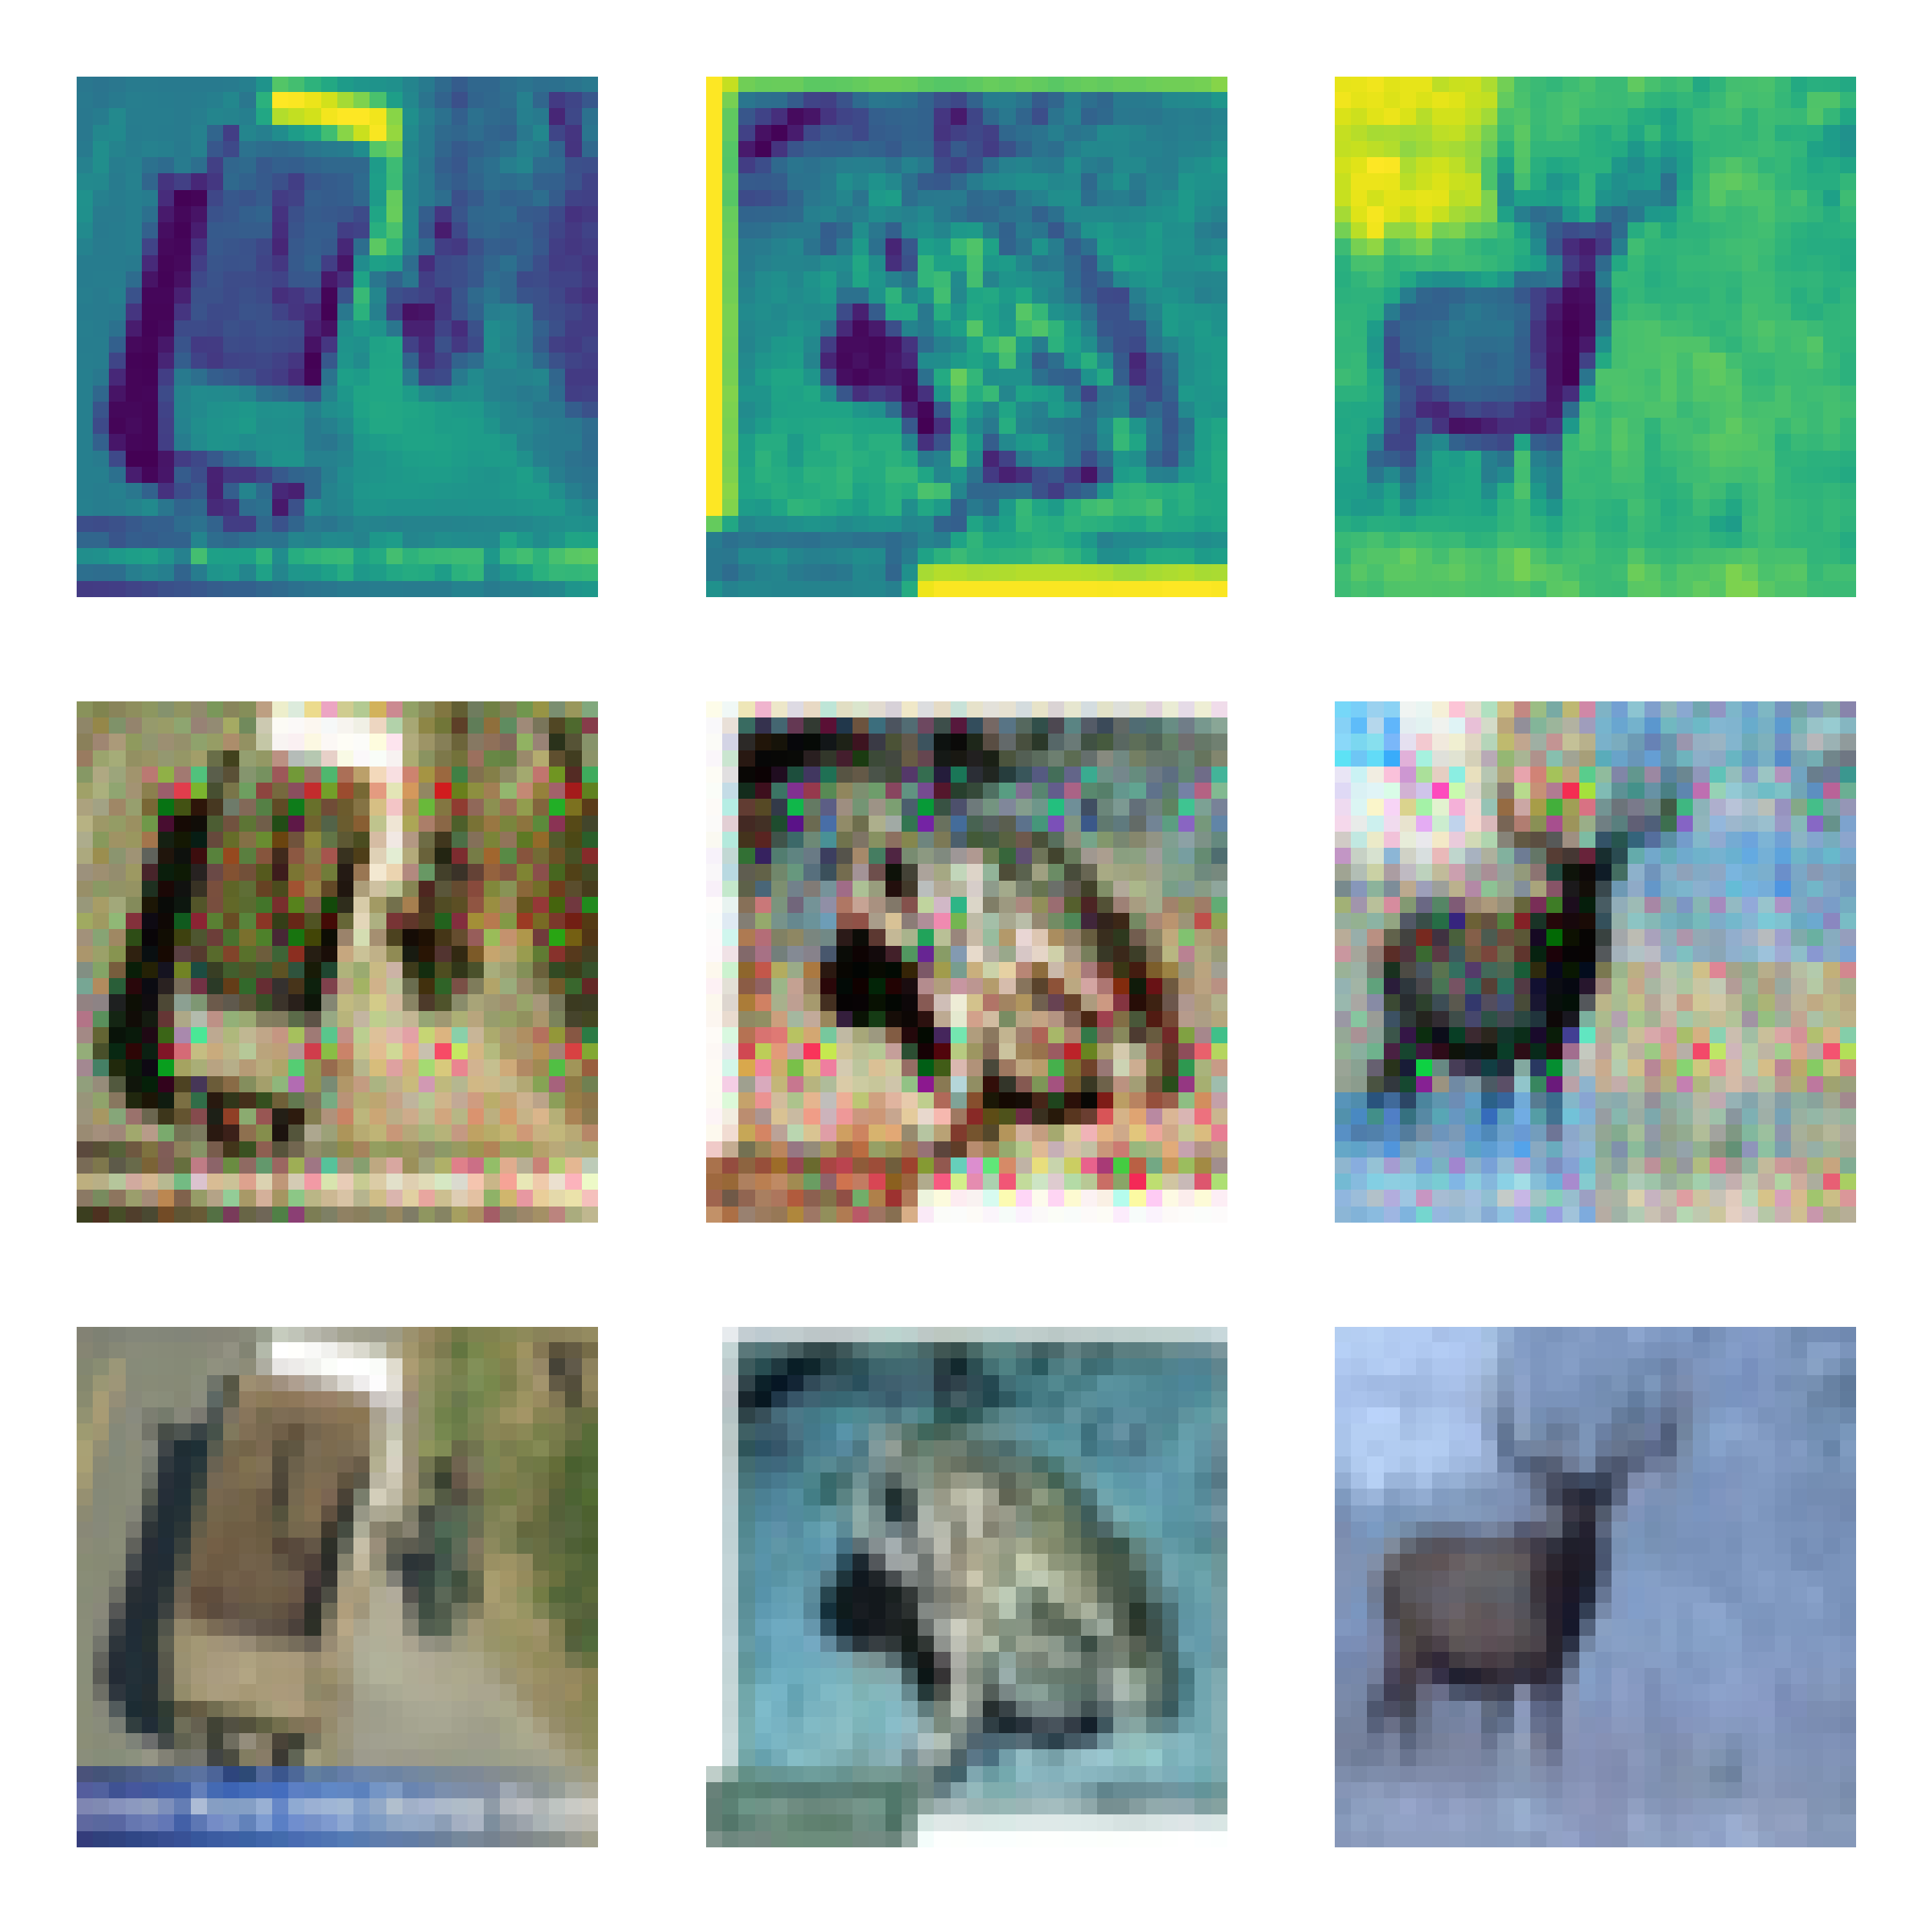

##############
For Epoch:24
Training Discriminator
2/2 [==============================] - 0s 104ms/step


In [ ]:

for epoch in range(epochs):
  print("##############")
  print("For Epoch:"+str(epoch))
  
  g_loss = 0
  d_loss = 0
  
  print("Training Discriminator")
  
  i = shuffle(range(n_example))
  
  dis.trainable = True
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
  
  for j in range(dis_updates):
      
    for b in range(batches):
        
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
      pre_batch = gen.predict(x_batch)
      
      d_loss += dis.train_on_batch([x_batch,y_batch],one)
      d_loss += dis.train_on_batch([x_batch,pre_batch],zero)
      
  print("Training Generator")
  
  dis.trainable = False
  combined.compile(loss  = "binary_crossentropy", optimizer = adams)  
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
        
  for  j in range(gen_updates):
    
    for b in range(batches):
      
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
        
      #in case the mode collapse takes place....commenting next two lines might help.
      #if b%4==3:
        #gl,_,_ = combined.train_on_batch([x_batch,y_batch],[zero,one])  
      
      gl,_,_ = combined.train_on_batch([x_batch,y_batch],[one,one])
      g_loss += gl
      
  g_loss /= g_loss_factor
  d_loss /= d_loss_factor
      
  print("Discriminator Loss:"+str(d_loss))
  print("Generator loss:"+str(g_loss))
  
  genLoss.append(g_loss)
  disLoss.append(d_loss)
  
  gen.save_weights("C:/Users/exam1/Downloads/Generator.h5")
  dis.save_weights("C:/Users/exam1/Downloads/Discriminator.h5")
  


  plt_indices = np.random.randint(50000,size=4)
  plt_a = x[plt_indices]
  plt_b = gen.predict(plt_a)
  plt_b = (plt_b+1)/2
  plt_c = (y[plt_indices]+1)/2
  fig = plot(plt_a,plt_b,plt_c,3)
  plt.show()
  plt.close(fig)
 


plt.plot(genLoss, c='r', label="Generator Loss")
plt.plot(disLoss, c='b', label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# files.download('Generator.h5')
# files.download('Discriminator.h5')

